# TOP

In [1]:
%reset -f

import ROOT, numpy, json
from collections import defaultdict

ROOT.ROOT.EnableImplicitMT(12)

ROOT.gErrorIgnoreLevel = ROOT.kWarning

ROOT.gStyle.SetOptFit(1)
ROOT.gStyle.SetOptStat(0)

ROOT.gStyle.SetGridColor(17)
ROOT.gStyle.SetPadGridX(1)
ROOT.gStyle.SetPadGridY(1)

ROOT.gStyle.SetPadRightMargin(0.01)
ROOT.gStyle.SetPadLeftMargin(0.075)
ROOT.gStyle.SetPadBottomMargin(0.12)

ROOT.gStyle.SetTitleFont(42,'xy')
ROOT.gStyle.SetTitleFont(42,'T')
ROOT.gStyle.SetTitleSize(0.075, 'XY')
ROOT.gStyle.SetTitleSize(0.1, 'T')
ROOT.gStyle.SetTitleOffset(0.8, 'X')
ROOT.gStyle.SetTitleOffset(0.58, 'Y')
ROOT.gStyle.SetLabelFont(42,'xy')
ROOT.gStyle.SetLabelSize(0.07, 'XY')

ROOT.gStyle.SetMarkerSize(2)
ROOT.TH1.AddDirectory(0)


%run -i eppi0_columns.py
%run -i eppi0_binning_scheme_v3.py
%run -i eppi0_bsa.py

cut = "&&".join(f"(((int)status)&(1<<{i}))" for i in [prodc])
cut += "&& abs(dphi)<4 && dpz>-0.5 && dpz<0.9 && mm2>-0.3 && mm2<0.4"
cut += "&& abs(dpt)<0.3"
cut += "&& thp<44.106+-6.625*pp+1.438*pp*pp"

dfs = []
#for fname in ["data/lvl2_eppi0.inb.qa.ecorr.pcorr.root", "data/lvl2_eppi0.outb.qa.ecorr.pcorr.root", "data/lvl2_eppi0.inb.qa.nofiducials.ecorr.pcorr.root", "data/lvl2_eppi0.outb.qa.nofiducials.ecorr.pcorr.root"]:
#for fname in ["data/lvl2_eppi0.inb.qa.ecorr.pcorr.root", "data/lvl2_eppi0.outb.qa.ecorr.pcorr.root", "data/lvl3_eppi0.inb.qa.ecorr.pcorr.root", "data/lvl3_eppi0.outb.qa.ecorr.pcorr.root"]:
for fname in ["data/lvl2_eppi0.inb.qa.ecorr.pcorr.root", "data/lvl2_eppi0.outb.qa.ecorr.pcorr.root"]:
    df = ROOT.RDataFrame("h22", fname)
    df = define_eppi0_columns_using_proton(df)
    df = df.Filter(cut)
    df = define_eppi0_bins(df, fname)
    for status in ["&&".join(f"(((int)status)&(1<<{i}))" for i in [ecloose,gloosest]), 'true']:
        df1 = df.Filter(status)
        rdf = process_eppi0_bins(df1,fname)
        dfs.append(rdf)


rdfs = [] 
for rdf in dfs:
    make_allbsas(rdf)
    make_allbsas(rdf, "fit")

    rdfs.append(rdf)


Welcome to JupyROOT 6.24/06


In [2]:
def xshift(gr0, dx=0):
    for i in range(gr0.GetN()):
        gr0.SetPointX(i, gr0.GetPointX(i)+dx)
    return gr0

dsysts = defaultdict(list)
sysBG,sysFID,sysEXC,sysFIT,sysACC,sysMGR = range(6)

------------------------
------------------------
------------------------

# BG syst
### $A_{LU}$ vs $-t$ for each $\{Q^2,x_B\}$ bin

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


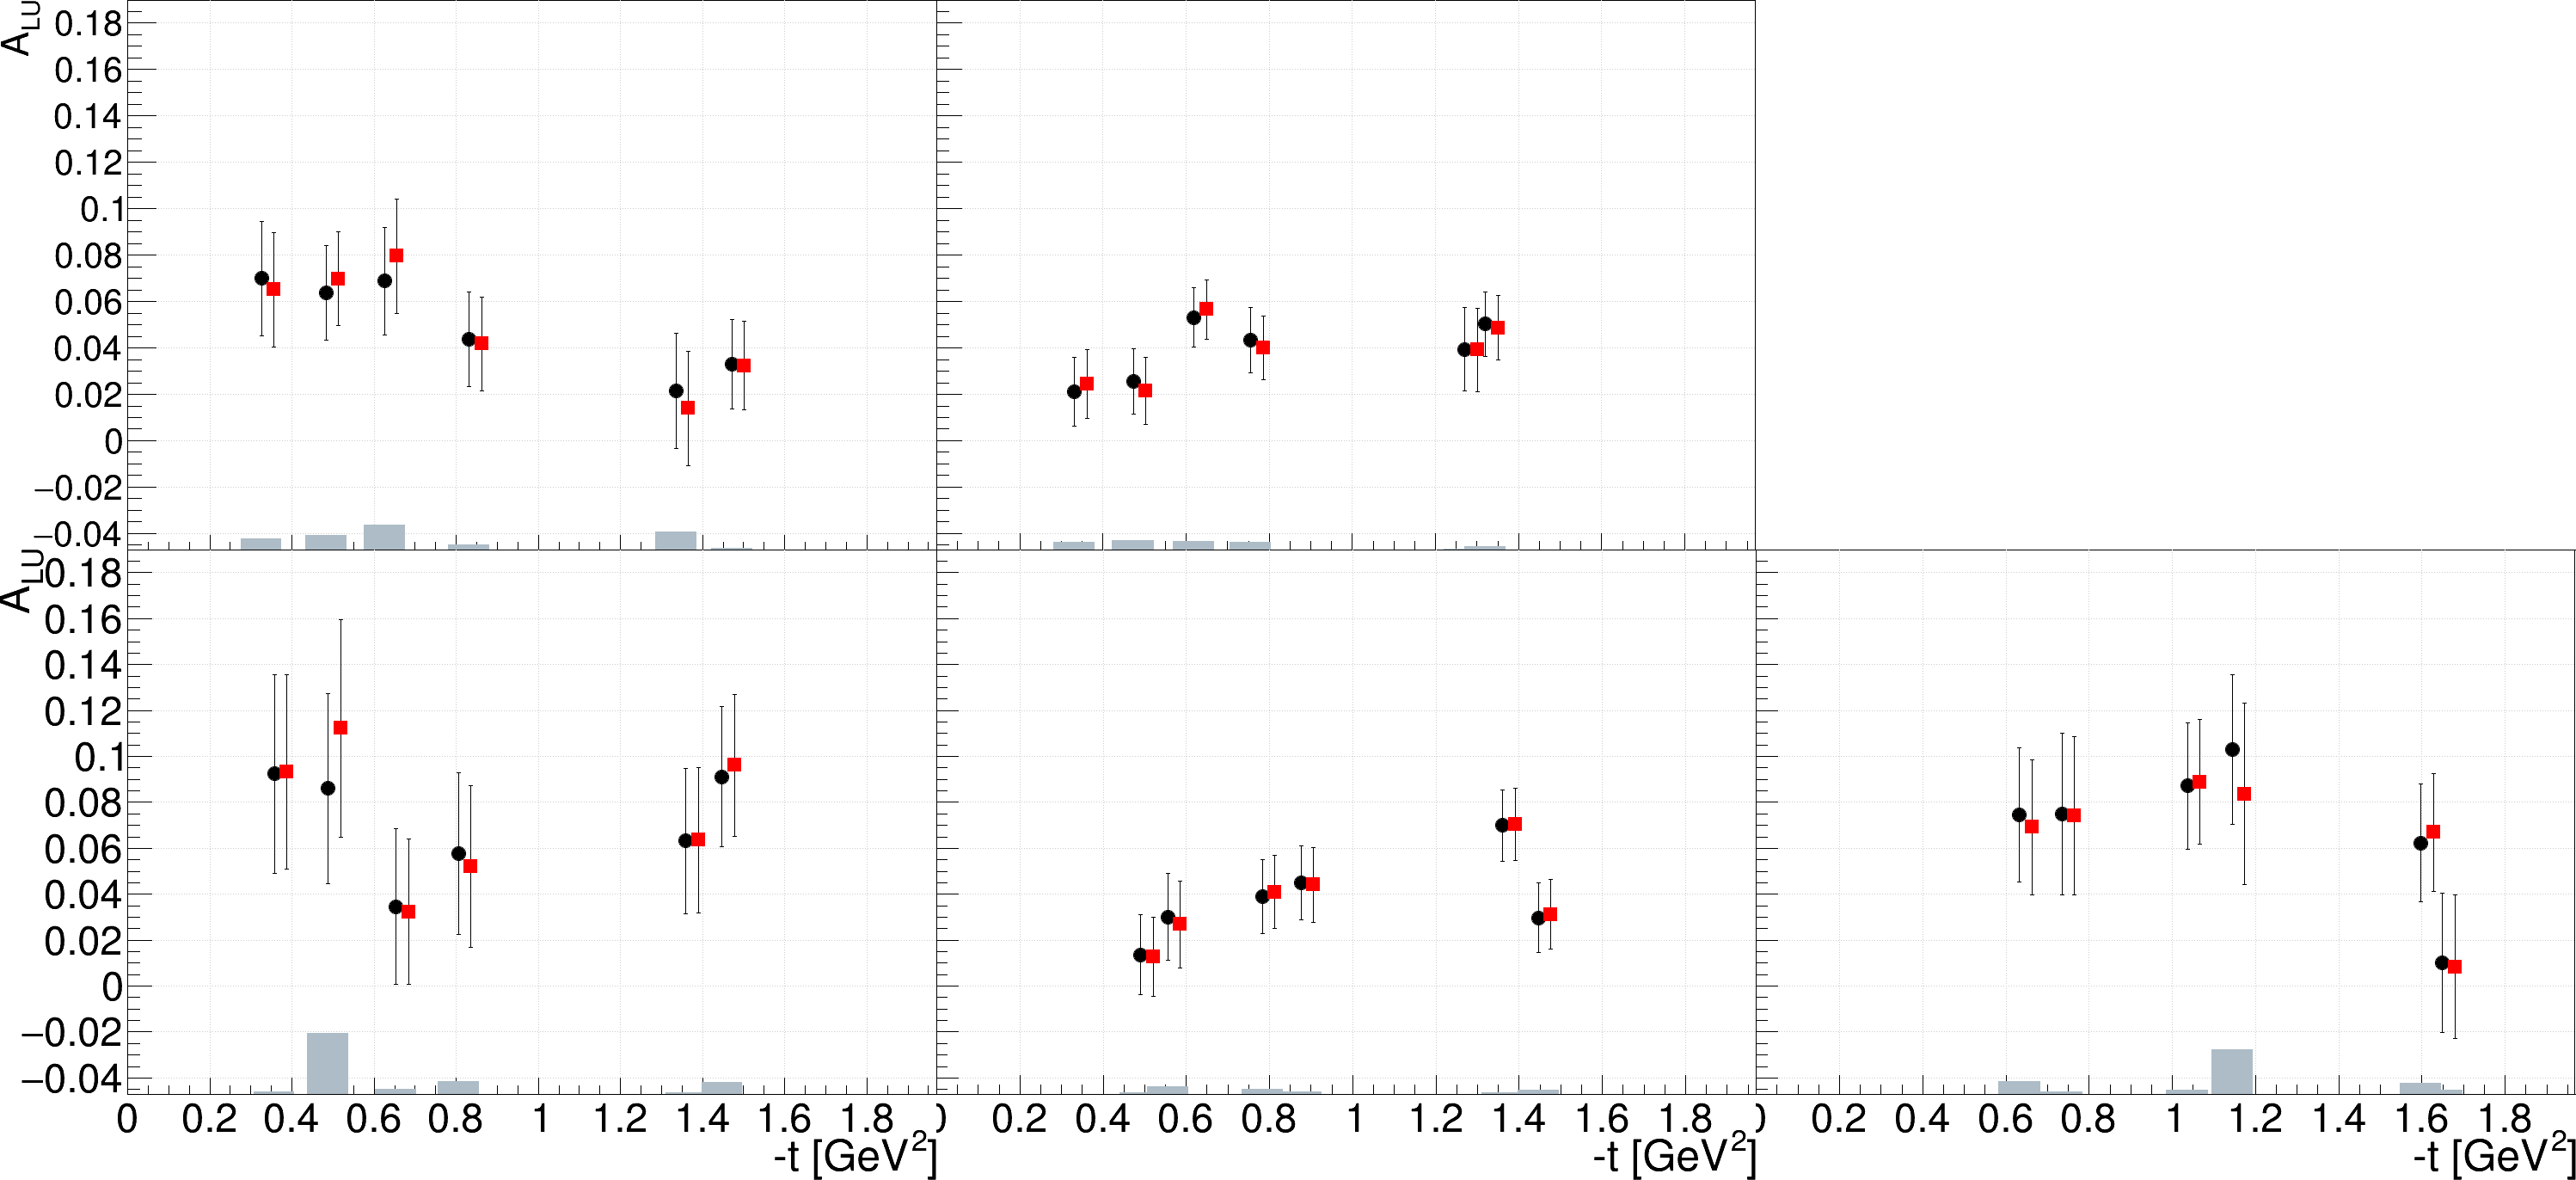

In [3]:
ROOT.gStyle.SetTitleOffset(0.96, 'Y')
ROOT.gStyle.SetPadLeftMargin(0.12)

httdstat = ROOT.TH1F("httdstat","statistical errors;#Delta_{stat}",200,0,0.052)
httdbg = ROOT.TH1F("httdbg","background systematics;#Delta_{syst}",200,0,0.052)

idf,idf1,odf,odf1 = rdfs

c1 = ROOT.TCanvas("c1","c1",3000,1400)
c1.Draw()
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,2,0,0)

grs = []

ipad=0
for iqdf in idf.qdfs:
    oqdf = odf.shards[iqdf.binid]
    ipad += 2 if ipad==2 else 1
    if ipad==2: c1.cd(ipad).SetRightMargin(0.001)

    h1 = c1.cd(ipad).DrawFrame(0,-0.047,1.97,0.19)
    h1.SetTitle(";-t [GeV^{2}];A_{LU}");

    grsys = ROOT.TGraphErrors()

    gr0, gr1 = iqdf.grp1.Clone(), oqdf.grp1.Clone()
    gr2, gr3 = xshift(iqdf.fit.grp1.Clone(),0.03), xshift(oqdf.fit.grp1.Clone(), 0.03)
    for i in range(3):
        httdstat.Fill(gr0.GetErrorY(i))
        httdstat.Fill(gr1.GetErrorY(i))
        httdbg.Fill(abs(gr0.GetPointY(i)-gr2.GetPointY(i)))
        httdbg.Fill(abs(gr1.GetPointY(i)-gr3.GetPointY(i)))
        grsys.SetPoint(grsys.GetN(), gr0.GetPointX(i), -0.047)
        grsys.SetPointError(grsys.GetN()-1, 0.05, abs(gr0.GetPointY(i)-gr2.GetPointY(i)))
        dsysts[(0, iqdf.binid[0], i)].append(abs(gr0.GetPointY(i)-gr2.GetPointY(i)))
        grsys.SetPoint(grsys.GetN(), gr1.GetPointX(i), -0.047)
        grsys.SetPointError(grsys.GetN()-1, 0.05, abs(gr1.GetPointY(i)-gr3.GetPointY(i)))
        dsysts[(1, iqdf.binid[0], i)].append(abs(gr1.GetPointY(i)-gr3.GetPointY(i)))

    gr0.Draw("P")
    gr1.Draw("P")

    gr2.Draw("P")
    gr3.Draw("P")

    gr0.SetMarkerStyle(20)
    gr1.SetMarkerStyle(20)
    gr2.SetMarkerStyle(21)
    gr3.SetMarkerStyle(21)
    gr2.SetMarkerColor(2)
    gr3.SetMarkerColor(2)

    grsys.SetFillColor(33)
    grsys.Draw("2")
    grs.append(grsys)

c1.Print("pdf/systematics.background.ALU.pdf")

In [4]:
for kk in dsysts:
    print(kk, len(dsysts[kk]))

(0, 0, 0) 1
(1, 0, 0) 1
(0, 0, 1) 1
(1, 0, 1) 1
(0, 0, 2) 1
(1, 0, 2) 1
(0, 1, 0) 1
(1, 1, 0) 1
(0, 1, 1) 1
(1, 1, 1) 1
(0, 1, 2) 1
(1, 1, 2) 1
(0, 2, 0) 1
(1, 2, 0) 1
(0, 2, 1) 1
(1, 2, 1) 1
(0, 2, 2) 1
(1, 2, 2) 1
(0, 3, 0) 1
(1, 3, 0) 1
(0, 3, 1) 1
(1, 3, 1) 1
(0, 3, 2) 1
(1, 3, 2) 1
(0, 4, 0) 1
(1, 4, 0) 1
(0, 4, 1) 1
(1, 4, 1) 1
(0, 4, 2) 1
(1, 4, 2) 1


------------------------
------------------------

### BSA graphs for each $\{Q^2,x_B,-t\}$ bin

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


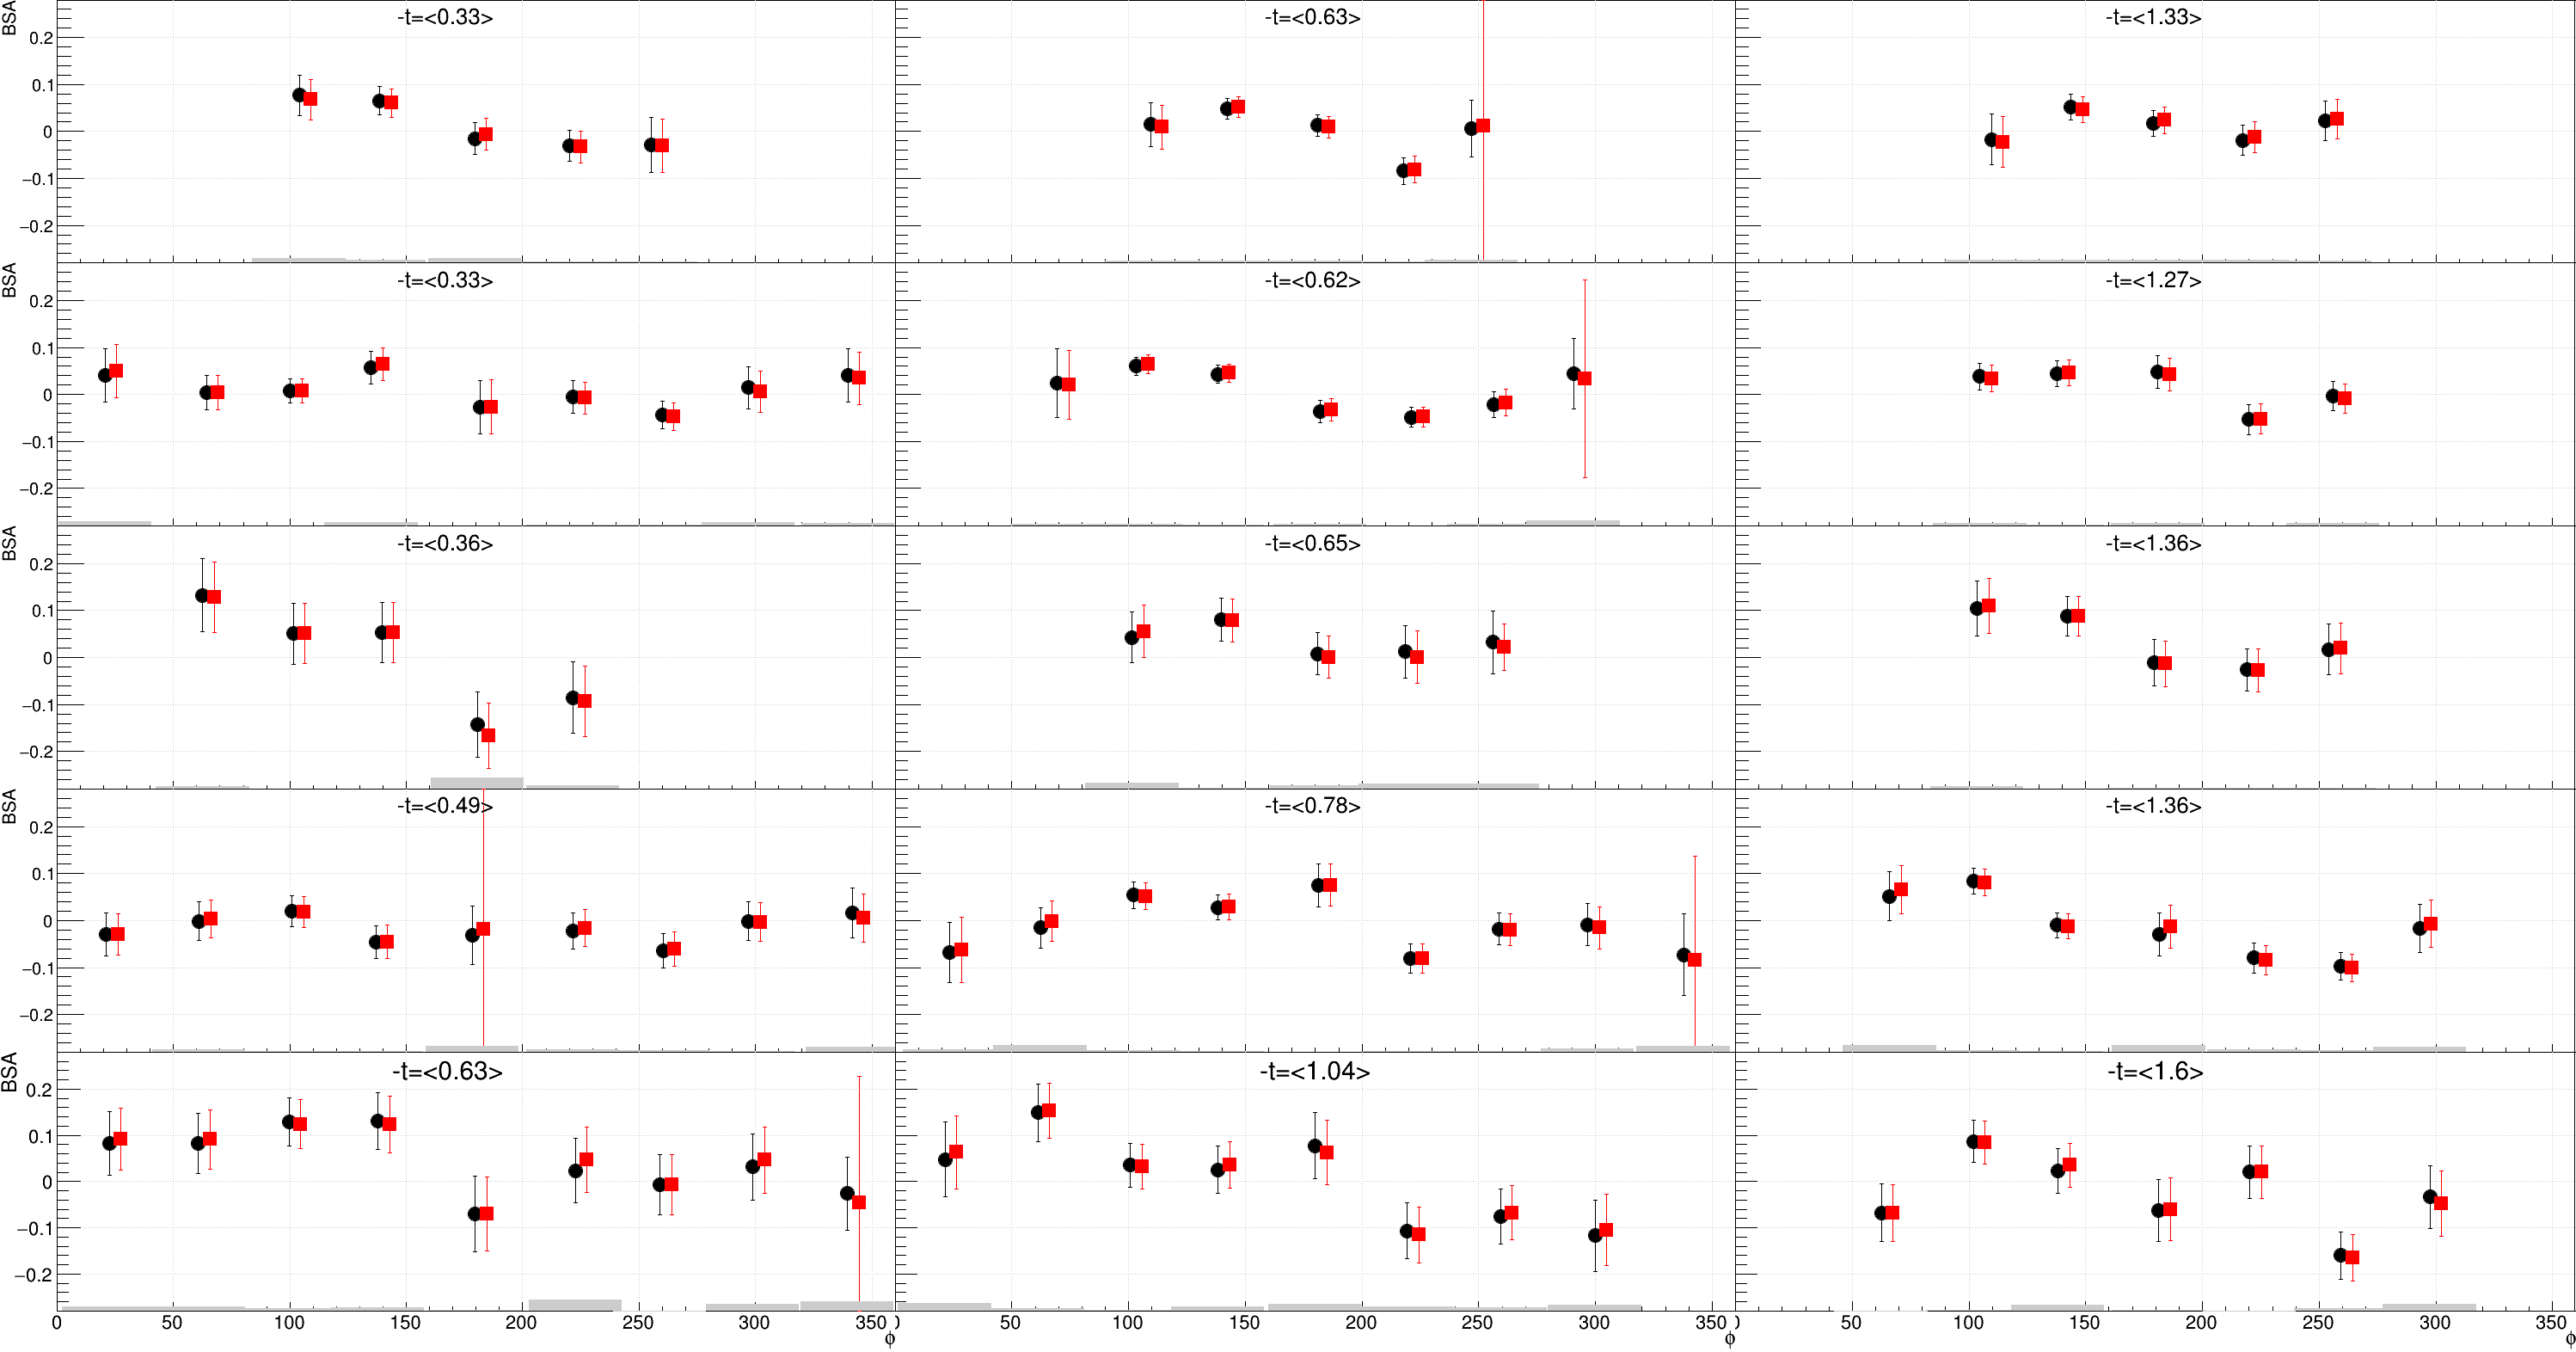

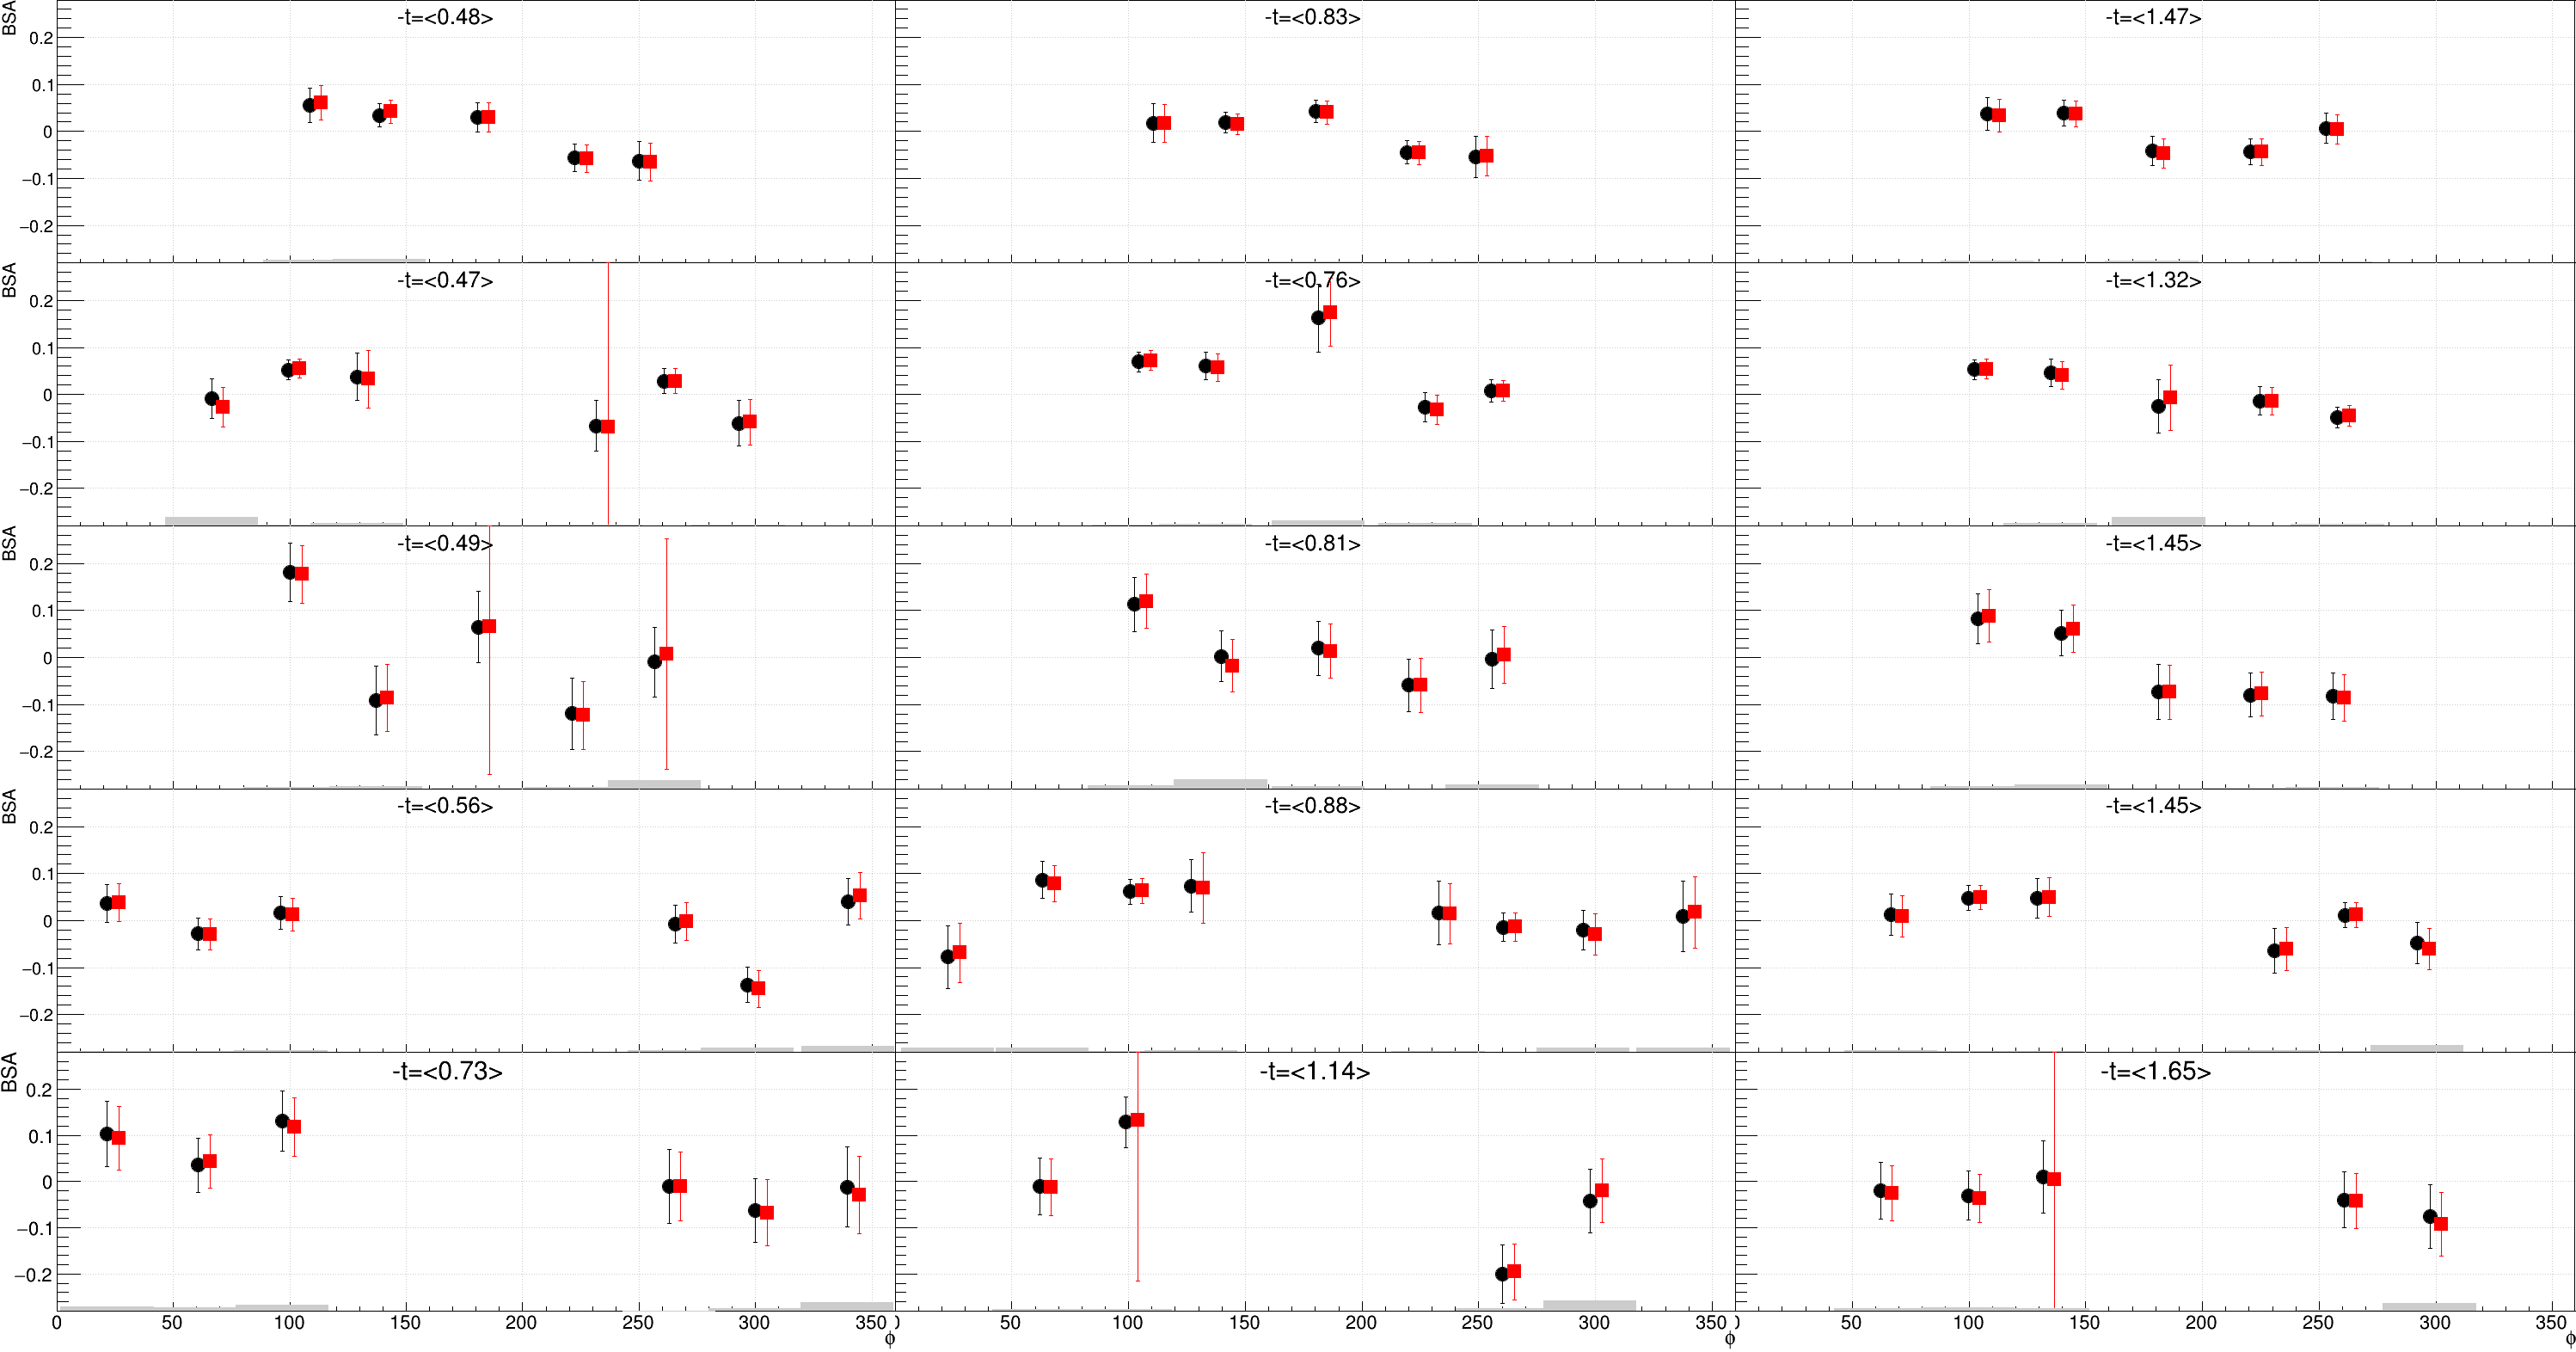

In [5]:
ROOT.gStyle.SetTitleOffset(0.45, 'Y')
ROOT.gStyle.SetPadLeftMargin(0.06)

hfidstat = ROOT.TH1F("hfidstat","statistical errors;#Delta_{stat}",200,0,0.112)
hfidbg = ROOT.TH1F("hfidbg","background systematics;#Delta_{syst}",200,0,0.112)

idf,idf1,odf,odf1 = rdfs

c1 = ROOT.TCanvas("c1","c1",3000,1600)
c1.Draw()
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,5,0,0)

grs = []

ipad=0
for qdf in idf.qdfs:
    for tdf in qdf.tdfs:
        ipad+=1
        h1 = c1.cd(ipad).DrawFrame(0,-0.28,360,0.28)
        h1.SetTitle(f"-t=<{round(tdf.tt,2)}>;#phi;BSA")
        
        grsys = ROOT.TGraphErrors()
        gr0, gr1 = tdf.grbsa.Clone(), xshift(tdf.grf.Clone(), 5)
        for i in range(gr0.GetN()):
            hfidbg.Fill(abs(gr0.GetPointY(i)-gr1.GetPointY(i)))
            hfidstat.Fill(gr0.GetErrorY(i))
            grsys.SetPoint(grsys.GetN(), gr0.GetPointX(i), -0.28)
            grsys.SetPointError(grsys.GetN()-1, 20, abs(gr0.GetPointY(i)-gr1.GetPointY(i)))
        
        gr0.Draw("P")
        gr1.Draw("P")
        
        gr0.SetMarkerStyle(20)
        gr1.SetMarkerStyle(21)
        gr1.SetMarkerColor(2)
        gr1.SetLineColor(2)

        grsys.SetFillColor(17)
        grsys.Draw("2")
        grs.append(grsys)

c1.Print("pdf/systematics.background.BSA.inb.pdf")

c2 = ROOT.TCanvas("c2","c2",3000,1600)
c2.Draw()
c2.SetTopMargin(0)
c2.SetRightMargin(0)
c2.Divide(3,5,0,0)
ipad=0
for qdf in odf.qdfs:
    for tdf in qdf.tdfs:
        ipad+=1
        h1 = c2.cd(ipad).DrawFrame(0,-0.28,360,0.28)
        h1.SetTitle(f"-t=<{round(tdf.tt,2)}>;#phi;BSA")

        grsys = ROOT.TGraphErrors()
        gr0, gr1 = tdf.grbsa.Clone(), xshift(tdf.grf.Clone(), 5)
        for i in range(gr0.GetN()):
            hfidbg.Fill(abs(gr0.GetPointY(i)-gr1.GetPointY(i)))
            hfidstat.Fill(gr0.GetErrorY(i))
            grsys.SetPoint(grsys.GetN(), gr0.GetPointX(i), -0.28)
            grsys.SetPointError(grsys.GetN()-1, 20, abs(gr0.GetPointY(i)-gr1.GetPointY(i)))

        gr0.Draw("P")
        gr1.Draw("P")
        
        gr0.SetMarkerStyle(20)
        gr1.SetMarkerStyle(21)
        gr1.SetMarkerColor(2)
        gr1.SetLineColor(2)

        grsys.SetFillColor(17)
        grsys.Draw("2")
        grs.append(grsys)

c2.Print("pdf/systematics.background.BSA.outb.pdf")

------------------------
------------------------
------------------------

# FIDUCIALS syst
### $A_{LU}$ vs $-t$ for each $\{Q^2,x_B\}$ bin

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


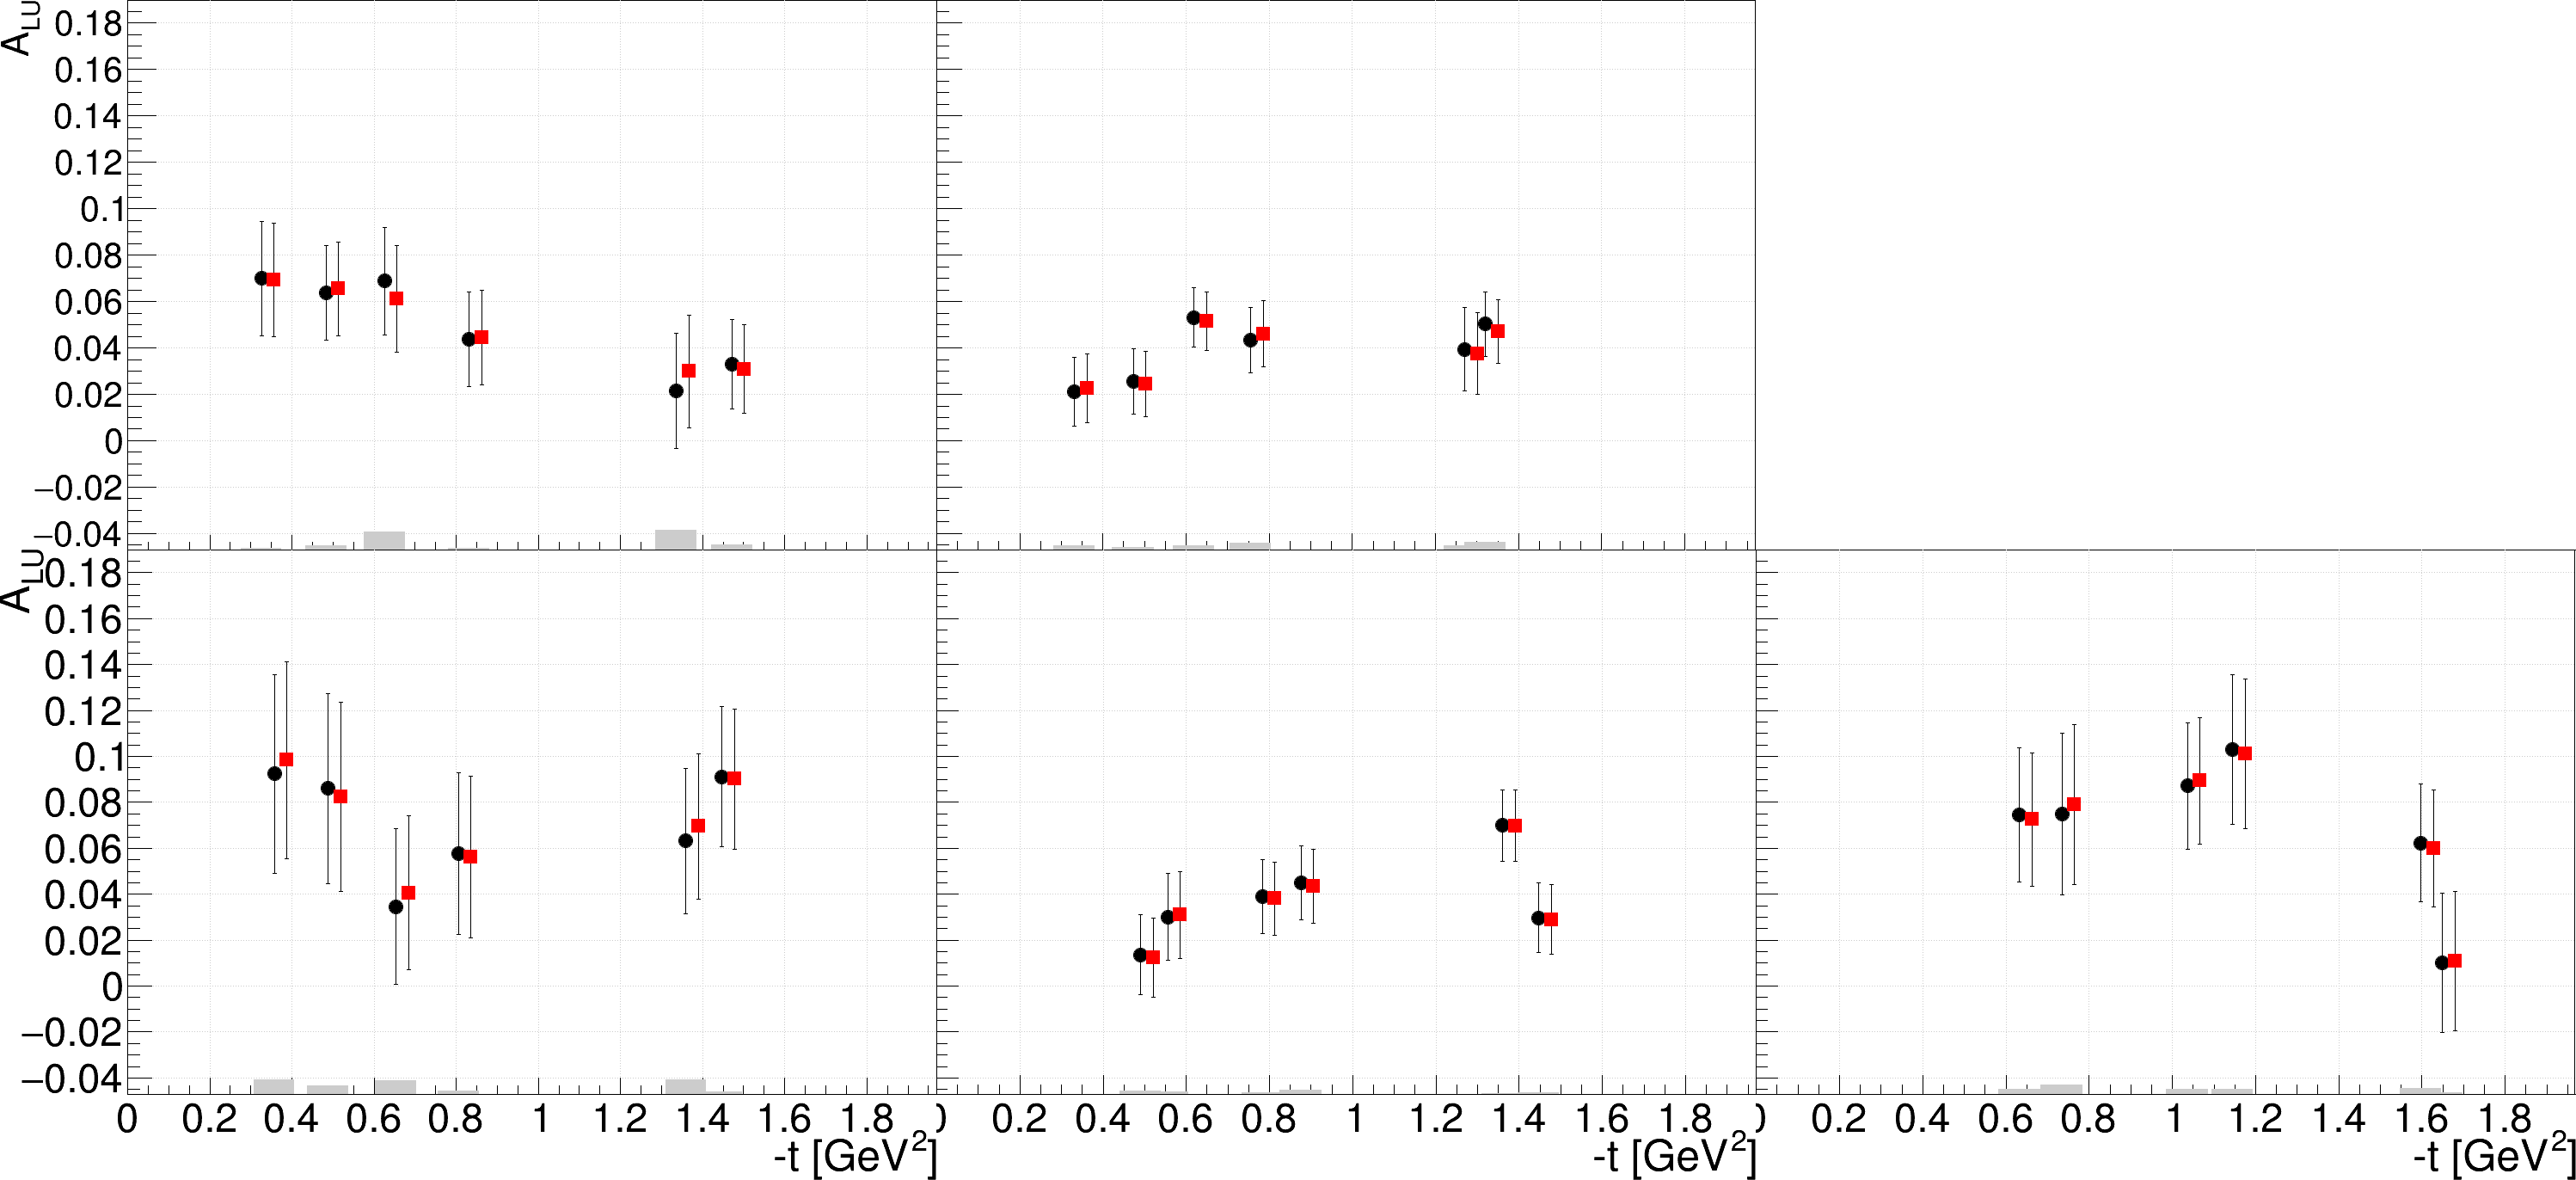

In [6]:
ROOT.gStyle.SetTitleOffset(0.96, 'Y')
ROOT.gStyle.SetPadLeftMargin(0.12)

httdfid = ROOT.TH1F("httfid","fiducial cuts systematics;#Delta_{syst}",200,0,0.052)

idf,idf1,odf,odf1 = rdfs

c1 = ROOT.TCanvas("c1","c1",3000,1400)
c1.Draw()
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,2,0,0)

grs = []

ipad=0
for iqdf in idf.qdfs:
    bid = iqdf.binid
    oqdf = odf.shards[bid]
    iqdf1 = idf1.shards[bid]
    oqdf1 = odf1.shards[bid]

    ipad += 2 if ipad==2 else 1
    if ipad==2: c1.cd(ipad).SetRightMargin(0.001)

    h1 = c1.cd(ipad).DrawFrame(0,-0.047,1.97,0.19)
    h1.SetTitle(";-t [GeV^{2}];A_{LU}");

    grsys = ROOT.TGraphErrors()
    gr0, gr1 = iqdf.grp1.Clone(), oqdf.grp1.Clone()
    gr2, gr3 = xshift(iqdf1.grp1.Clone(),0.03), xshift(oqdf1.grp1.Clone(), 0.03)
    for i in range(3):
        httdfid.Fill(abs(gr0.GetPointY(i)-gr2.GetPointY(i)))
        httdfid.Fill(abs(gr1.GetPointY(i)-gr3.GetPointY(i)))

        grsys.SetPoint(grsys.GetN(), gr0.GetPointX(i), -0.047)
        grsys.SetPointError(grsys.GetN()-1, 0.05, abs(gr0.GetPointY(i)-gr2.GetPointY(i)))
        dsysts[(0, bid[0], i)].append(abs(gr0.GetPointY(i)-gr2.GetPointY(i)))

        grsys.SetPoint(grsys.GetN(), gr1.GetPointX(i), -0.047)
        grsys.SetPointError(grsys.GetN()-1, 0.05, abs(gr1.GetPointY(i)-gr3.GetPointY(i)))
        dsysts[(1, bid[0], i)].append(abs(gr1.GetPointY(i)-gr3.GetPointY(i)))

    gr0.Draw("P")
    gr1.Draw("P")

    gr2.Draw("P")
    gr3.Draw("P")

    gr0.SetMarkerStyle(20)
    gr1.SetMarkerStyle(20)
    gr2.SetMarkerStyle(21)
    gr3.SetMarkerStyle(21)
    gr2.SetMarkerColor(2)
    gr3.SetMarkerColor(2)
    
    grsys.SetFillColor(17)
    grsys.Draw("2")
    grs.append(grsys)

c1.Print("pdf/systematics.fiducials.ALU.pdf")

In [7]:
for kk in dsysts:
    print(kk, len(dsysts[kk]))

(0, 0, 0) 2
(1, 0, 0) 2
(0, 0, 1) 2
(1, 0, 1) 2
(0, 0, 2) 2
(1, 0, 2) 2
(0, 1, 0) 2
(1, 1, 0) 2
(0, 1, 1) 2
(1, 1, 1) 2
(0, 1, 2) 2
(1, 1, 2) 2
(0, 2, 0) 2
(1, 2, 0) 2
(0, 2, 1) 2
(1, 2, 1) 2
(0, 2, 2) 2
(1, 2, 2) 2
(0, 3, 0) 2
(1, 3, 0) 2
(0, 3, 1) 2
(1, 3, 1) 2
(0, 3, 2) 2
(1, 3, 2) 2
(0, 4, 0) 2
(1, 4, 0) 2
(0, 4, 1) 2
(1, 4, 1) 2
(0, 4, 2) 2
(1, 4, 2) 2


------------------------
------------------------

### BSA graphs for each $\{Q^2,x_B,-t\}$ bin

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


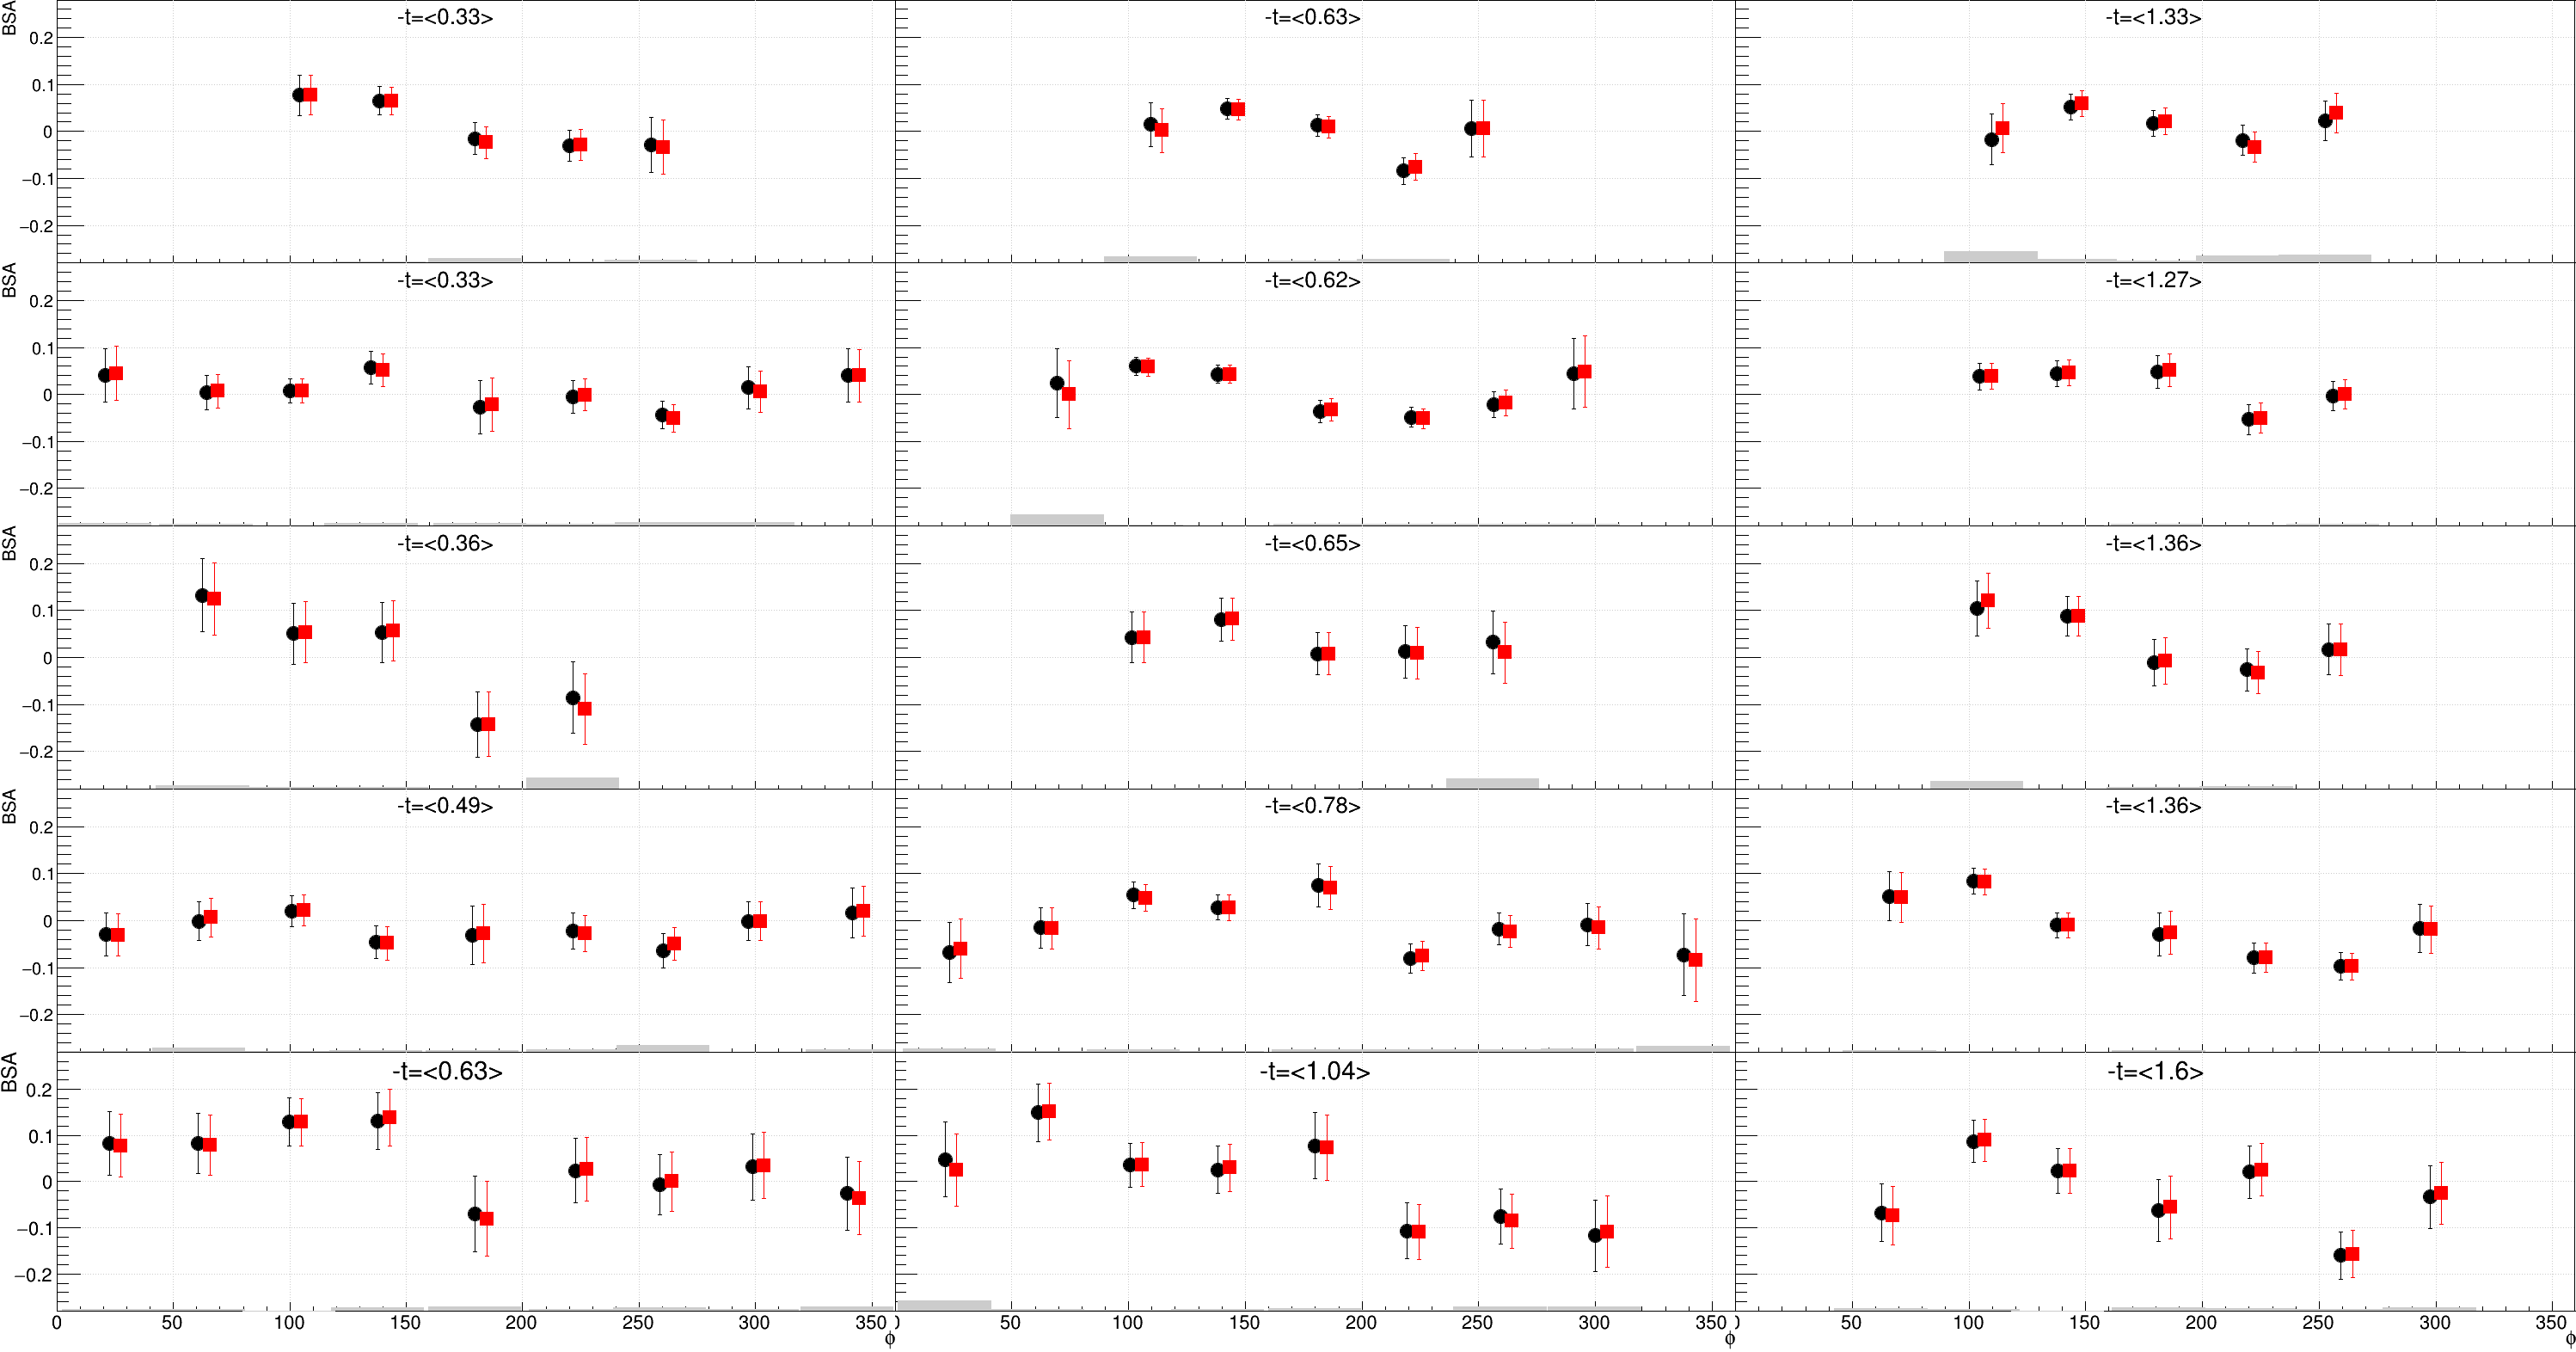

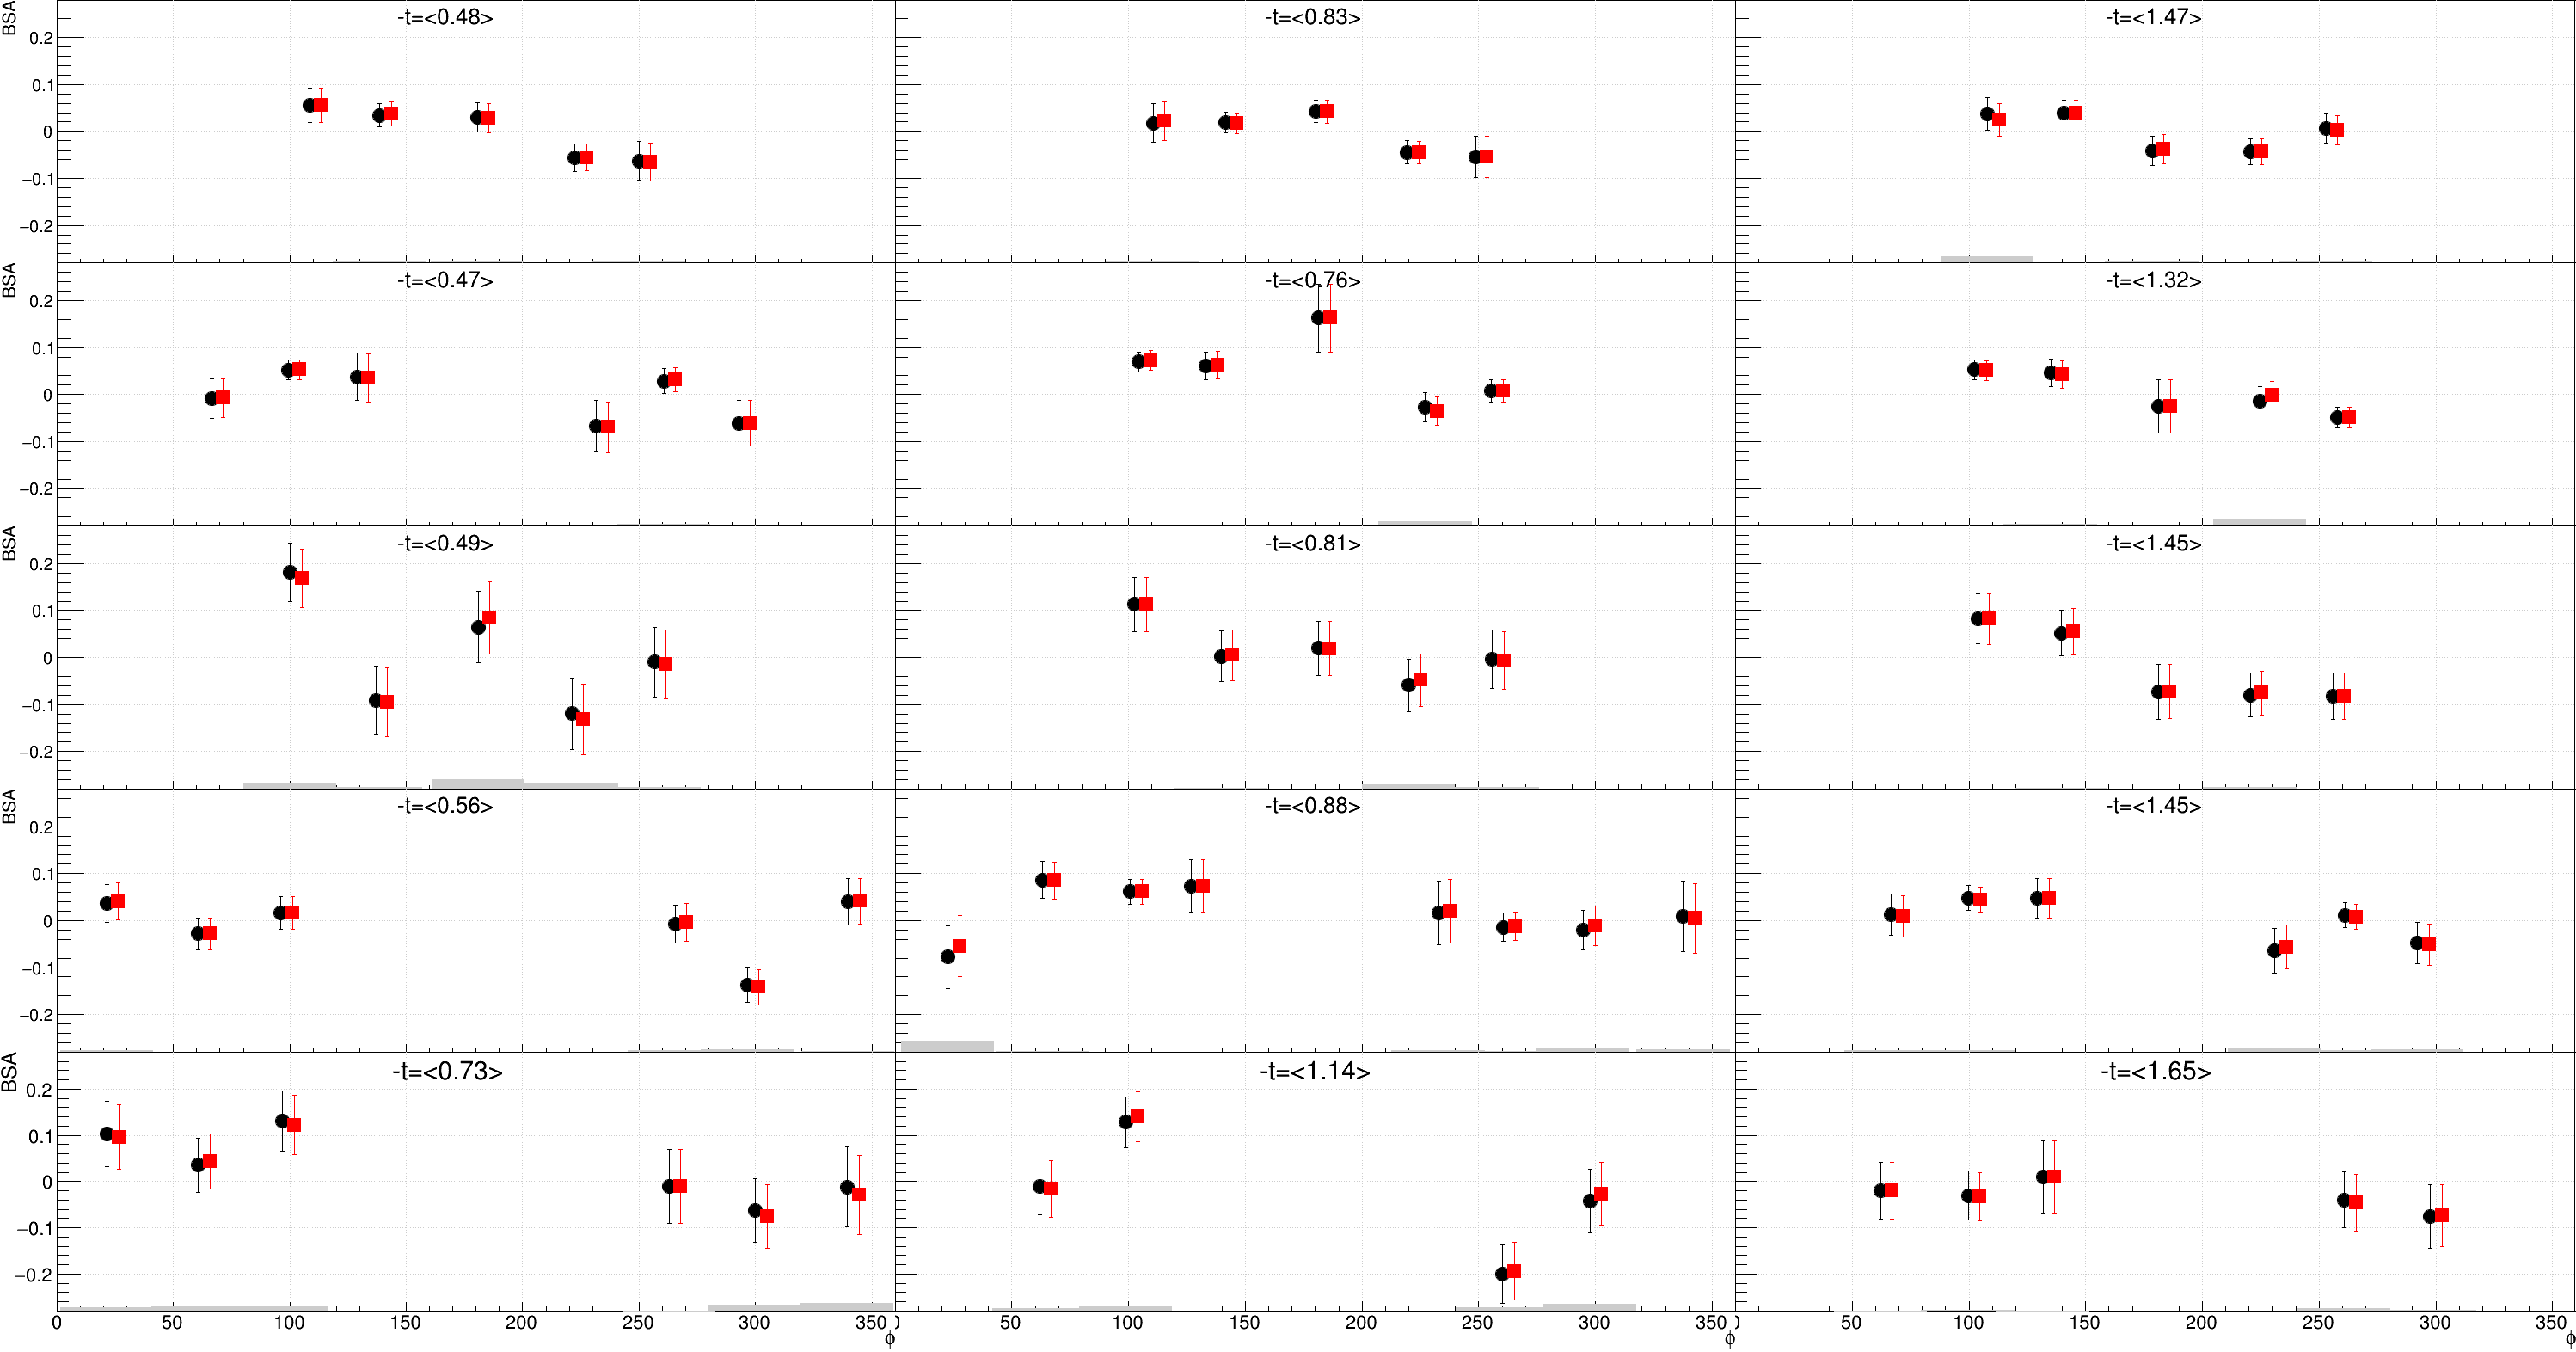

In [8]:
ROOT.gStyle.SetTitleOffset(0.45, 'Y')
ROOT.gStyle.SetPadLeftMargin(0.06)

hfidfid = ROOT.TH1F("hfifid","fiducial cuts systematics;#Delta_{syst}",200,0,0.112)

idf,idf1,odf,odf1 = rdfs

c1 = ROOT.TCanvas("c1","c1",3000,1600)
c1.Draw()
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,5,0,0)

fibins = range(0,361,40)
grs = []

ipad=0
for qdf in idf.qdfs:
    for tdf in qdf.tdfs:
        ipad+=1
        bid = tdf.binid
        itdf1 = idf1.shards[bid]

        h1 = c1.cd(ipad).DrawFrame(0,-0.28,360,0.28)
        h1.SetTitle(f"-t=<{round(tdf.tt,2)}>;#phi;BSA")

        grsys = ROOT.TGraphErrors()
        gr0, gr1 = tdf.grbsa.Clone(), xshift(itdf1.grbsa.Clone(), 5)
        y1s = {numpy.digitize(gr1.GetPointX(i), fibins):gr1.GetPointY(i) for i in range(gr1.GetN())}
        for i in range(gr0.GetN()):
            y1 = y1s[numpy.digitize(gr0.GetPointX(i), fibins)]
            hfidfid.Fill(abs(gr0.GetPointY(i)-y1))
            grsys.SetPoint(grsys.GetN(), gr0.GetPointX(i), -0.28)
            grsys.SetPointError(grsys.GetN()-1, 20, abs(gr0.GetPointY(i)-y1))

        gr0.Draw("P")
        gr1.Draw("P")
        
        gr0.SetMarkerStyle(20)
        gr1.SetMarkerStyle(21)
        gr1.SetMarkerColor(2)
        gr1.SetLineColor(2)

        grsys.SetFillColor(17)
        grsys.Draw("2")
        grs.append(grsys)
        
c1.Print("pdf/systematics.fiducials.BSA.inb.pdf")


c2 = ROOT.TCanvas("c2","c2",3000,1600)
c2.Draw()
c2.SetTopMargin(0)
c2.SetRightMargin(0)
c2.Divide(3,5,0,0)
ipad=0
for qdf in odf.qdfs:
    for tdf in qdf.tdfs:
        ipad+=1
        bid = tdf.binid
        otdf1 = odf1.shards[bid]

        h1 = c2.cd(ipad).DrawFrame(0,-0.28,360,0.28)
        h1.SetTitle(f"-t=<{round(tdf.tt,2)}>;#phi;BSA")

        grsys = ROOT.TGraphErrors()
        gr0, gr1 = tdf.grbsa.Clone(), xshift(otdf1.grbsa.Clone(), 5)
        y1s = {numpy.digitize(gr1.GetPointX(i), fibins):gr1.GetPointY(i) for i in range(gr1.GetN())}
        for i in range(gr0.GetN()):
            y1 = y1s[numpy.digitize(gr0.GetPointX(i), fibins)]
            hfidfid.Fill(abs(gr0.GetPointY(i)-y1))
            grsys.SetPoint(grsys.GetN(), gr0.GetPointX(i), -0.28)
            grsys.SetPointError(grsys.GetN()-1, 20, abs(gr0.GetPointY(i)-y1))
        
        gr0.Draw("P")
        gr1.Draw("P")
        
        gr0.SetMarkerStyle(20)
        gr1.SetMarkerStyle(21)
        gr1.SetMarkerColor(2)
        gr1.SetLineColor(2)

        grsys.SetFillColor(17)
        grsys.Draw("2")
        grs.append(grsys)
        
c2.Print("pdf/systematics.fiducials.BSA.outb.pdf")


------------------------
------------------------
------------------------

# EXCLUSIVE syst
### Loading systematic exclusive graphs

In [9]:
from collections import defaultdict
import random, numpy


fsyst = ROOT.TFile('data/systematics.graphs.root')
igrp1s,igrbsas = defaultdict(list),defaultdict(list)
ogrp1s,ogrbsas = defaultdict(list),defaultdict(list)
for kk in fsyst.GetListOfKeys():
    tpl,gr = eval(kk.GetName()),kk.ReadObj()
    if 'grp1' in tpl:
        if 'inb' in tpl[0]:
            igrp1s[tpl[2:]].append(gr)
        else:
            ogrp1s[tpl[2:]].append(gr)
    elif 'grbsa' in tpl:
        if 'inb' in tpl[0]:
            igrbsas[tpl[2:]].append(gr)
        else:
            ogrbsas[tpl[2:]].append(gr)


---------------------------
---------------------------

### $A_{LU}$ vs $-t$ for each $\{Q^2,x_B\}$ bin

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


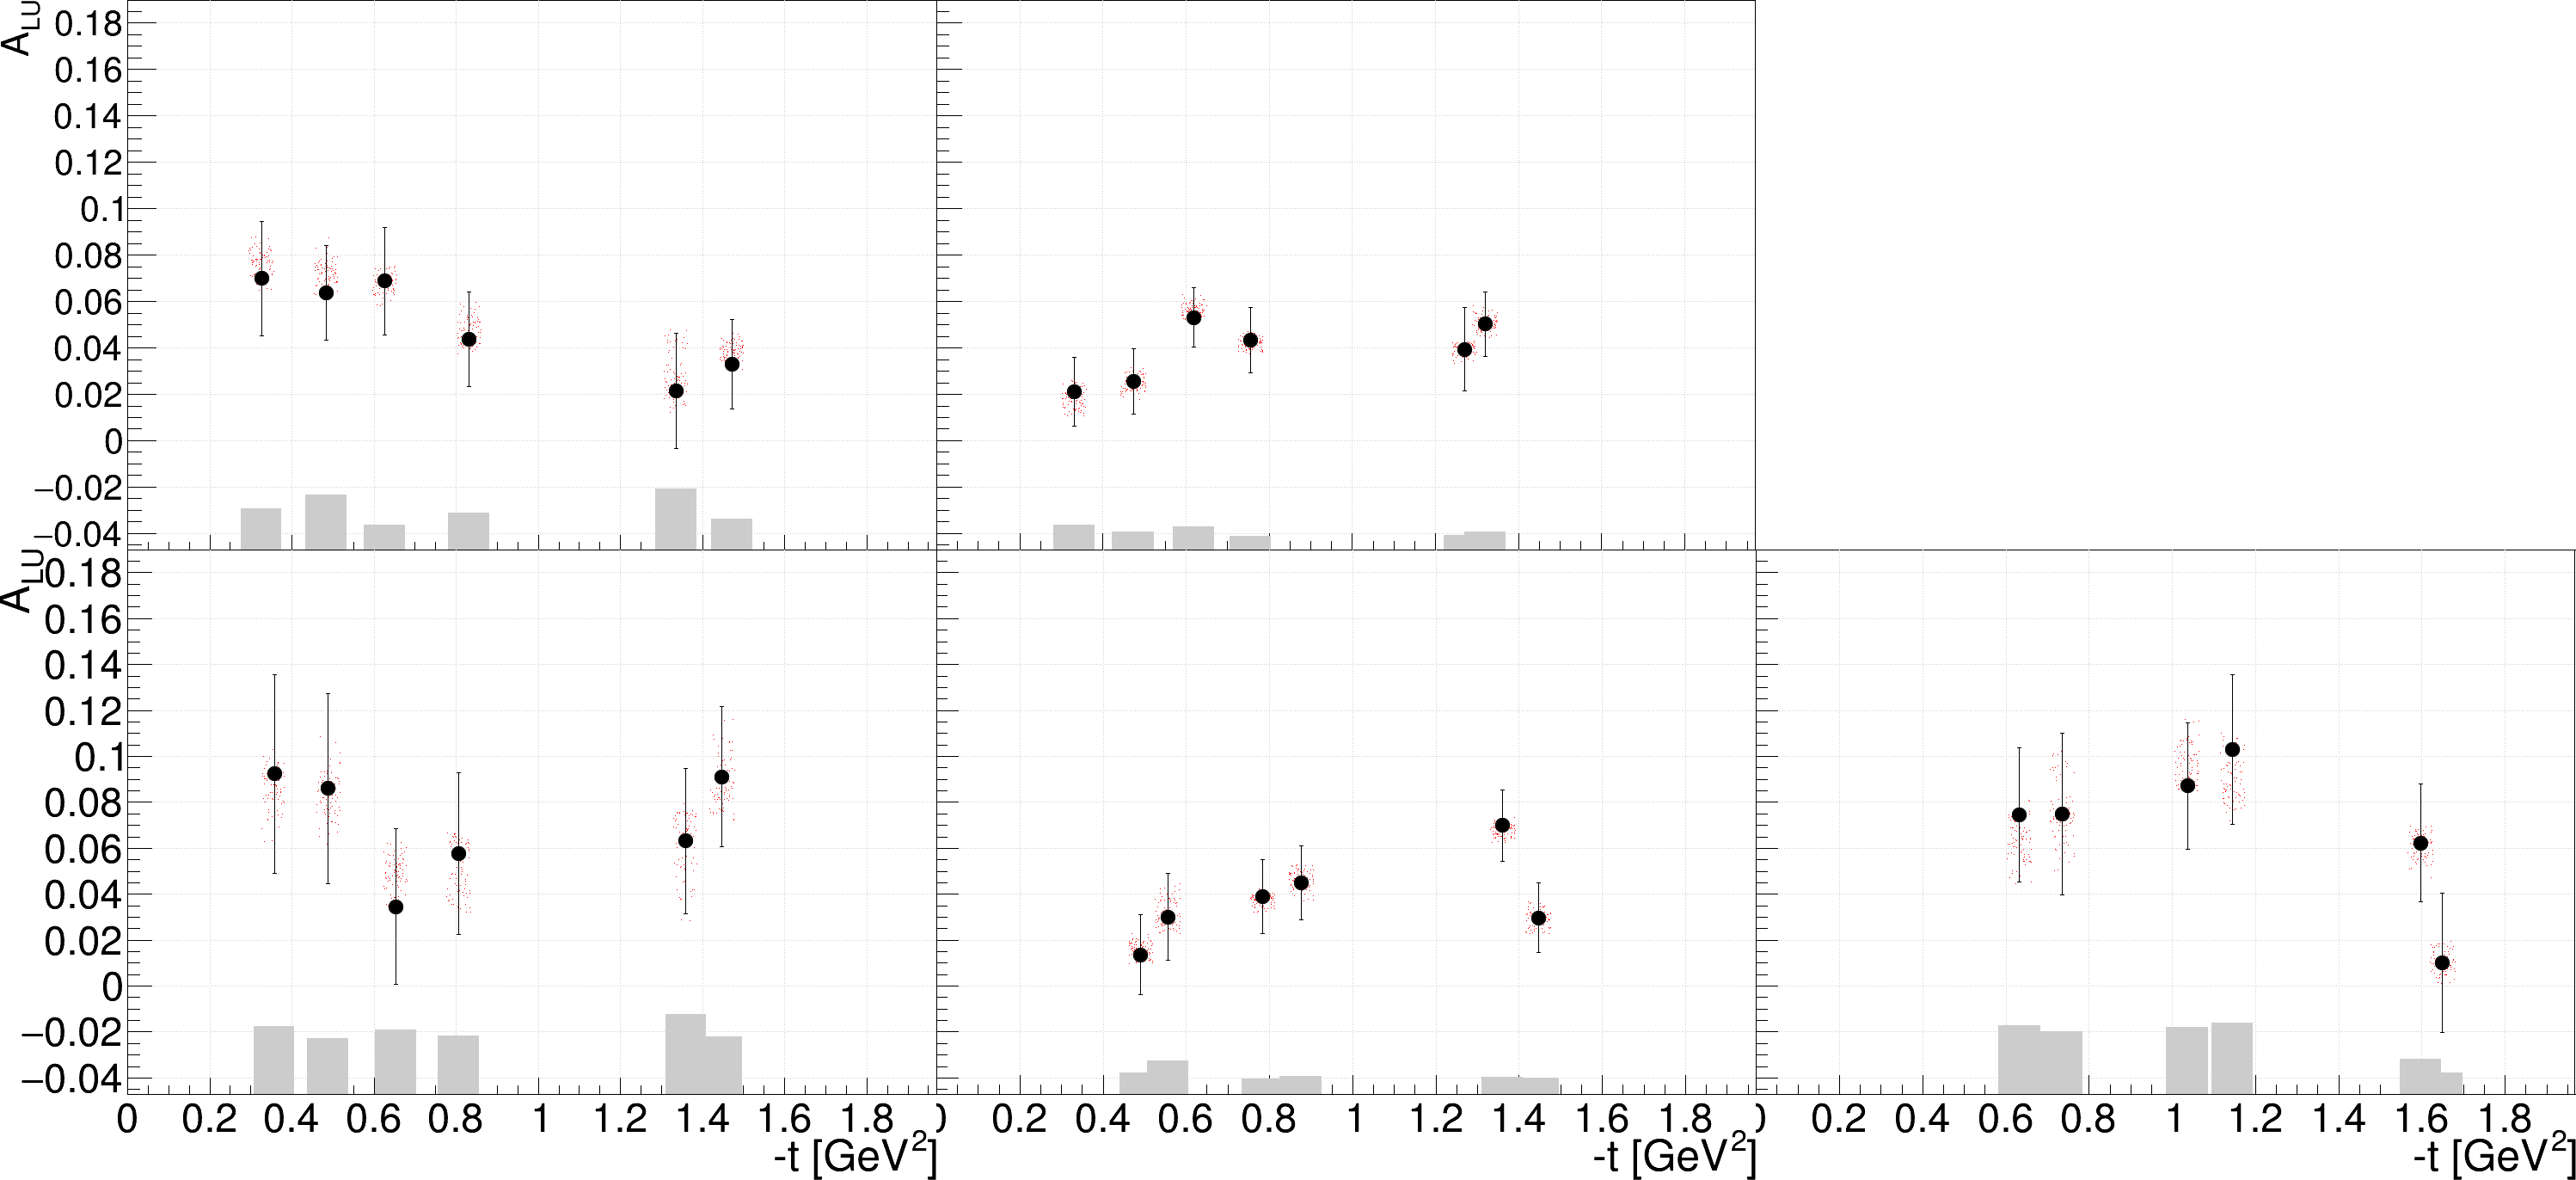

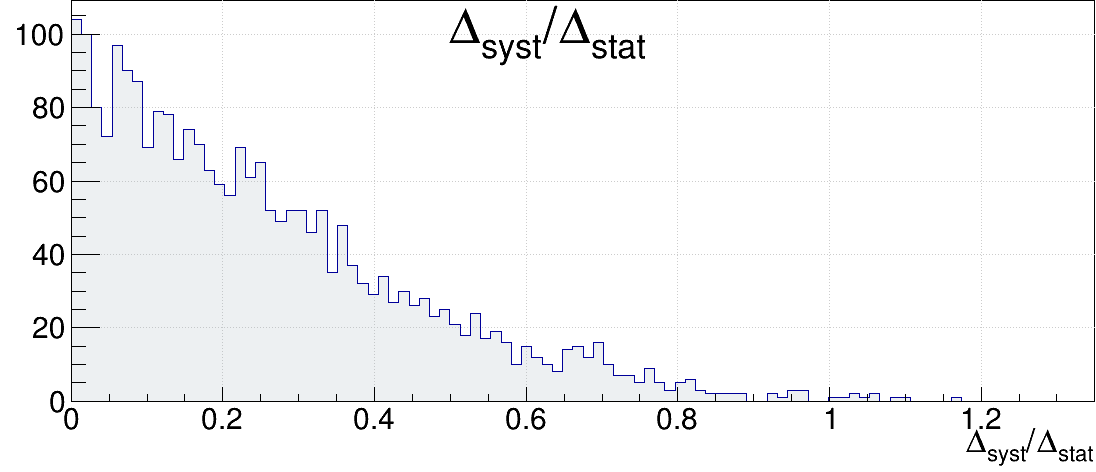

In [10]:
ROOT.gStyle.SetTitleOffset(0.96, 'Y')
ROOT.gStyle.SetPadLeftMargin(0.12)

httdcuts = ROOT.TH1F("httdcuts","exclusive cuts systematics;#Delta_{syst}",200,0,0.052)
hdsys = ROOT.TH1F("hdsys","#Delta_{syst}/#Delta_{stat};#Delta_{syst}/#Delta_{stat}",100,0,1.35)

idf,idf1,odf,odf1 = rdfs

c1 = ROOT.TCanvas("c1","c1",3000,1400)
c1.Draw()
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,2,0,0)
grs = []
ipad=0
for iqdf in idf.qdfs:
    bid = iqdf.binid
    oqdf = odf.shards[bid]
    
    igrs,ogrs = igrp1s[bid],ogrp1s[bid]

    ipad += 2 if ipad==2 else 1
    if ipad==2: c1.cd(ipad).SetRightMargin(0.001)

    h1 = c1.cd(ipad).DrawFrame(0,-0.047,1.97,0.19)
    h1.SetTitle(";-t [GeV^{2}];A_{LU}");

    gr0, gr1 = iqdf.grp1.Clone(), oqdf.grp1.Clone()
    
    gr0.Draw("P")
    gr1.Draw("P")

    gr0.SetMarkerStyle(20)
    gr1.SetMarkerStyle(20)

    idys = {i:[gr0.GetPointX(i), gr0.GetPointY(i), gr0.GetErrorY(i), 0] for i in range(gr0.GetN())}
    for igr in igrs:
        igr = igr.Clone()
        igr.SetMarkerColor(2)
        xshift(igr,random.uniform(-0.03,0.03)).Draw("PX")
        for i in range(igr.GetN()):
            dy = abs(idys[i][1]-igr.GetPointY(i))
            idys[i][3] = max(dy, idys[i][3])
            hdsys.Fill(dy/idys[i][2])

    odys = {i:[gr1.GetPointX(i), gr1.GetPointY(i), gr1.GetErrorY(i), 0] for i in range(gr1.GetN())}
    for ogr in ogrs:
        ogr = ogr.Clone()
        ogr.SetMarkerColor(2)
        xshift(ogr,random.uniform(-0.03,0.03)).Draw("PX")
        for i in range(ogr.GetN()):
            dy = abs(odys[i][1]-ogr.GetPointY(i))
            odys[i][3] = max(dy, odys[i][3])
            hdsys.Fill(dy/odys[i][2])
        
    grsys = ROOT.TGraphErrors()
    grsys.SetFillColor(17)
    itt = 0
    for xx,yy,dy,dsys in list(idys.values()):
        httdcuts.Fill(dsys)
        grsys.SetPoint(grsys.GetN(),xx,-0.047)
        grsys.SetPointError(grsys.GetN()-1,0.05,dsys)
        dsysts[(0, bid[0], itt)].append(dsys)
        itt+=1

    itt = 0
    for xx,yy,dy,dsys in list(odys.values()):
        httdcuts.Fill(dsys)
        grsys.SetPoint(grsys.GetN(),xx,-0.047)
        grsys.SetPointError(grsys.GetN()-1,0.05,dsys)
        dsysts[(1, bid[0], itt)].append(dsys)
        itt += 1

    grsys.Draw("2")
    grs.append(grsys)

    gr0.Draw("P")
    gr1.Draw("P")

c1.Print("pdf/systematics.exclusivecuts.ALU.pdf")



c2 = ROOT.TCanvas("c2","c2",1100,500)
c2.SetMargin(0.065,0.001,0.15,0.001)
c2.Draw()
hdsys.SetFillColorAlpha(33,0.2)
hdsys.Draw()
c2.Print("pdf/systematics.exclusivecuts.ALU.dsys2dstat.pdf")


In [11]:
for kk in dsysts:
    print(kk, len(dsysts[kk]))

(0, 0, 0) 3
(1, 0, 0) 3
(0, 0, 1) 3
(1, 0, 1) 3
(0, 0, 2) 3
(1, 0, 2) 3
(0, 1, 0) 3
(1, 1, 0) 3
(0, 1, 1) 3
(1, 1, 1) 3
(0, 1, 2) 3
(1, 1, 2) 3
(0, 2, 0) 3
(1, 2, 0) 3
(0, 2, 1) 3
(1, 2, 1) 3
(0, 2, 2) 3
(1, 2, 2) 3
(0, 3, 0) 3
(1, 3, 0) 3
(0, 3, 1) 3
(1, 3, 1) 3
(0, 3, 2) 3
(1, 3, 2) 3
(0, 4, 0) 3
(1, 4, 0) 3
(0, 4, 1) 3
(1, 4, 1) 3
(0, 4, 2) 3
(1, 4, 2) 3


------------------------
------------------------

### BSA graphs for each $\{Q^2,x_B,-t\}$ bin

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


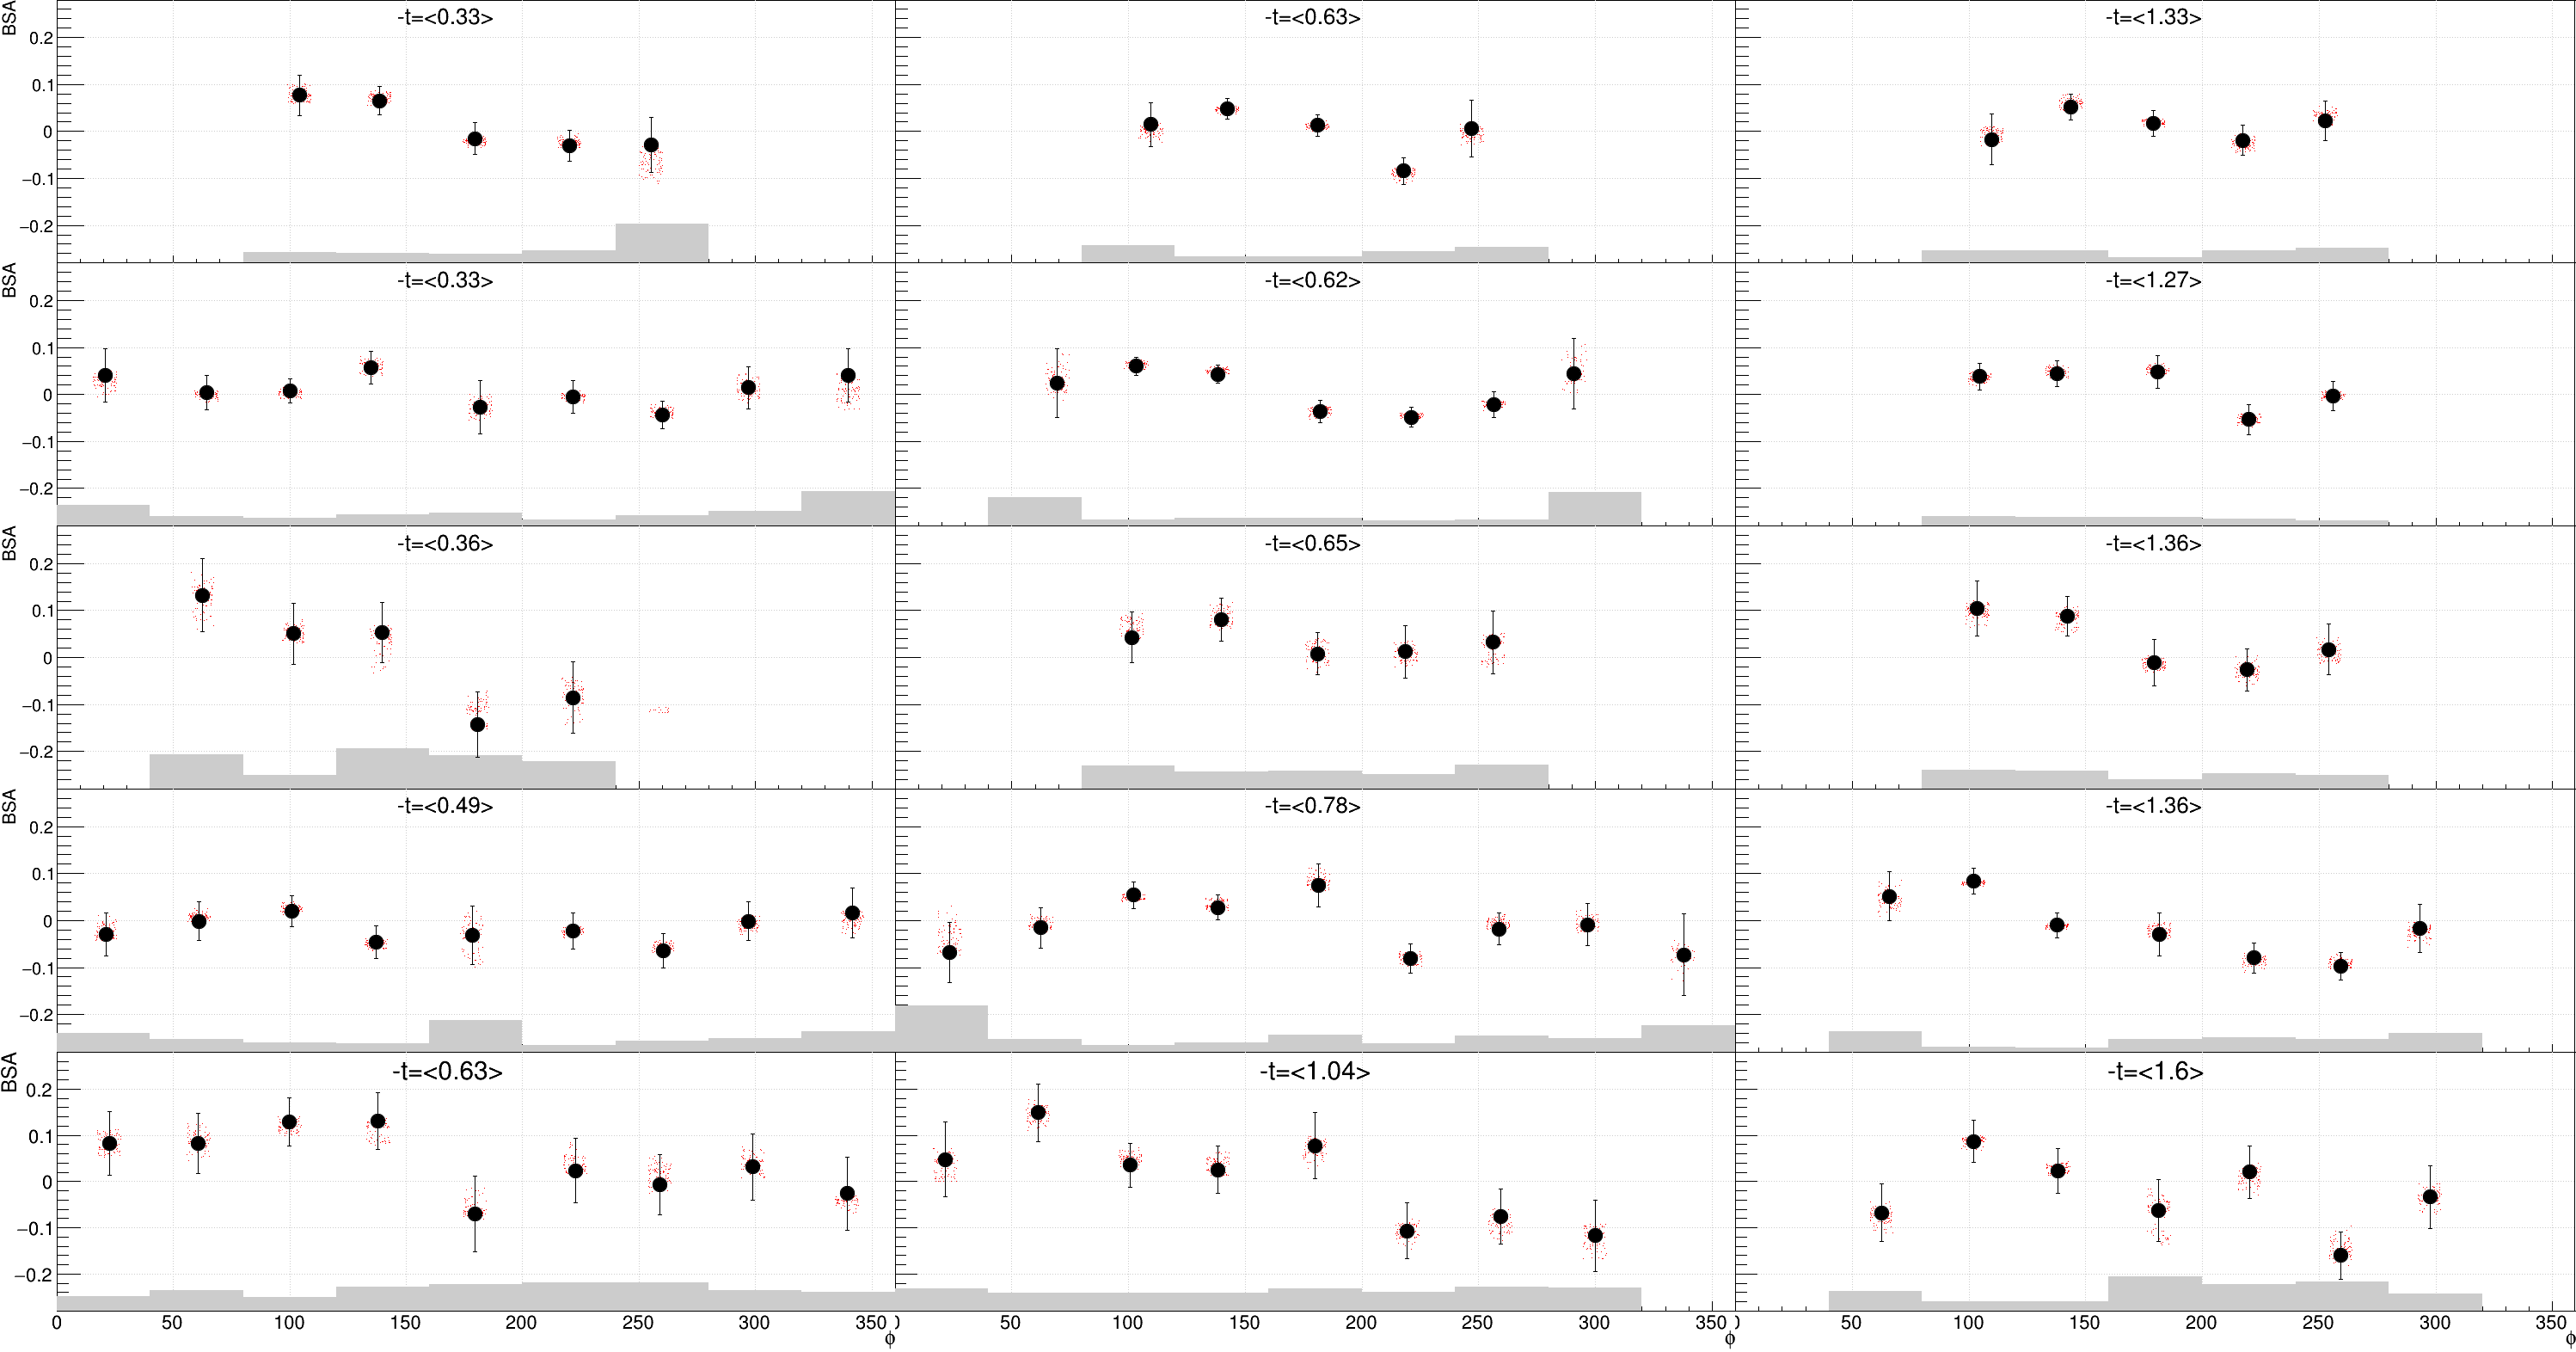

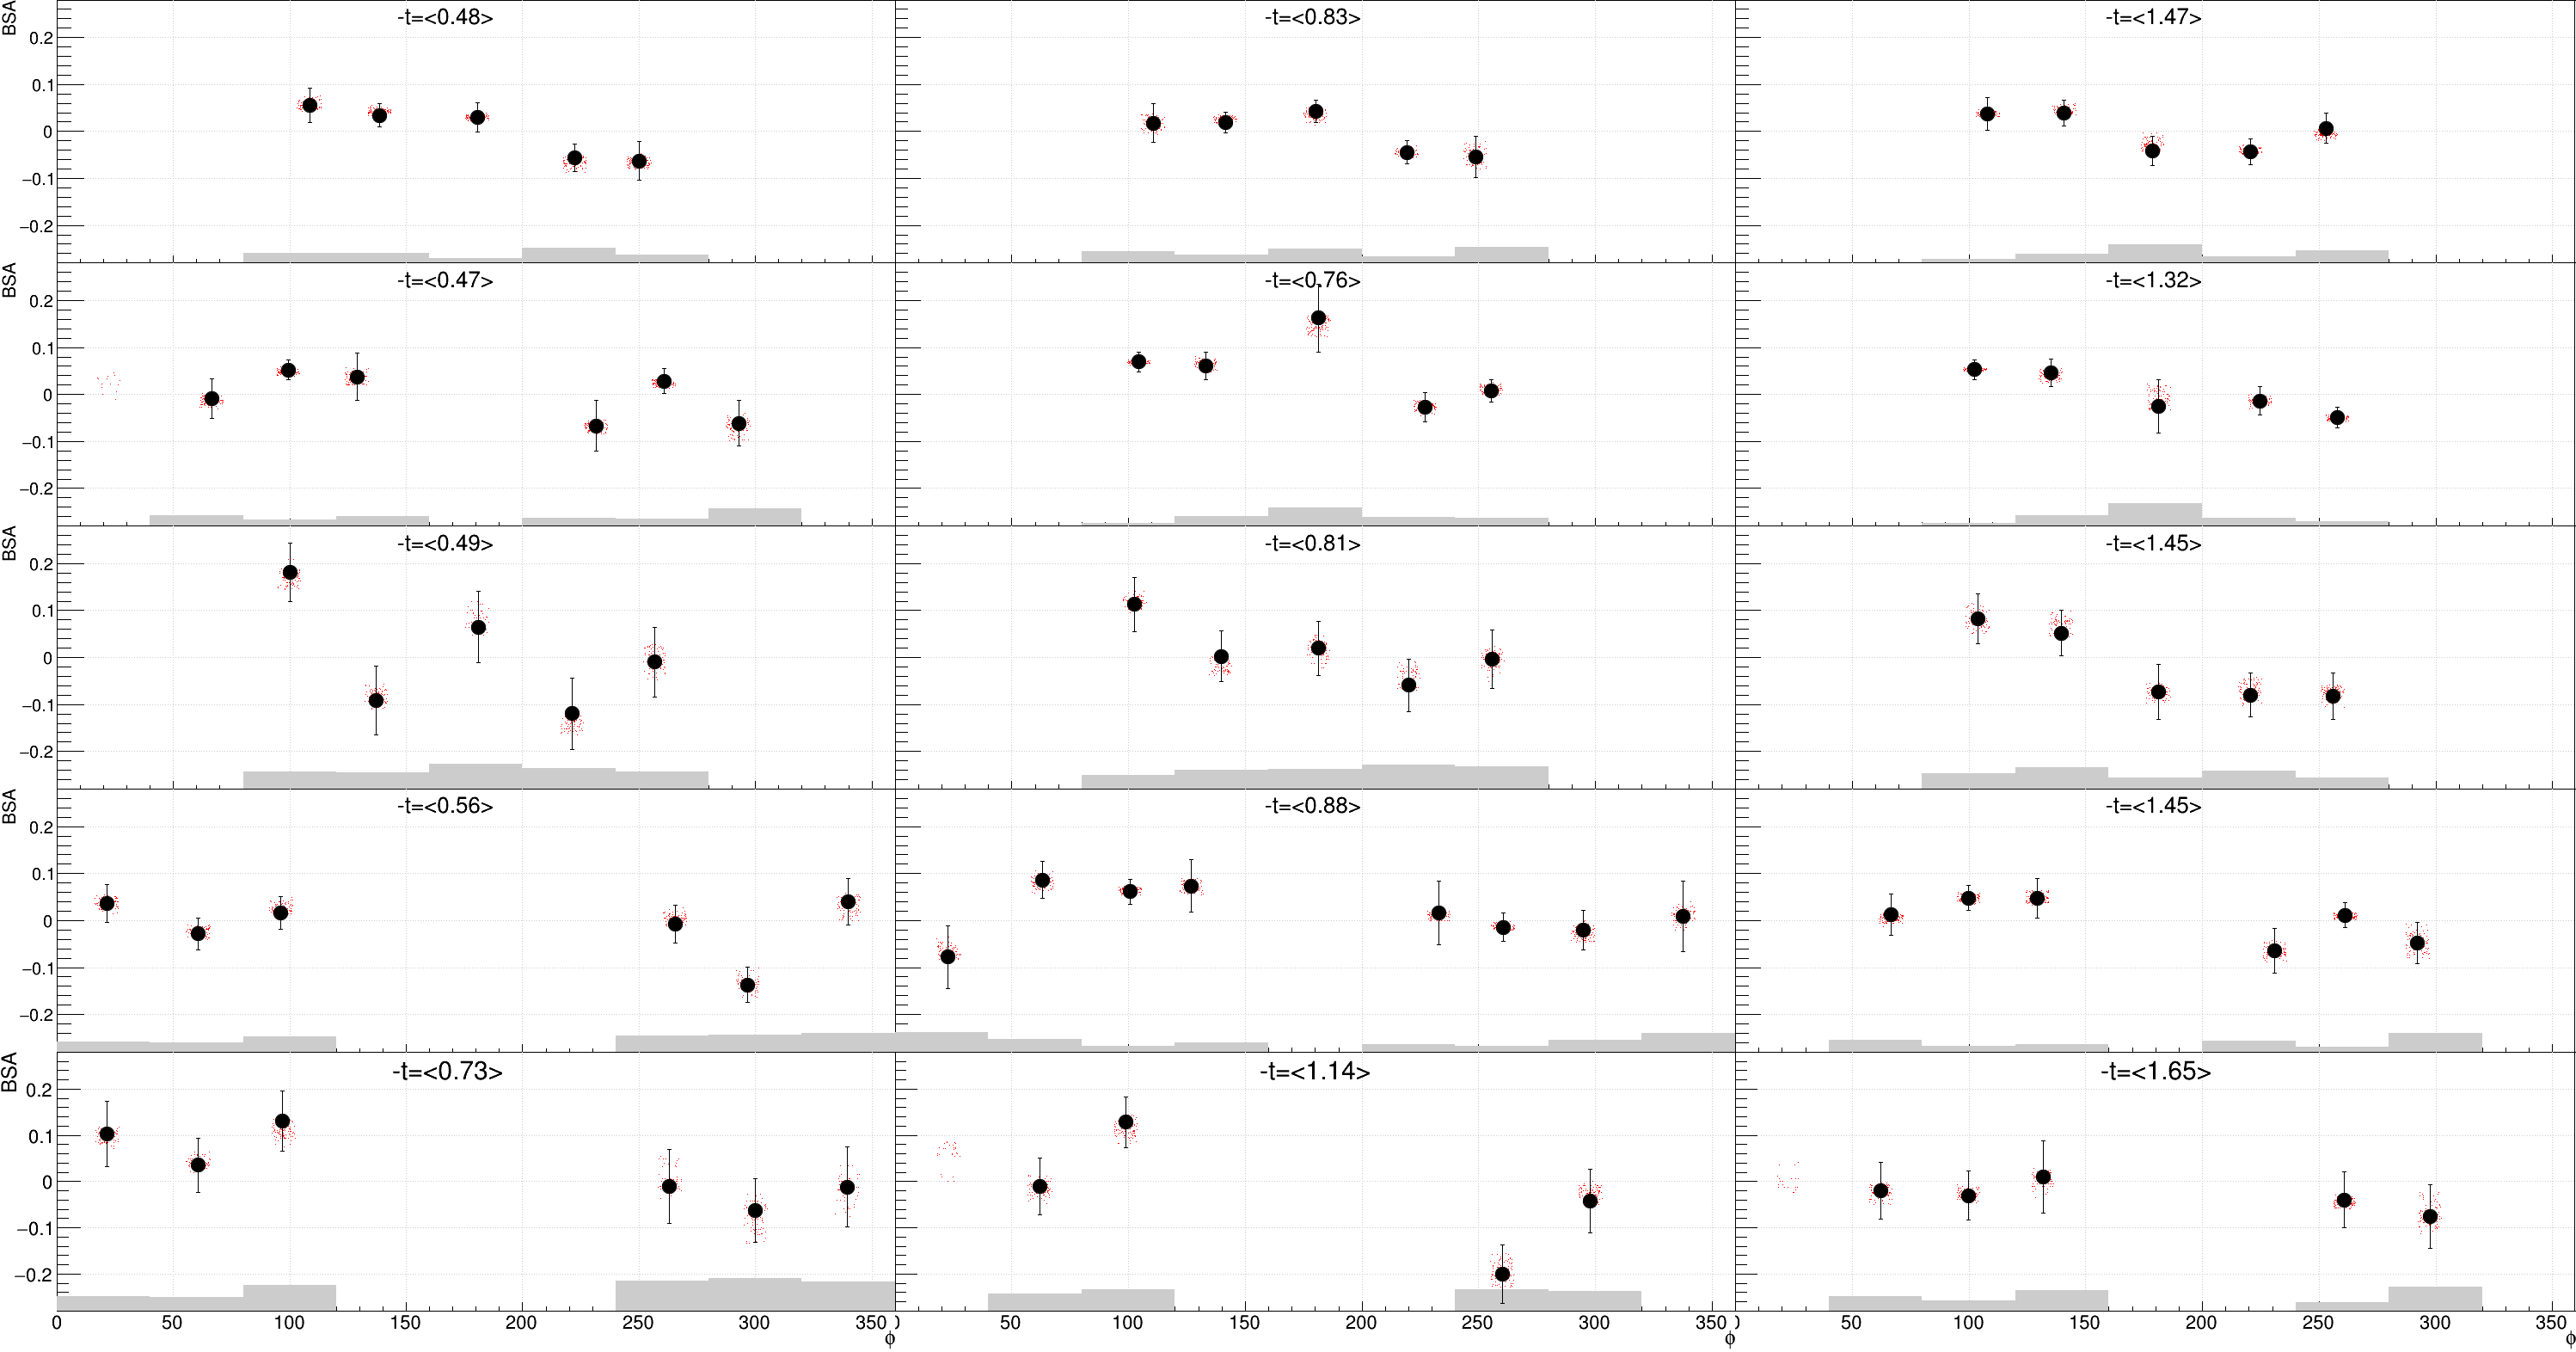

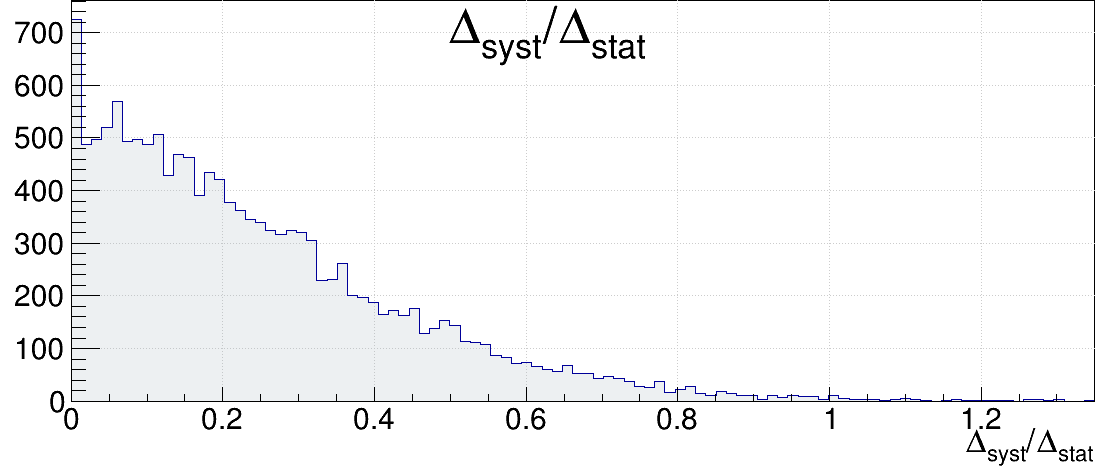

In [12]:
ROOT.gStyle.SetTitleOffset(0.45, 'Y')
ROOT.gStyle.SetPadLeftMargin(0.06)

hfidcuts = ROOT.TH1F("hfidcuts","exclusive cuts systematics;#Delta_{syst}",200,0,0.112)
hdsys = ROOT.TH1F("hdsys","#Delta_{syst}/#Delta_{stat};#Delta_{syst}/#Delta_{stat}",100,0,1.35)

idf,idf1,odf,odf1 = rdfs

c1 = ROOT.TCanvas("c1","c1",3000,1600)
c1.Draw()
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,5,0,0)
grs = []
ipad=0
for qdf in idf.qdfs:
    for tdf in qdf.tdfs:
        ipad+=1
        bid = tdf.binid

        h1 = c1.cd(ipad).DrawFrame(0,-0.28,360,0.28)
        h1.SetTitle(f"-t=<{round(tdf.tt,2)}>;#phi;BSA")
        
        gr0 = tdf.grbsa.Clone()
        gr0.Draw("P")
        gr0.SetMarkerStyle(20)

        xbins = range(0,361,40)
        errs = {numpy.digitize(gr0.GetPointX(i),xbins): [gr0.GetPointY(i), gr0.GetErrorY(i), 0] for i in range(gr0.GetN())}
        for igr in igrbsas[bid]:
            igr = igr.Clone()
            igr.SetMarkerColor(2)
            xshift(igr,random.uniform(-5,5)).Draw("XP")
            for ii in range(igr.GetN()):
                x1,y1 = igr.GetPointX(ii),igr.GetPointY(ii)
                ib = numpy.digitize(x1,xbins)
                if ib in errs:
                    y0 = errs[ib][0]
                    errs[ib][2] = max(abs(y0-y1), errs[ib][2])
                    hdsys.Fill(abs(y0-y1)/errs[ib][1])
                    
        grsys = ROOT.TGraphErrors()
        grsys.SetFillColor(17)
        for ib in errs:
            hfidcuts.Fill(errs[ib][2])
            grsys.SetPoint(grsys.GetN(), (xbins[ib-1]+xbins[ib])/2, -0.28)
            grsys.SetPointError(grsys.GetN()-1, (xbins[ib]-xbins[ib-1])/2, errs[ib][2])
        grsys.Draw('L2')
        grs.append(grsys)

        gr0.Draw("P")
c1.Print("pdf/systematics.exclusivecuts.BSA.inb.pdf")

c2 = ROOT.TCanvas("c2","c2",3000,1600)
c2.Draw()
c2.SetTopMargin(0)
c2.SetRightMargin(0)
c2.Divide(3,5,0,0)
ipad=0
for qdf in odf.qdfs:
    for tdf in qdf.tdfs:
        ipad+=1
        bid = tdf.binid

        h1 = c2.cd(ipad).DrawFrame(0,-0.28,360,0.28)
        h1.SetTitle(f"-t=<{round(tdf.tt,2)}>;#phi;BSA")
        
        gr0 = tdf.grbsa.Clone()
        gr0.Draw("P")
        gr0.SetMarkerStyle(20)

        xbins = range(0,361,40)
        errs = {numpy.digitize(gr0.GetPointX(i),xbins): [gr0.GetPointY(i), gr0.GetErrorY(i), 0] for i in range(gr0.GetN())}
        for ogr in ogrbsas[bid]:
            ogr = ogr.Clone()
            ogr.SetMarkerColor(2)
            xshift(ogr,random.uniform(-5,5)).Draw("XP")
            for ii in range(ogr.GetN()):
                x1,y1 = ogr.GetPointX(ii),ogr.GetPointY(ii)
                ib = numpy.digitize(x1,xbins)
                if ib in errs:
                    y0 = errs[ib][0]
                    errs[ib][2] = max(abs(y0-y1), errs[ib][2])
                    hdsys.Fill(abs(y0-y1)/errs[ib][1])
                    
        grsys = ROOT.TGraphErrors()
        grsys.SetFillColor(17)
        for ib in errs:
            hfidcuts.Fill(errs[ib][2])
            grsys.SetPoint(grsys.GetN(), (xbins[ib-1]+xbins[ib])/2, -0.28)
            grsys.SetPointError(grsys.GetN()-1, (xbins[ib]-xbins[ib-1])/2, errs[ib][2])
        grsys.Draw('L2')
        grs.append(grsys)

        gr0.Draw("P")
c2.Print("pdf/systematics.exclusivecuts.BSA.outb.pdf")



c3 = ROOT.TCanvas("c3","c3",1100,500)
c3.SetMargin(0.065,0.001,0.15,0.001)
c3.Draw()
hdsys.SetFillColorAlpha(33,0.2)
hdsys.Draw()
c3.Print("pdf/systematics.exclusivecuts.BSA.dsys2dstat.pdf")



------------------------
------------------------
------------------------

# Fitting moments
### $A_{LU}$ vs $-t$ for each $\{Q^2,x_B\}$ bin

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


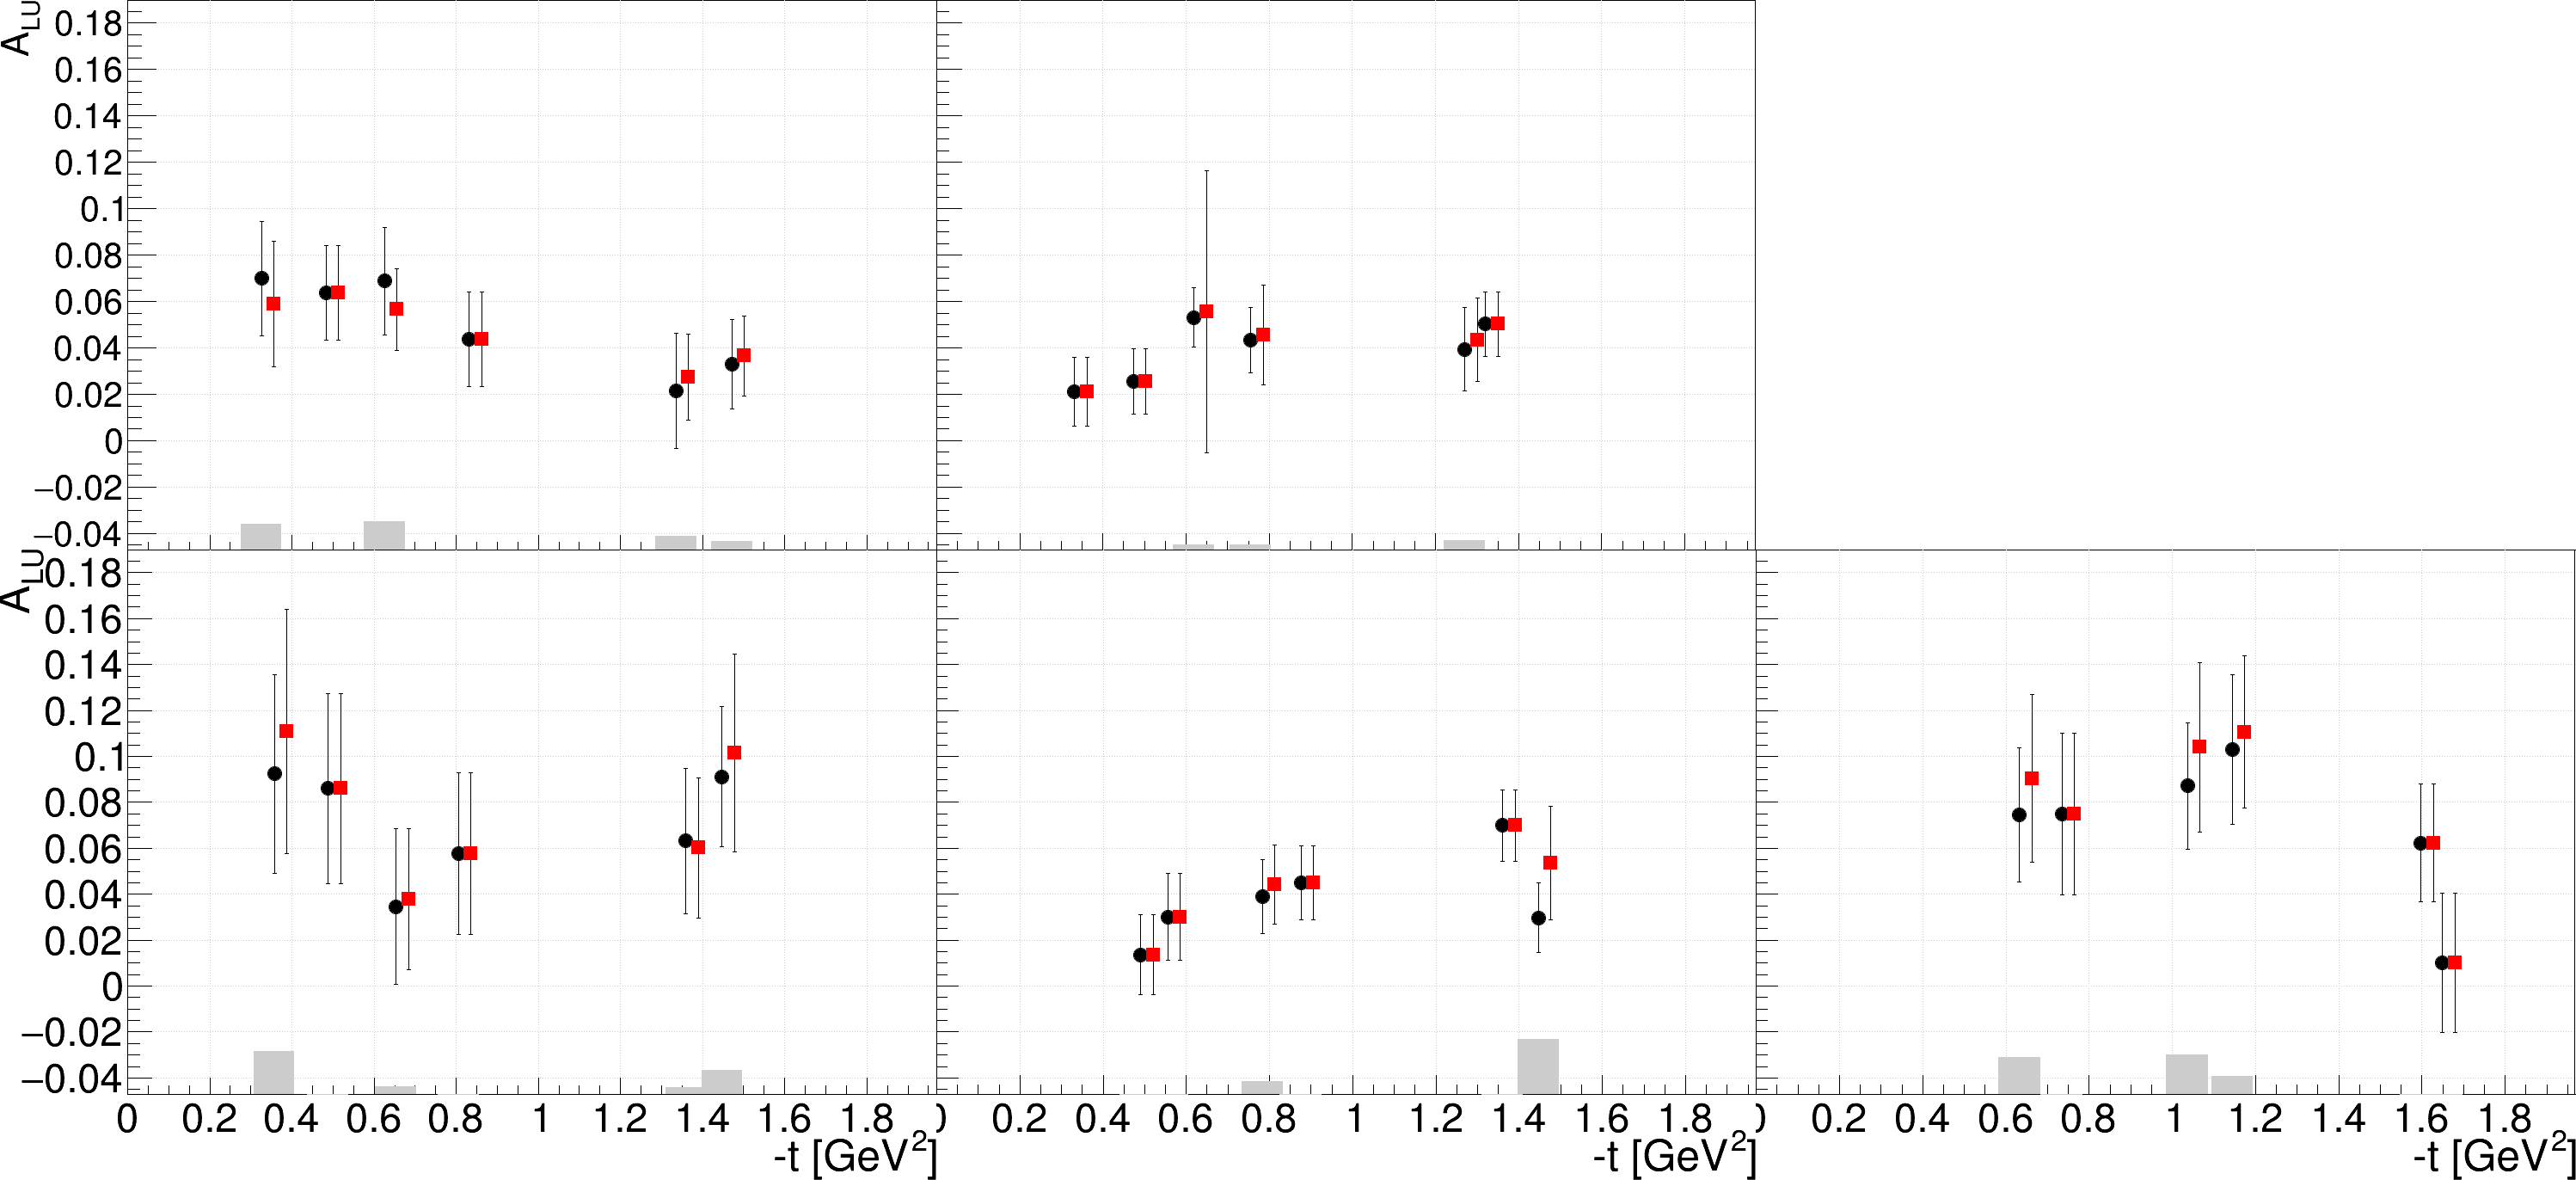

In [13]:
ROOT.gStyle.SetTitleOffset(0.96, 'Y')
ROOT.gStyle.SetPadLeftMargin(0.12)

httdfit = ROOT.TH1F("httdfit","fitting function systematics;#Delta_{syst}",200,0,0.052)

idf,idf1,odf,odf1 = rdfs

c1 = ROOT.TCanvas("c1","c1",3000,1400)
c1.Draw()
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,2,0,0)

grs = []

ipad=0
for iqdf in idf.qdfs:
    bid = iqdf.binid
    oqdf = odf.shards[bid]
    ipad += 2 if ipad==2 else 1
    if ipad==2: c1.cd(ipad).SetRightMargin(0.001)

    h1 = c1.cd(ipad).DrawFrame(0,-0.047,1.97,0.19)
    h1.SetTitle(";-t [GeV^{2}];A_{LU}");

    grsys = ROOT.TGraphErrors()

    gr0, gr1 = iqdf.grp1.Clone(), oqdf.grp1.Clone()
    gr2, gr3 = xshift(iqdf.grp3.Clone(),0.03), xshift(oqdf.grp3.Clone(), 0.03)
    for i in range(3):
        httdfit.Fill(abs(gr0.GetPointY(i)-gr2.GetPointY(i)))
        httdfit.Fill(abs(gr1.GetPointY(i)-gr3.GetPointY(i)))
        
        grsys.SetPoint(grsys.GetN(), gr0.GetPointX(i), -0.047)
        grsys.SetPointError(grsys.GetN()-1, 0.05, abs(gr0.GetPointY(i)-gr2.GetPointY(i)))
        dsysts[(0, bid[0], i)].append(abs(gr0.GetPointY(i)-gr2.GetPointY(i)))

        grsys.SetPoint(grsys.GetN(), gr1.GetPointX(i), -0.047)
        grsys.SetPointError(grsys.GetN()-1, 0.05, abs(gr1.GetPointY(i)-gr3.GetPointY(i)))
        dsysts[(1, bid[0], i)].append(abs(gr1.GetPointY(i)-gr3.GetPointY(i)))


    gr0.Draw("P")
    gr1.Draw("P")

    gr2.Draw("P")
    gr3.Draw("P")

    gr0.SetMarkerStyle(20)
    gr1.SetMarkerStyle(20)
    gr2.SetMarkerStyle(21)
    gr3.SetMarkerStyle(21)
    gr2.SetMarkerColor(2)
    gr3.SetMarkerColor(2)

    grsys.SetFillColor(17)
    grsys.Draw("2")
    grs.append(grsys)

c1.Print("pdf/systematics.moments.ALU.pdf")

In [14]:
for kk in dsysts:
    print(kk, len(dsysts[kk]))

(0, 0, 0) 4
(1, 0, 0) 4
(0, 0, 1) 4
(1, 0, 1) 4
(0, 0, 2) 4
(1, 0, 2) 4
(0, 1, 0) 4
(1, 1, 0) 4
(0, 1, 1) 4
(1, 1, 1) 4
(0, 1, 2) 4
(1, 1, 2) 4
(0, 2, 0) 4
(1, 2, 0) 4
(0, 2, 1) 4
(1, 2, 1) 4
(0, 2, 2) 4
(1, 2, 2) 4
(0, 3, 0) 4
(1, 3, 0) 4
(0, 3, 1) 4
(1, 3, 1) 4
(0, 3, 2) 4
(1, 3, 2) 4
(0, 4, 0) 4
(1, 4, 0) 4
(0, 4, 1) 4
(1, 4, 1) 4
(0, 4, 2) 4
(1, 4, 2) 4


### BSA graphs for each $\{Q^2,x_B,-t\}$ bin

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


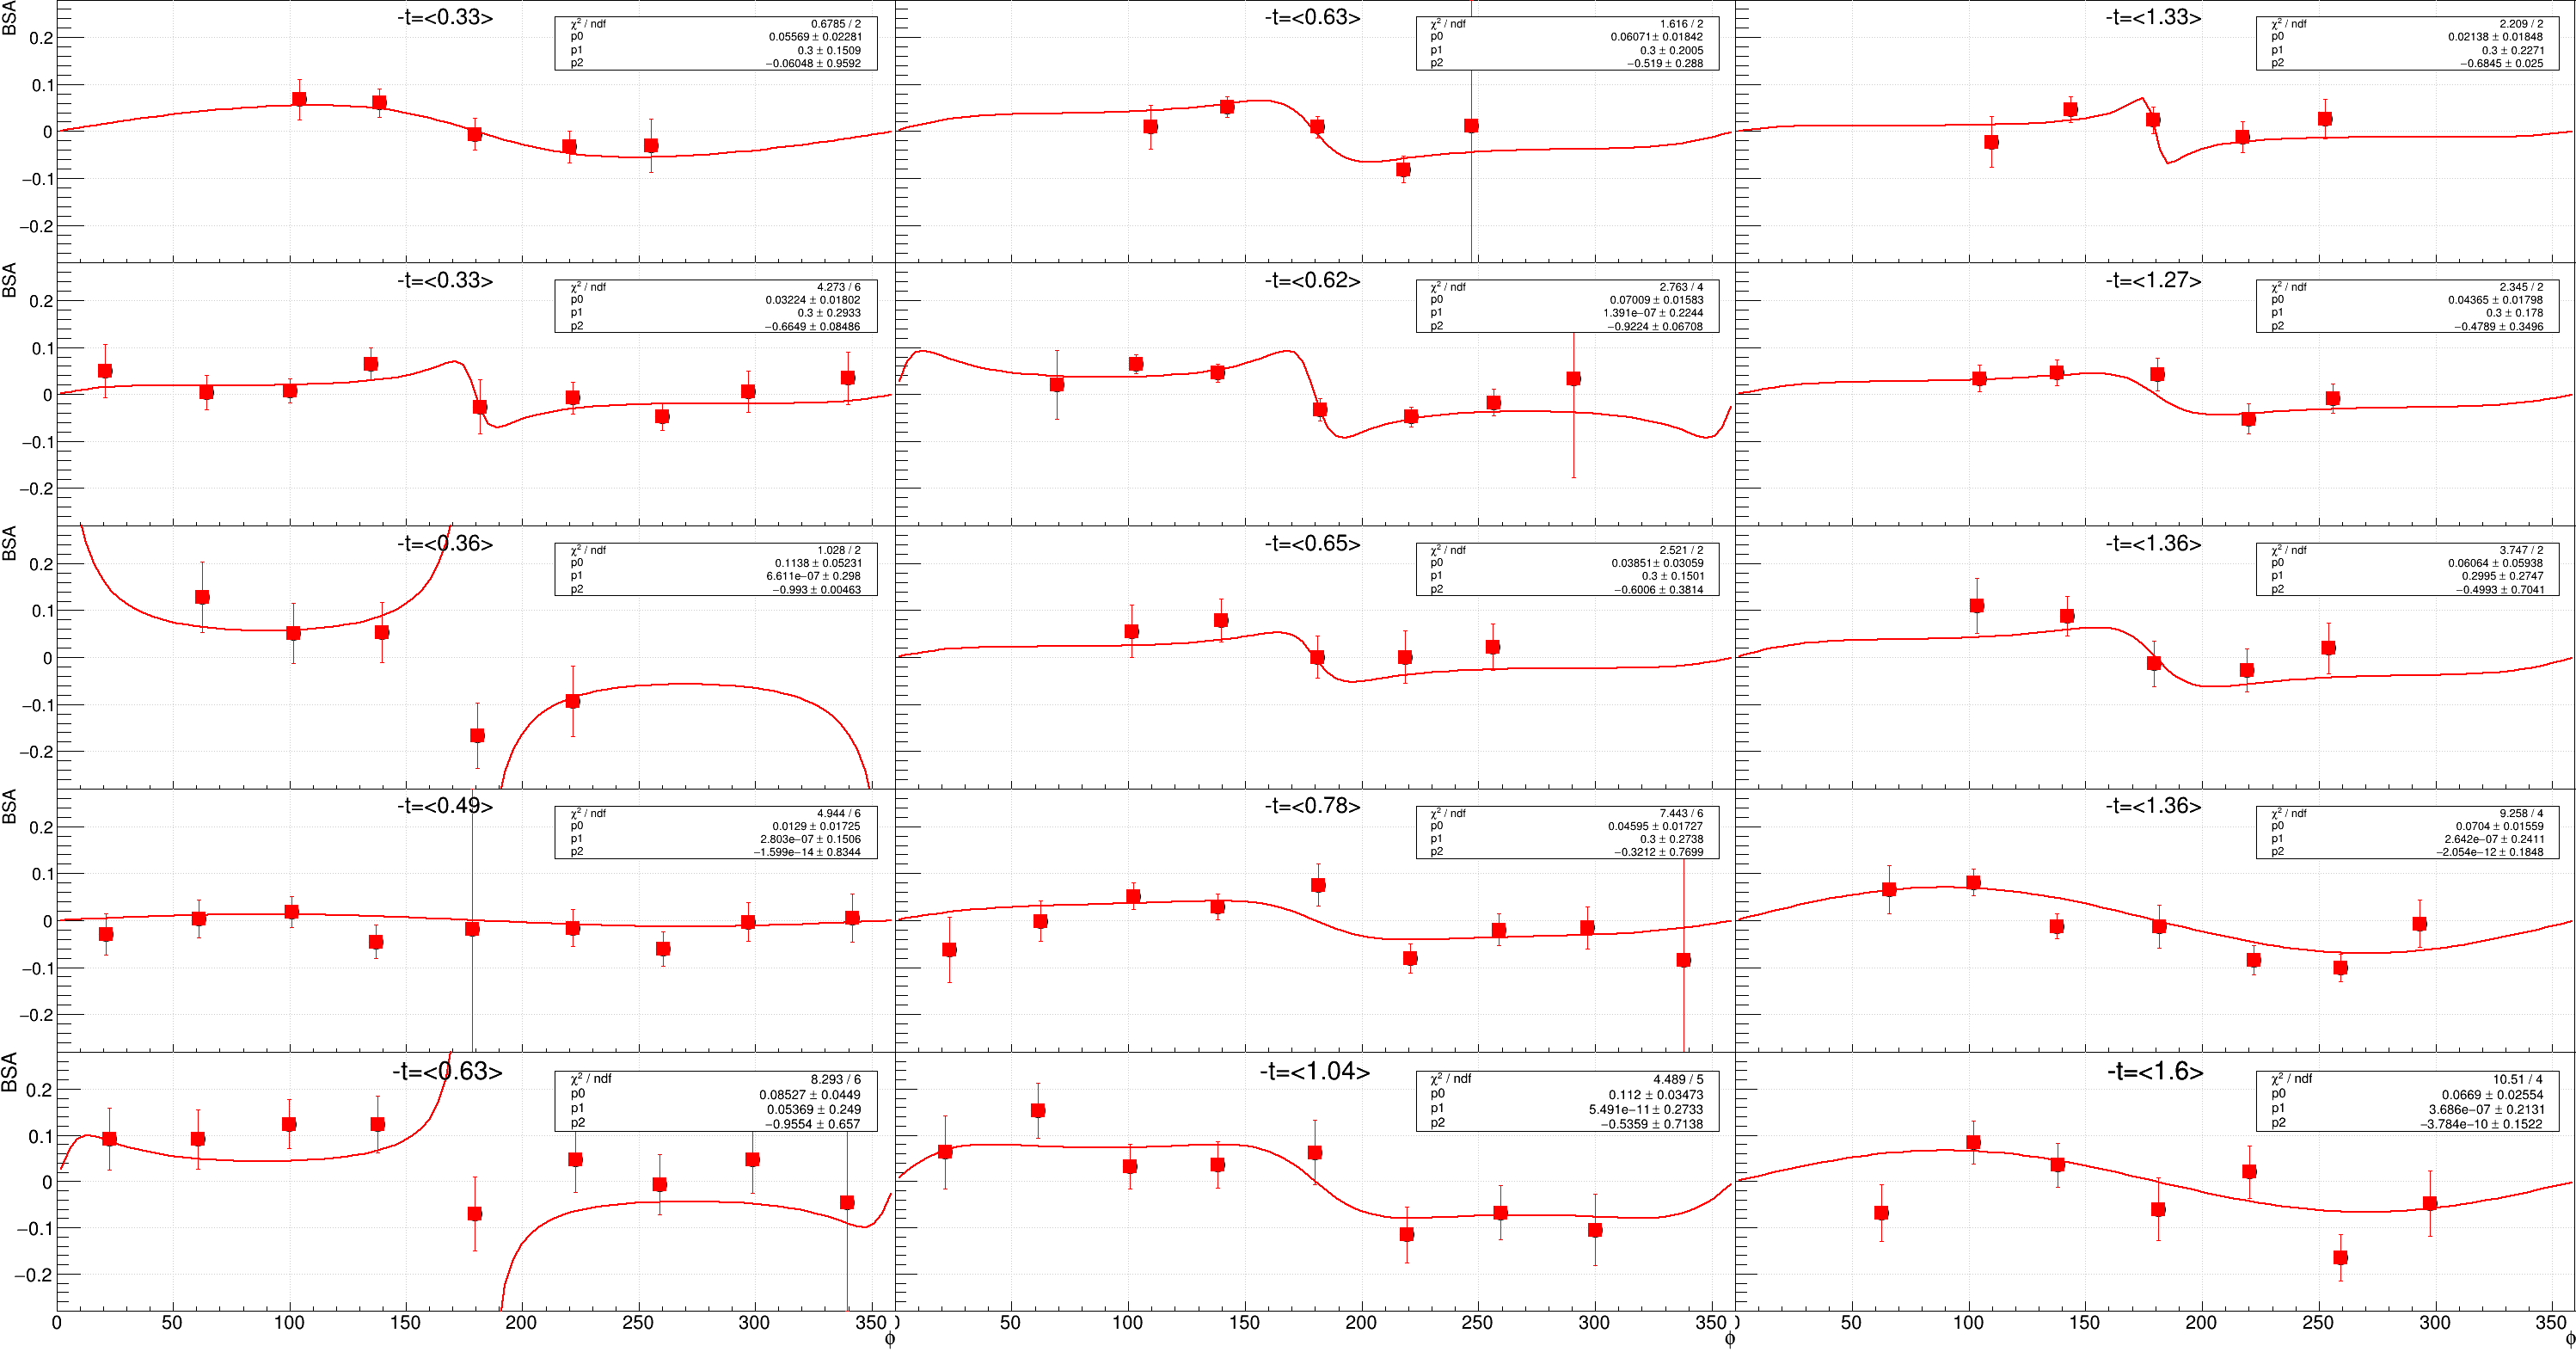

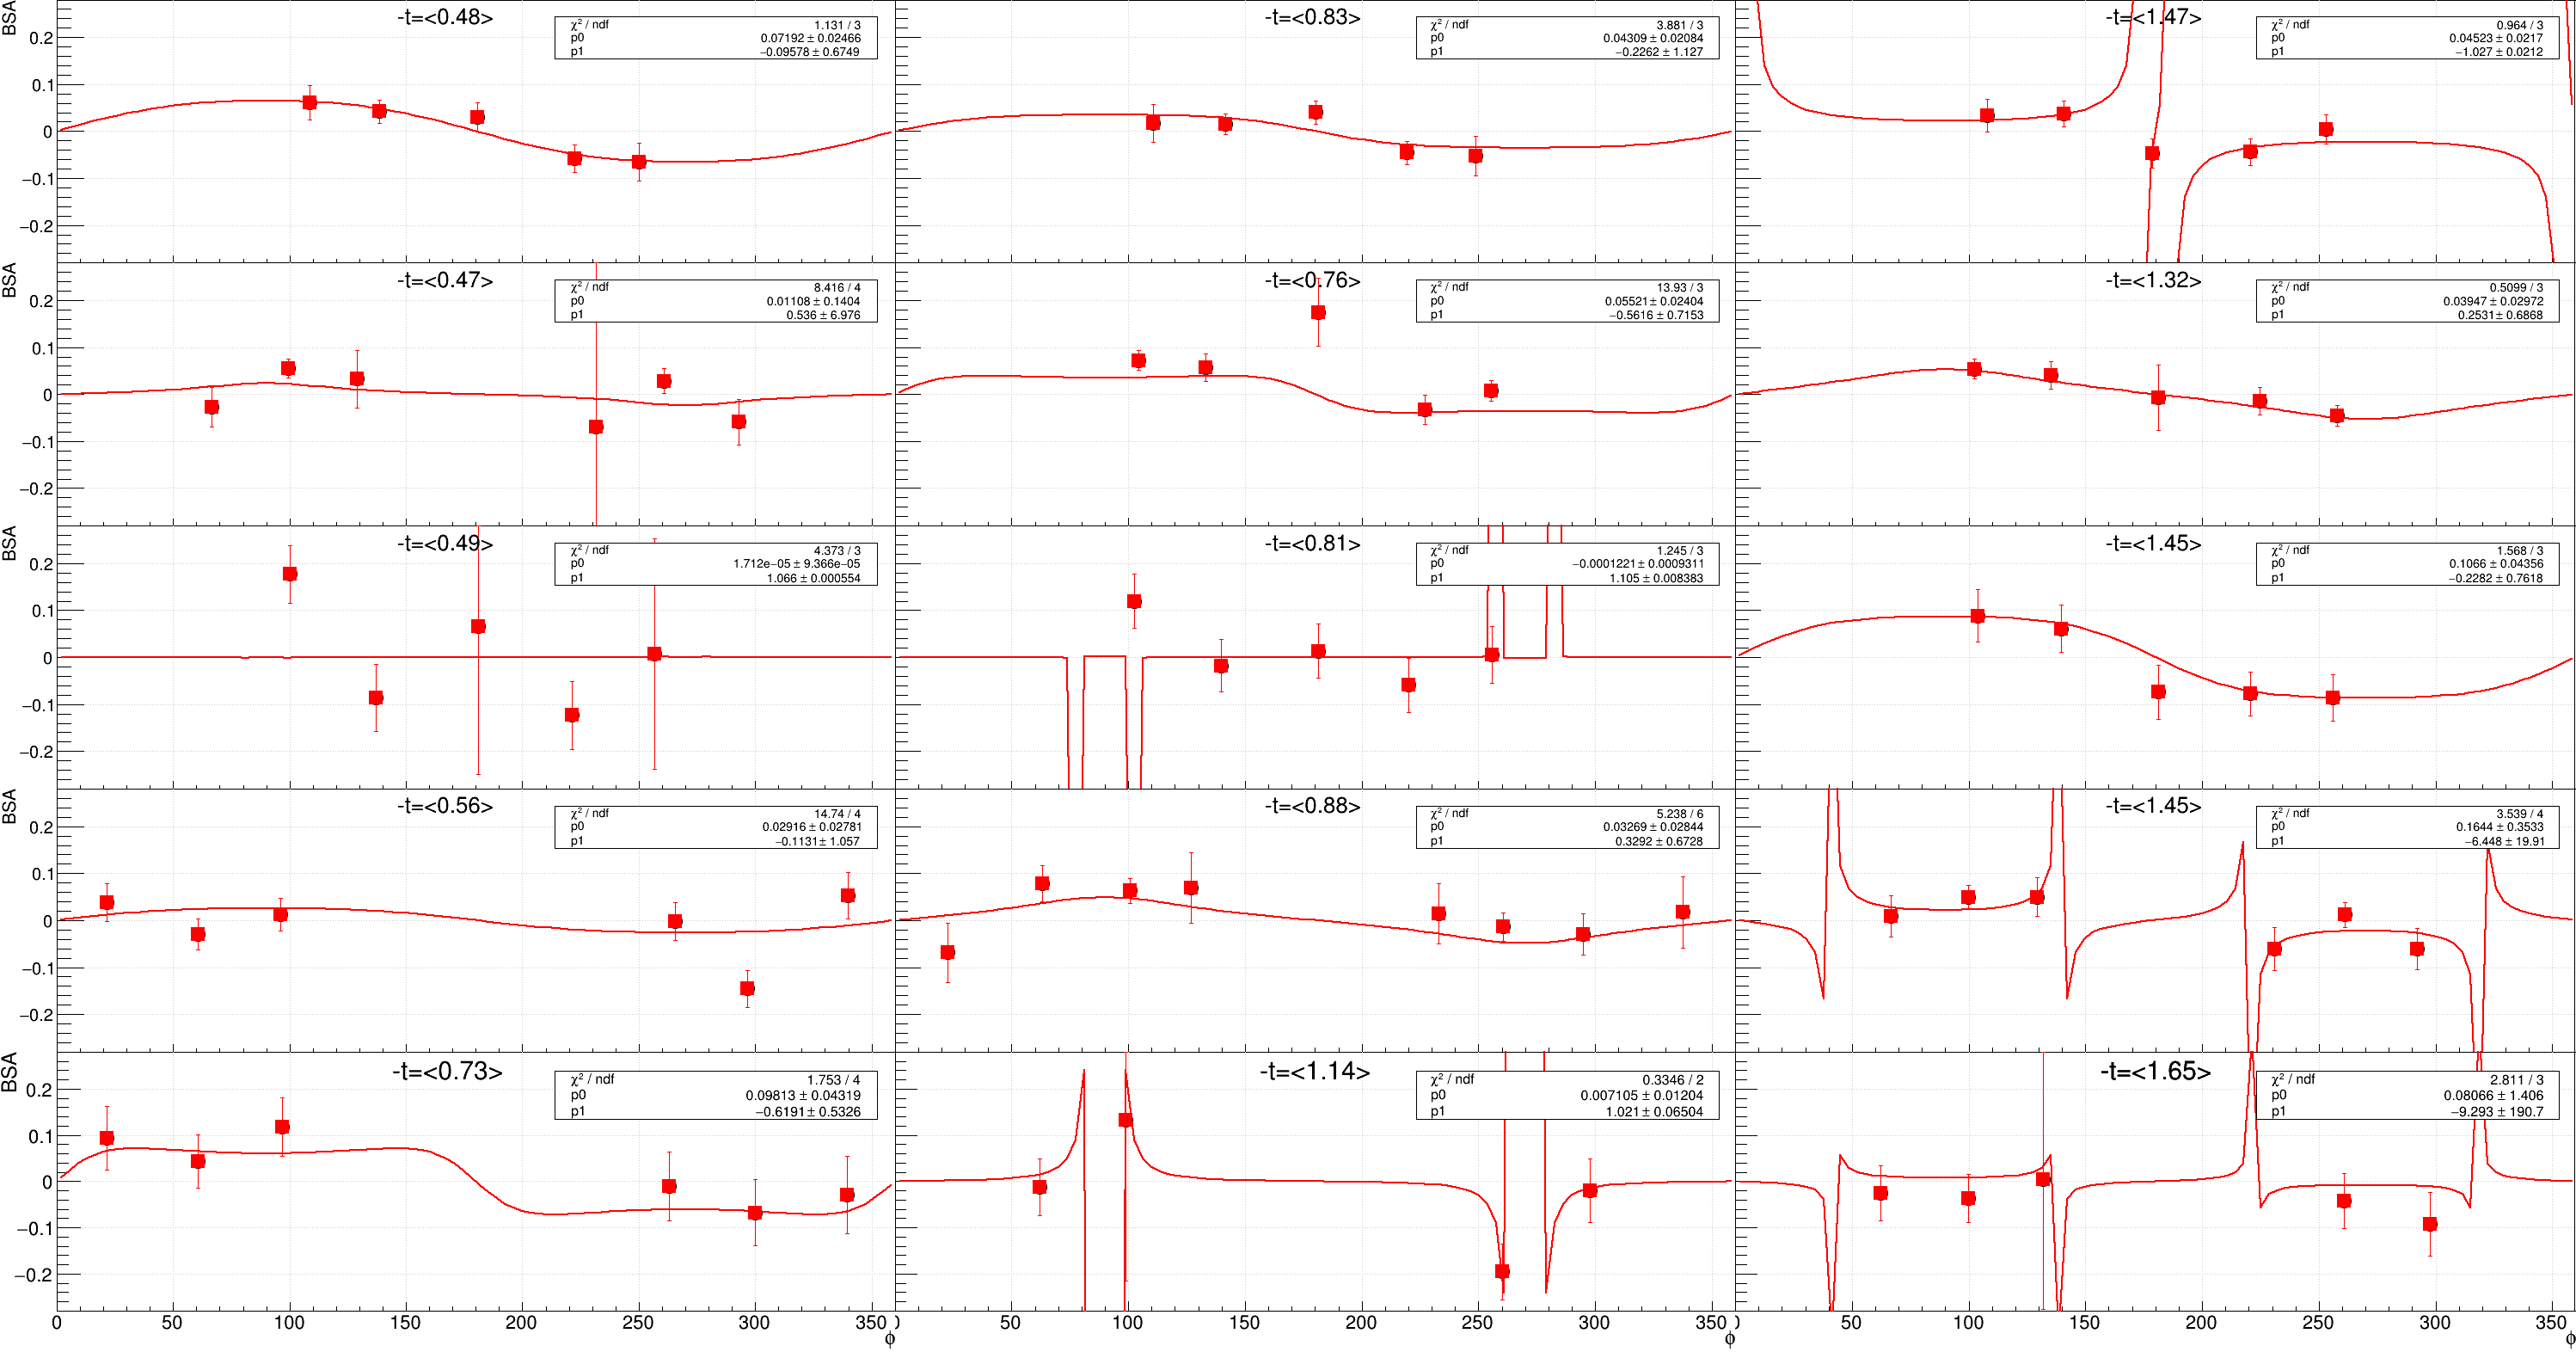

In [15]:
ROOT.gStyle.SetTitleOffset(0.45, 'Y')
ROOT.gStyle.SetPadLeftMargin(0.06)

idf,idf1,odf,odf1 = rdfs

c1 = ROOT.TCanvas("c1","c1",3000,1600)
c1.Draw()
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,5,0,0)

ipad=0
for qdf in idf.qdfs:
    for tdf in qdf.tdfs:
        ipad+=1
        h1 = c1.cd(ipad).DrawFrame(0,-0.28,360,0.28)
        h1.SetTitle(f"-t=<{round(tdf.tt,2)}>;#phi;BSA")
        
        gr0, gr1 = tdf.p3.grbsa.Clone(), xshift(tdf.p3.grbsa.Clone(), 0)
        
        gr0.Draw("P")
        gr1.Draw("P")
        
        gr0.SetMarkerStyle(20)
        gr1.SetMarkerStyle(21)
        gr1.SetMarkerColor(2)
        gr1.SetLineColor(2)

c2 = ROOT.TCanvas("c2","c2",3000,1600)
c2.Draw()
c2.SetTopMargin(0)
c2.SetRightMargin(0)
c2.Divide(3,5,0,0)
ipad=0
for qdf in odf.qdfs:
    for tdf in qdf.tdfs:
        ipad+=1
        h1 = c2.cd(ipad).DrawFrame(0,-0.28,360,0.28)
        h1.SetTitle(f"-t=<{round(tdf.tt,2)}>;#phi;BSA")

        gr0, gr1 = tdf.p3.grbsa.Clone(), xshift(tdf.p3.grbsa.Clone(), 0)

        gr0.Draw("P")
        gr1.Draw("P")
        
        gr0.SetMarkerStyle(20)
        gr1.SetMarkerStyle(21)
        gr1.SetMarkerColor(2)
        gr1.SetLineColor(2)

-----------------------
-----------------------
-----------------------

# Acceptance syst
### $A_{LU}$ vs $-t$ for each $\{Q^2,x_B\}$ bin

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


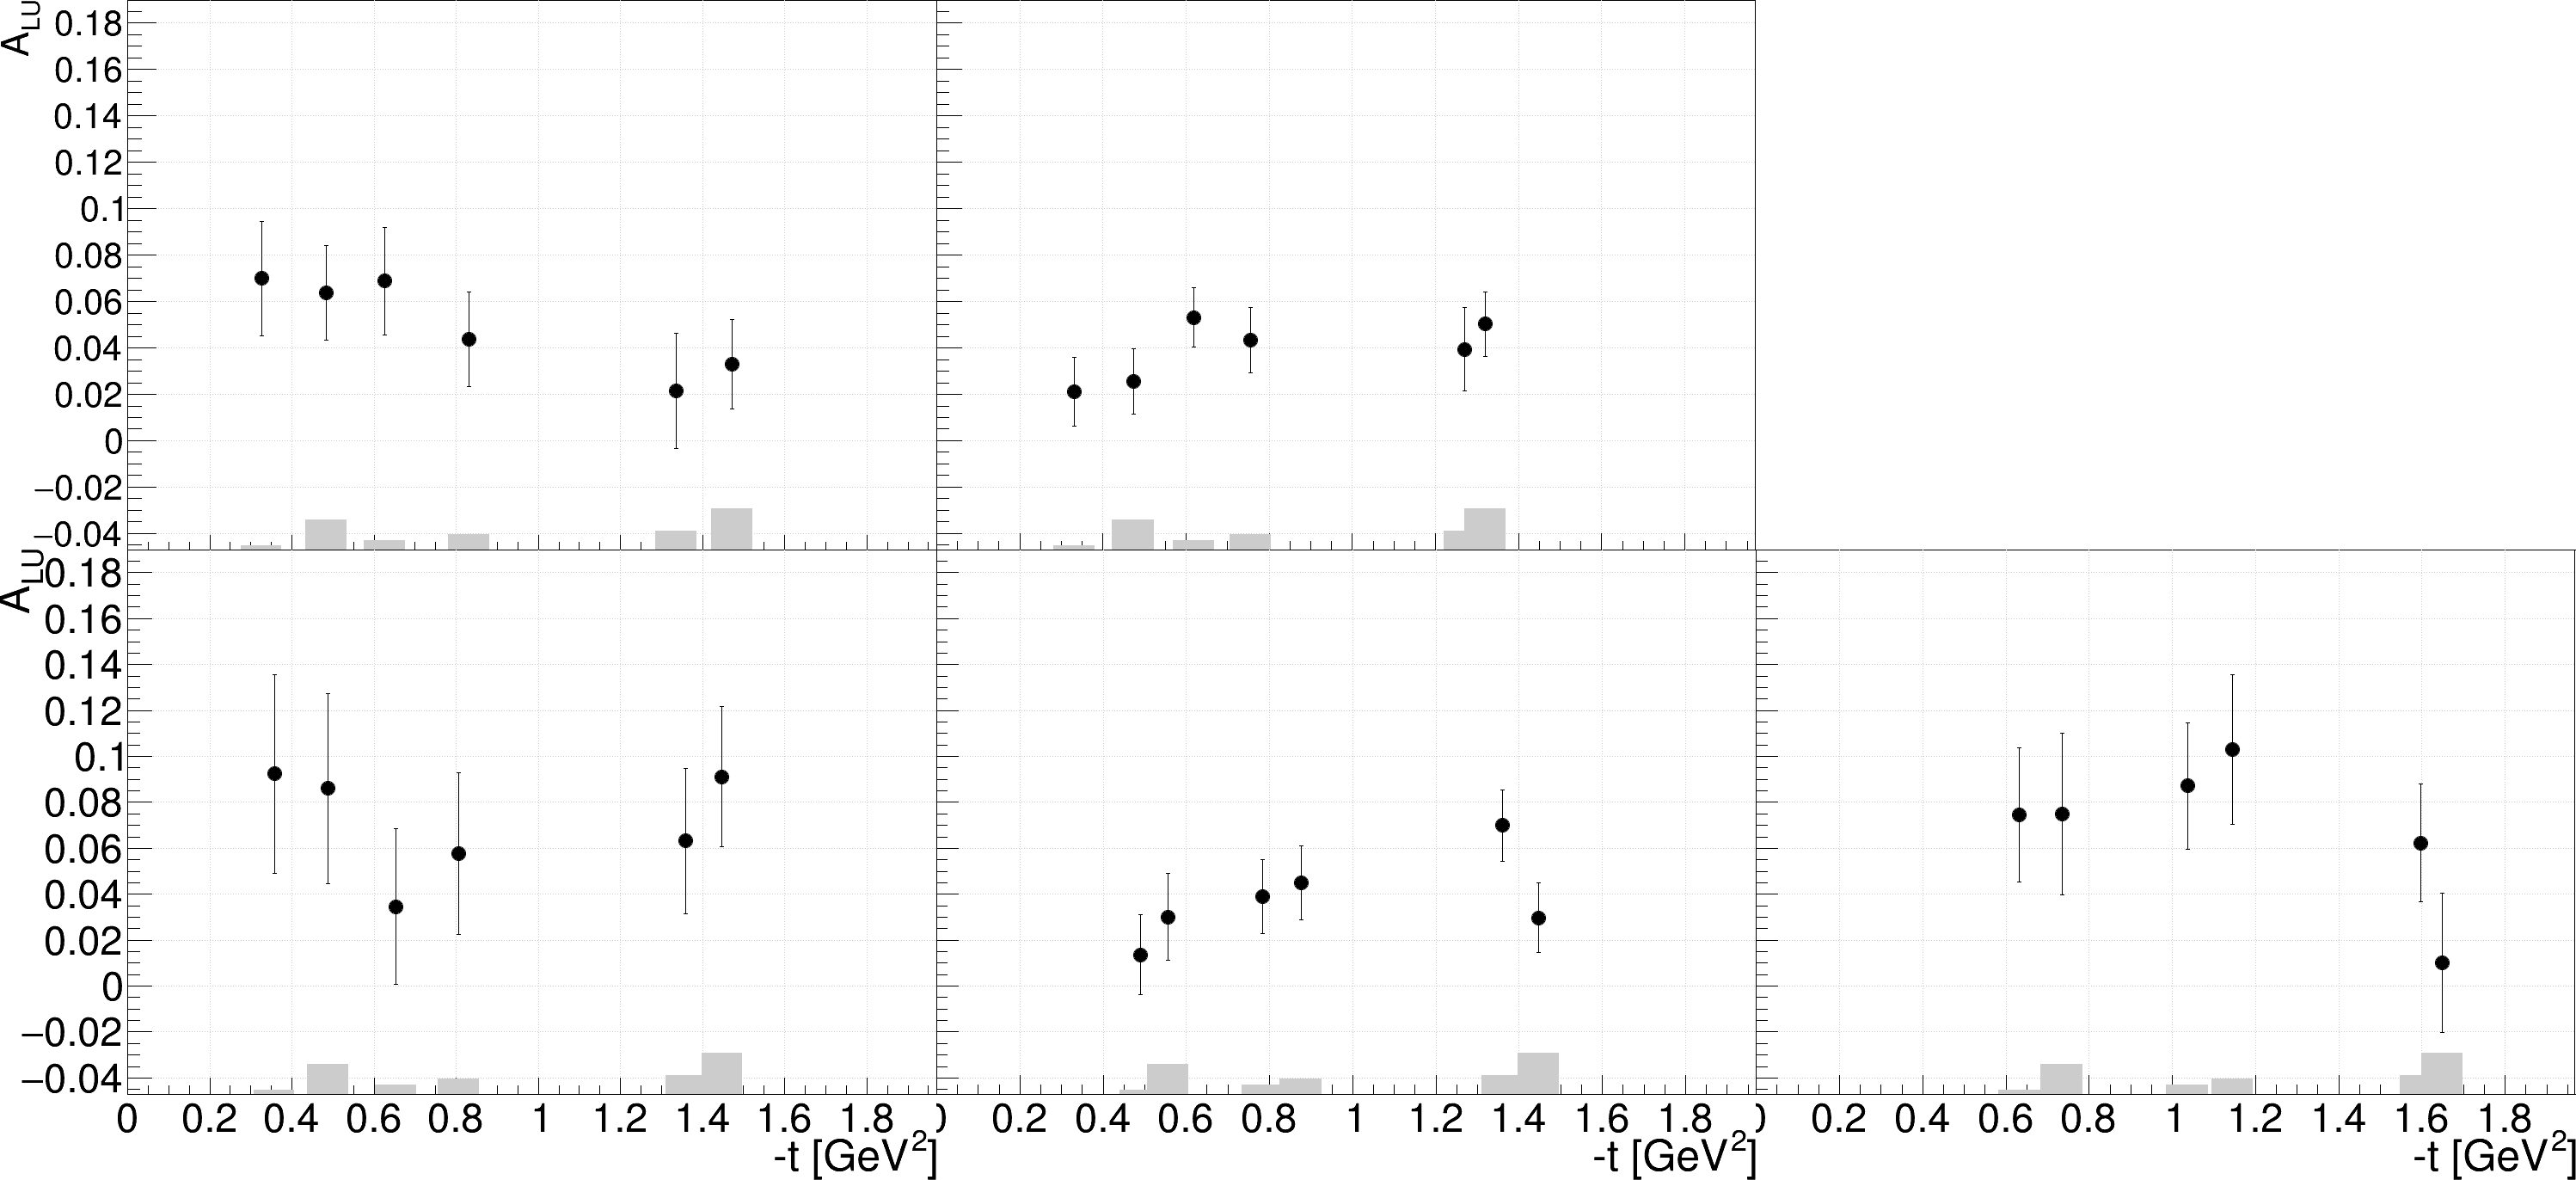

In [16]:
ROOT.gStyle.SetTitleOffset(0.96, 'Y')
ROOT.gStyle.SetPadLeftMargin(0.12)


httdacc = ROOT.TH1F("httdacc","acceptance systematics;#Delta_{syst}",200,0,0.052)
systs = {}
with open("MC_injected_asymmetry.tdep.dat") as ff:
    for line in ff:
        idat,ip,xx,dsys = eval(line)
        systs[(idat,ip)] = dsys
        httdacc.Fill(dsys)


idf,idf1,odf,odf1 = rdfs

c1 = ROOT.TCanvas("c1","c1",3000,1400)
c1.Draw()
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,2,0,0)

grs = []

ipad=0
for iqdf in idf.qdfs:
    bid = iqdf.binid
    oqdf = odf.shards[bid]
    ipad += 2 if ipad==2 else 1
    if ipad==2: c1.cd(ipad).SetRightMargin(0.001)

    h1 = c1.cd(ipad).DrawFrame(0,-0.047,1.97,0.19)
    h1.SetTitle(";-t [GeV^{2}];A_{LU}");

    grsys = ROOT.TGraphErrors()

    gr0, gr1 = iqdf.grp1.Clone(), oqdf.grp1.Clone()
    for i in range(3):
        dsys0, dsys1 = systs[(0,i)], systs[(1,i)]
        grsys.SetPoint(grsys.GetN(), gr0.GetPointX(i), -0.047)
        grsys.SetPointError(grsys.GetN()-1, 0.05, dsys0)
        dsysts[(0, bid[0], i)].append(abs(dsys0))

        grsys.SetPoint(grsys.GetN(), gr1.GetPointX(i), -0.047)
        grsys.SetPointError(grsys.GetN()-1, 0.05, dsys1)
        dsysts[(1, bid[0], i)].append(abs(dsys1))

    gr0.Draw("P")
    gr1.Draw("P")

    gr0.SetMarkerStyle(20)
    gr1.SetMarkerStyle(20)

    grsys.SetFillColor(17)
    grsys.Draw("2")
    grs.append(grsys)

c1.Print("pdf/systematics.moments.ALU.pdf")

In [17]:
for kk in dsysts:
    print(kk, len(dsysts[kk]))

(0, 0, 0) 5
(1, 0, 0) 5
(0, 0, 1) 5
(1, 0, 1) 5
(0, 0, 2) 5
(1, 0, 2) 5
(0, 1, 0) 5
(1, 1, 0) 5
(0, 1, 1) 5
(1, 1, 1) 5
(0, 1, 2) 5
(1, 1, 2) 5
(0, 2, 0) 5
(1, 2, 0) 5
(0, 2, 1) 5
(1, 2, 1) 5
(0, 2, 2) 5
(1, 2, 2) 5
(0, 3, 0) 5
(1, 3, 0) 5
(0, 3, 1) 5
(1, 3, 1) 5
(0, 3, 2) 5
(1, 3, 2) 5
(0, 4, 0) 5
(1, 4, 0) 5
(0, 4, 1) 5
(1, 4, 1) 5
(0, 4, 2) 5
(1, 4, 2) 5


-----------------------
-----------------------
-----------------------

# Bin migration syst
### $A_{LU}$ vs $-t$ for each $\{Q^2,x_B\}$ bin

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


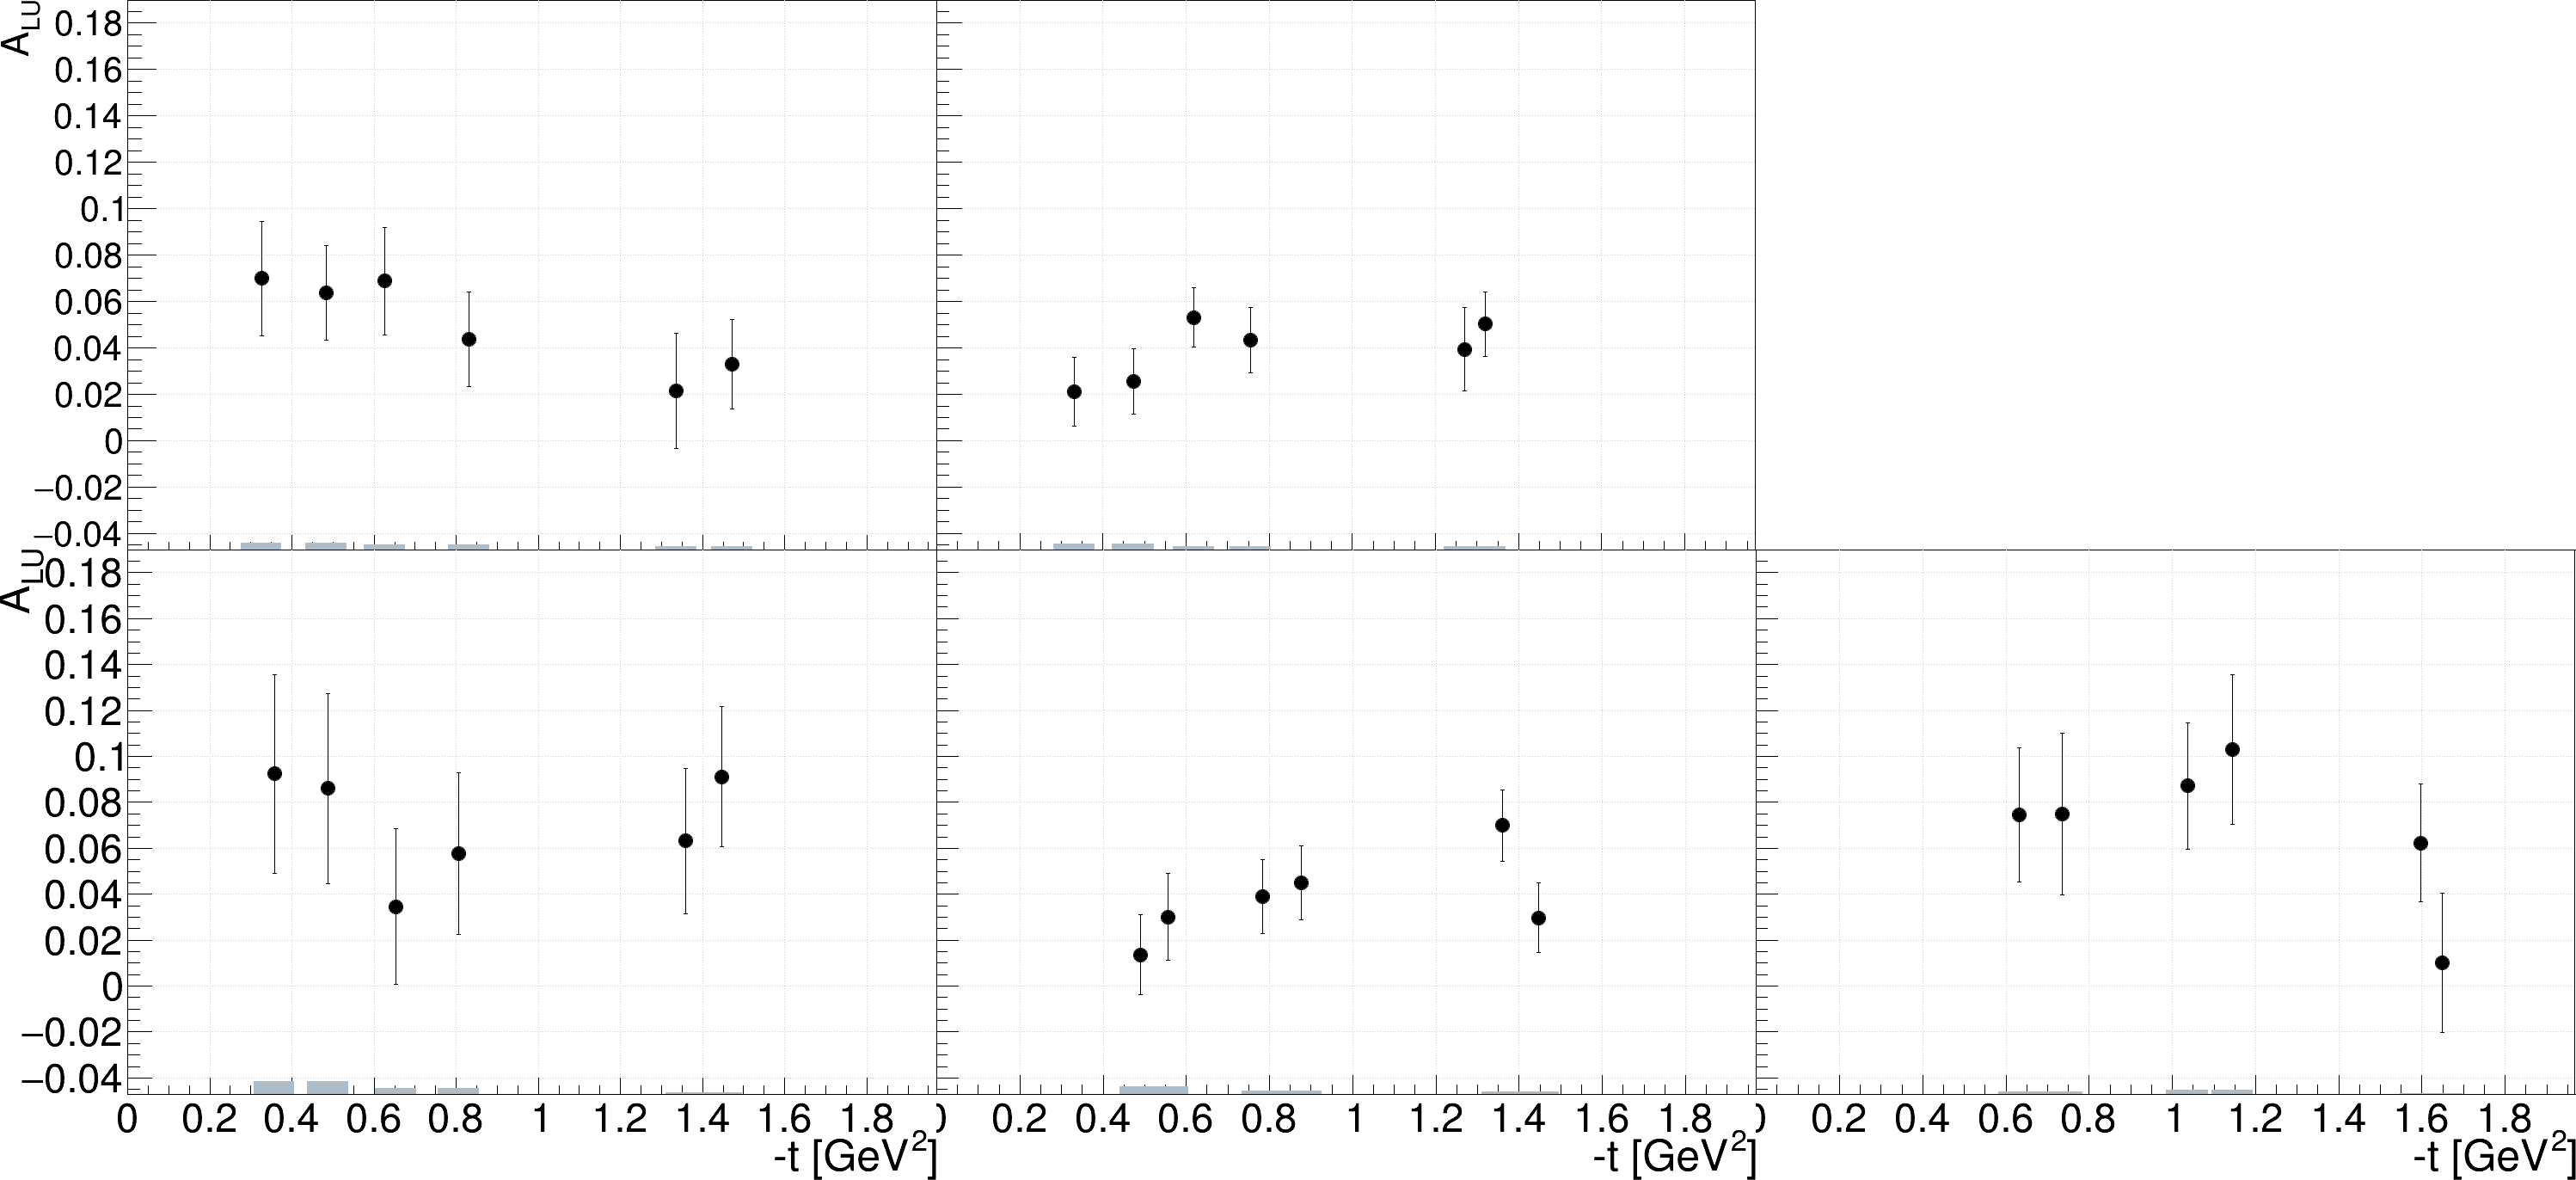

In [18]:
ROOT.gStyle.SetTitleOffset(0.96, 'Y')
ROOT.gStyle.SetPadLeftMargin(0.12)

import json
from collections import defaultdict

httdmigr = ROOT.TH1F("httdmigr","bin migration systematics;#Delta_{syst}",200,0,0.052)

with open("main.output.json") as ff:
    xydys = json.load(ff)

data = {}
for iqx in range(5):
    for ids in range(2):
        for itt in range(3):
            data[(ids,iqx,itt)] = xydys[iqx][ids*3 + itt][1]

with open('bin_migration.json') as ff:
    jcounts = json.load(ff)

ids = -1
counts = {}
for jcnts in jcounts:
    ids += 1
    for kk in jcnts:
        counts[(ids,)+eval(kk)] = jcnts[kk]

dsys = defaultdict(int)
for kk in counts:
    ids,iqx,itt,iqx0,itt0 = kk
    if iqx!=iqx0 or itt!=itt0:
        tot = sum(counts[k0] for k0 in counts if k0[0]==ids and k0[1]==iqx and k0[2]==itt)
        dsys[(ids,iqx,itt)] -= data[(ids,iqx,itt)]*counts[kk]/tot
        dsys[(ids,iqx,itt)] += data[(ids,iqx0,itt0)]*counts[kk]/tot

    
    
idf,idf1,odf,odf1 = rdfs

c1 = ROOT.TCanvas("c1","c1",3000,1400)
c1.Draw()
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,2,0,0)

grs = []

ipad=0
iqx=0
for iqdf in idf.qdfs:
    bid = iqdf.binid
    oqdf = odf.shards[bid]
    ipad += 2 if ipad==2 else 1
    if ipad==2: c1.cd(ipad).SetRightMargin(0.001)

    h1 = c1.cd(ipad).DrawFrame(0,-0.047,1.97,0.19)
    h1.SetTitle(";-t [GeV^{2}];A_{LU}");

    grsys = ROOT.TGraphErrors()

    gr0, gr1 = iqdf.grp1.Clone(), oqdf.grp1.Clone()
    for itt in range(3):
        dsys0, dsys1 = abs(dsys[(0,iqx,itt)]), abs(dsys[(0,iqx,itt)])
        grsys.SetPoint(grsys.GetN(), gr0.GetPointX(itt), -0.047)
        grsys.SetPointError(grsys.GetN()-1, 0.05, dsys0)
        dsysts[(0, bid[0], itt)].append(abs(dsys0))
        grsys.SetPoint(grsys.GetN(), gr1.GetPointX(itt), -0.047)
        grsys.SetPointError(grsys.GetN()-1, 0.05, dsys1)
        dsysts[(1, bid[0], itt)].append(abs(dsys1))
        httdmigr.Fill(dsys0)
        httdmigr.Fill(dsys1)

    gr0.Draw("P")
    gr1.Draw("P")

    gr0.SetMarkerStyle(20)
    gr1.SetMarkerStyle(20)

    grsys.SetFillColor(33)
    grsys.Draw("2")
    grs.append(grsys)
    iqx+=1

c1.Print("pdf/systematics.migration.ALU.pdf")

In [32]:
for kk in dsysts:
    print(kk, len(dsysts[kk]))

jsys = {str(kk):dsysts[kk] for kk in dsysts}
with open("all.systematics.json",'w') as ff:
    json.dump(jsys, ff)

(0, 0, 0) 6
(1, 0, 0) 6
(0, 0, 1) 6
(1, 0, 1) 6
(0, 0, 2) 6
(1, 0, 2) 6
(0, 1, 0) 6
(1, 1, 0) 6
(0, 1, 1) 6
(1, 1, 1) 6
(0, 1, 2) 6
(1, 1, 2) 6
(0, 2, 0) 6
(1, 2, 0) 6
(0, 2, 1) 6
(1, 2, 1) 6
(0, 2, 2) 6
(1, 2, 2) 6
(0, 3, 0) 6
(1, 3, 0) 6
(0, 3, 1) 6
(1, 3, 1) 6
(0, 3, 2) 6
(1, 3, 2) 6
(0, 4, 0) 6
(1, 4, 0) 6
(0, 4, 1) 6
(1, 4, 1) 6
(0, 4, 2) 6
(1, 4, 2) 6


-----------------------
-----------------------
-----------------------

# Systematics Summary

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c3


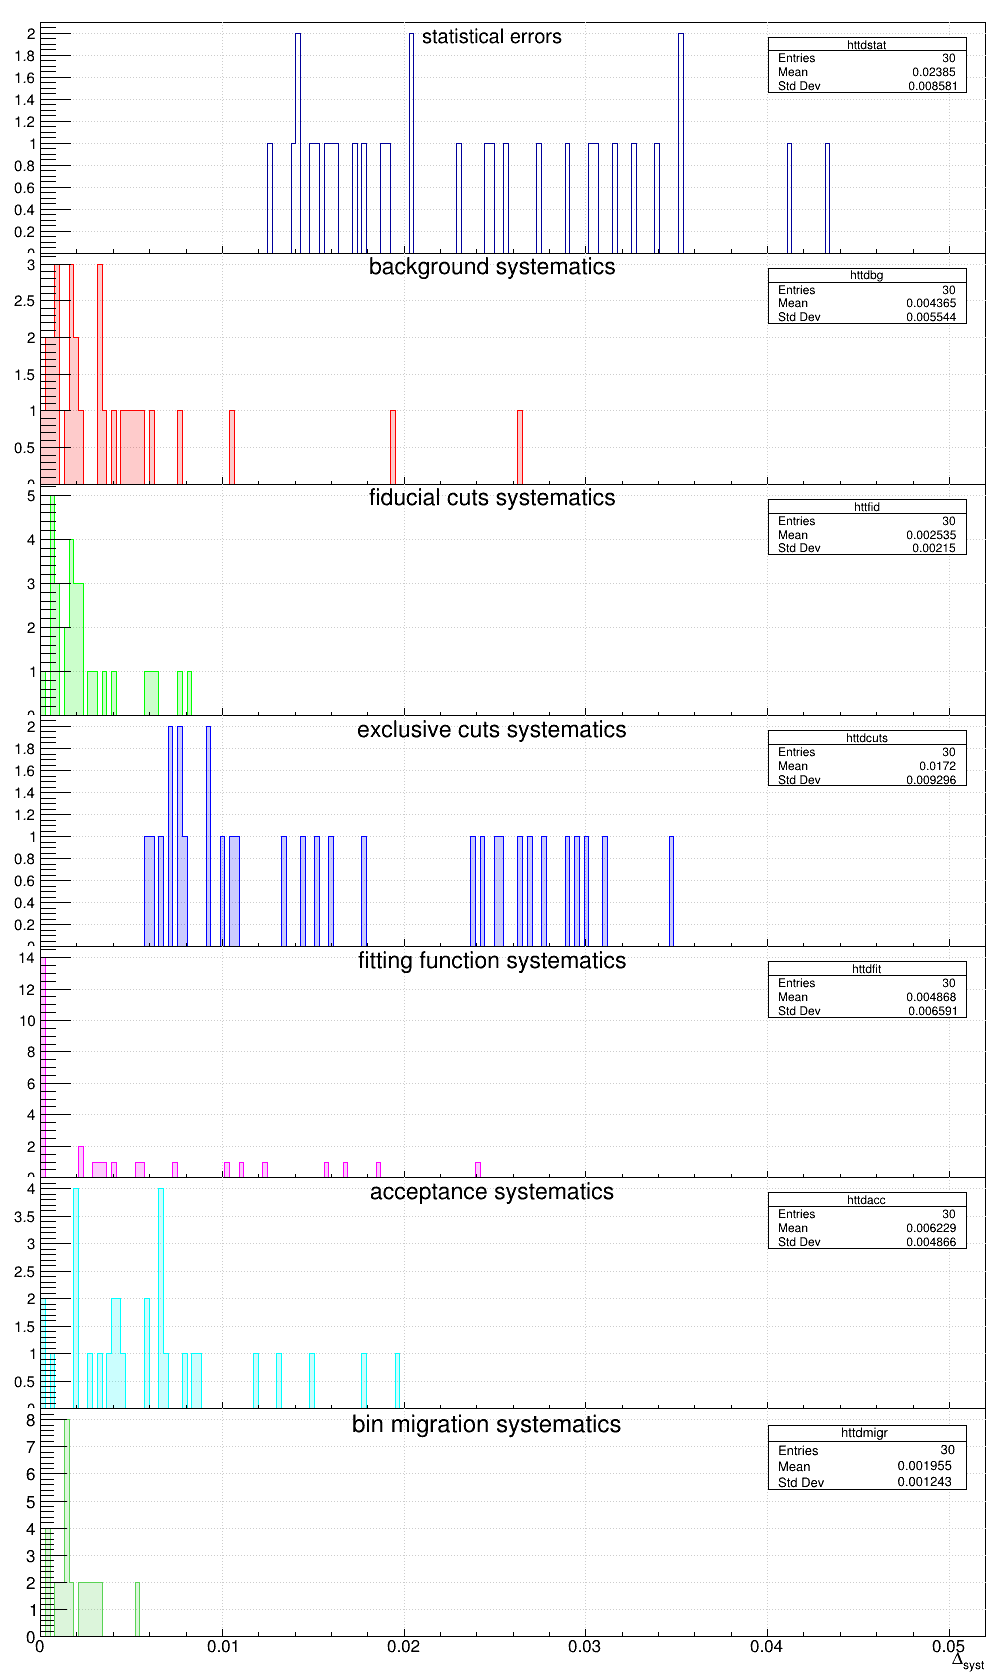

In [20]:
ROOT.gStyle.SetPadLeftMargin(0.04)
ROOT.gStyle.SetPadBottomMargin(0.13)

c3 = ROOT.TCanvas("c3","c3",1000,1700)
c3.Divide(1,7,0,0)
c3.Draw()

ROOT.gStyle.SetOptStat(1)
c3.cd(1)
httdstat.Draw()
c3.cd(2)
httdbg.SetLineColor(2)
httdbg.SetFillColorAlpha(2,0.2)
httdbg.Draw()
c3.cd(3)
httdfid.SetLineColor(3)
httdfid.SetFillColorAlpha(3,0.2)
httdfid.Draw()
c3.cd(4)
httdcuts.SetLineColor(4)
httdcuts.SetFillColorAlpha(4,0.2)
httdcuts.Draw()
c3.cd(5)
httdfit.SetLineColor(6)
httdfit.SetFillColorAlpha(6,0.2)
httdfit.Draw()
c3.cd(6)
httdacc.SetLineColor(7)
httdacc.SetFillColorAlpha(7,0.2)
httdacc.Draw()
c3.cd(7)
httdmigr.SetLineColor(8)
httdmigr.SetFillColorAlpha(8,0.2)
httdmigr.Draw()

c3.Print("pdf/systematics.summary.dALU.pdf")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c3


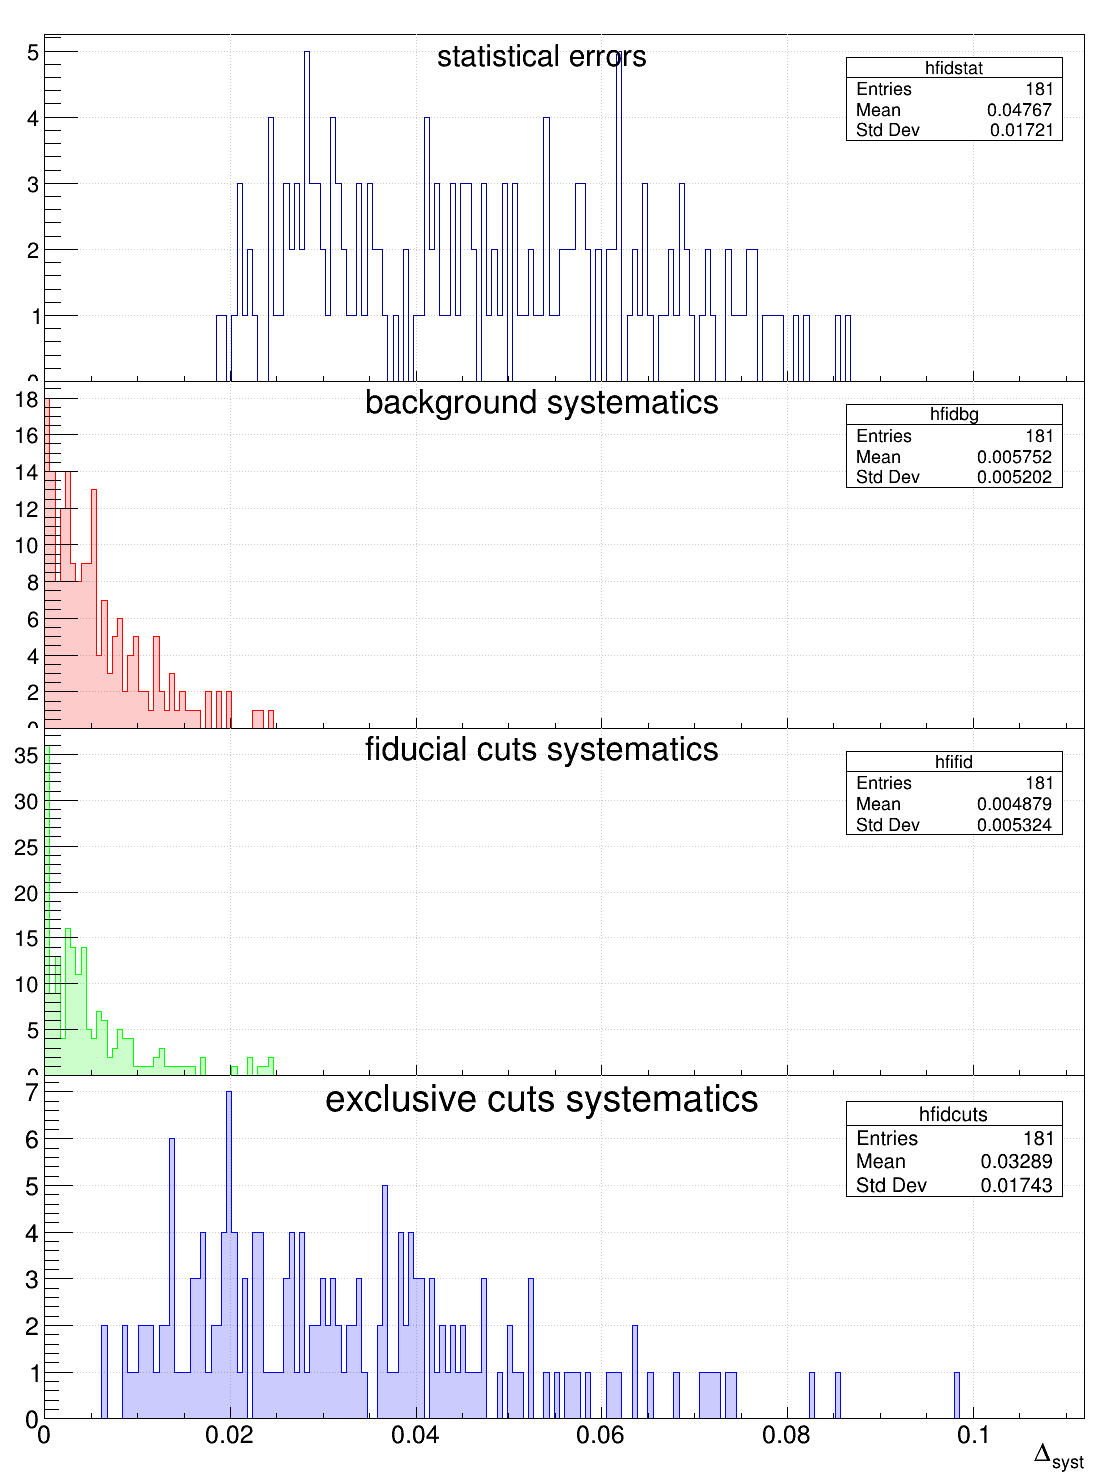

In [21]:
ROOT.gStyle.SetPadLeftMargin(0.04)
ROOT.gStyle.SetPadBottomMargin(0.13)

c3 = ROOT.TCanvas("c3","c3",1100,1500)
c3.Divide(1,4,0,0)
c3.Draw()

ROOT.gStyle.SetOptStat(1)
c3.cd(1)
hfidstat.Draw()
c3.cd(2)
hfidbg.SetLineColor(2)
hfidbg.SetFillColorAlpha(2,0.2)
hfidbg.Draw()
c3.cd(3)
hfidfid.SetLineColor(3)
hfidfid.SetFillColorAlpha(3,0.2)
hfidfid.Draw()
c3.cd(4)
hfidcuts.SetLineColor(4)
hfidcuts.SetFillColorAlpha(4,0.2)
hfidcuts.Draw()

c3.Print("pdf/systematics.summary.dBSA.pdf")

# Final plot
### $A_{LU}$ vs $-t$ for each $\{Q^2,x_B\}$ bin

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


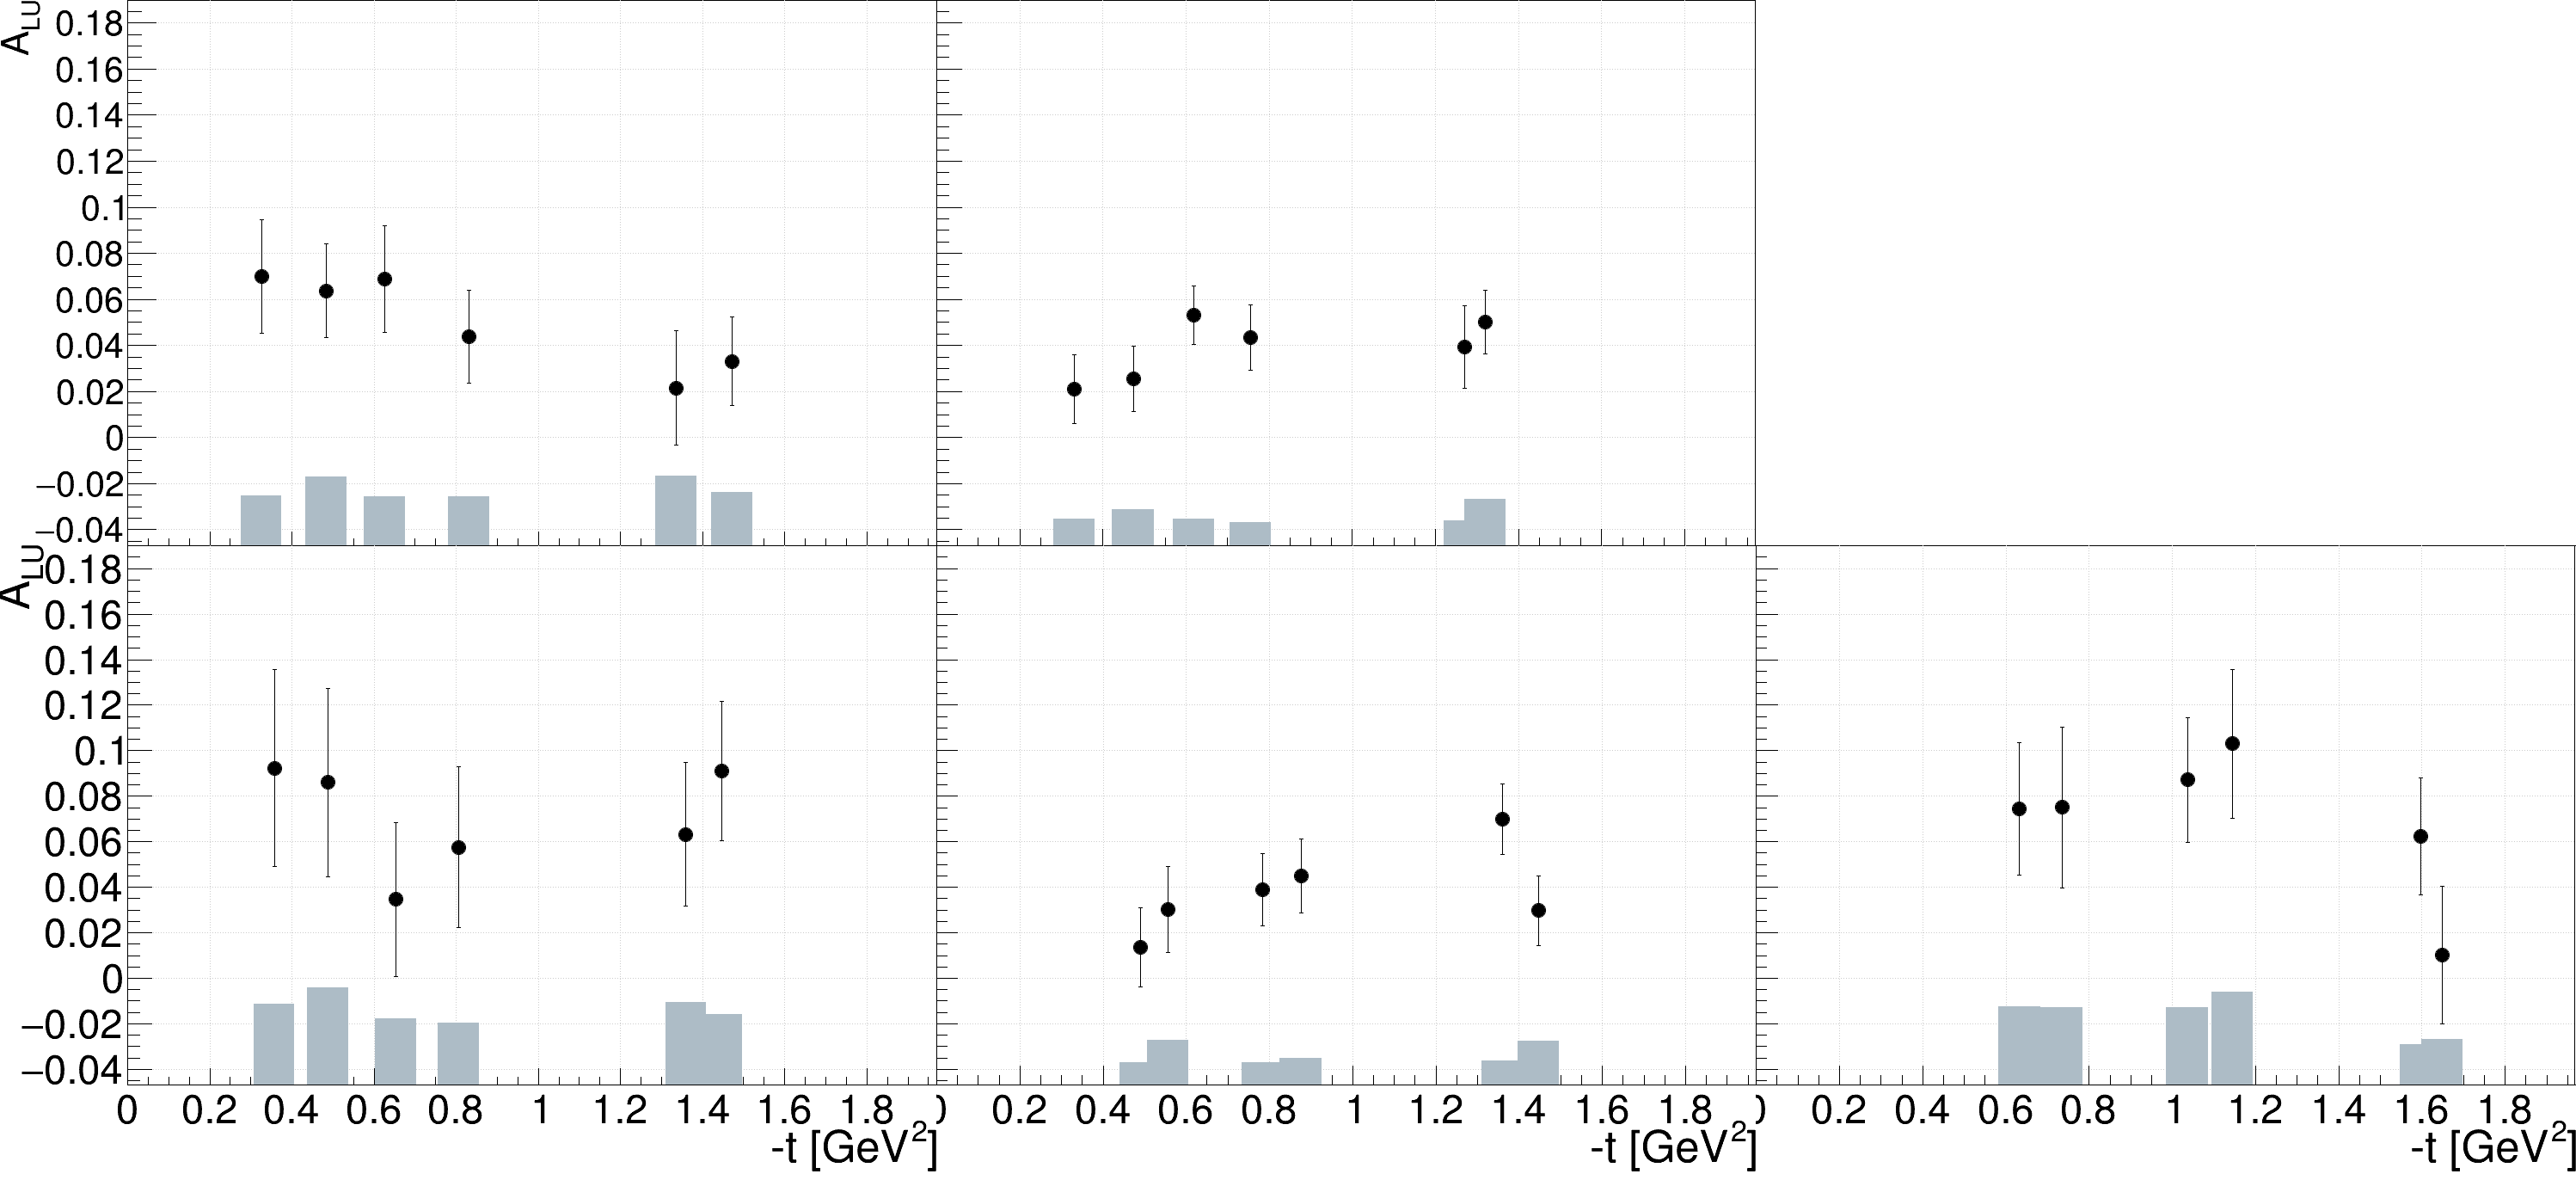

In [29]:
ROOT.gStyle.SetTitleOffset(0.96, 'Y')
ROOT.gStyle.SetPadLeftMargin(0.12)

idf,idf1,odf,odf1 = rdfs

c1 = ROOT.TCanvas("c1","c1",3000,1400)
c1.Draw()
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,2,0,0)

grs = []

iqx = 0
ipad=0
for iqdf in idf.qdfs:
    bid = iqdf.binid
    oqdf = odf.shards[bid]
    ipad += 2 if ipad==2 else 1
    if ipad==2: c1.cd(ipad).SetRightMargin(0.001)

    h1 = c1.cd(ipad).DrawFrame(0,-0.047,1.97,0.19)
    h1.SetTitle(";-t [GeV^{2}];A_{LU}");

    grsys = ROOT.TGraphErrors()

   
    gr0, gr1 = iqdf.grp1.Clone(), oqdf.grp1.Clone()
    for itt in range(3):
        dsys = math.sqrt(sum(ds*ds for ds in dsysts[(0,bid[0],itt)]))
        grsys.SetPoint(grsys.GetN(), gr0.GetPointX(itt), -0.047)
        grsys.SetPointError(grsys.GetN()-1, 0.05, dsys)

        dsys = math.sqrt(sum(ds*ds for ds in dsysts[(1,bid[0],itt)]))
        grsys.SetPoint(grsys.GetN(), gr1.GetPointX(itt), -0.047)
        grsys.SetPointError(grsys.GetN()-1, 0.05, dsys)

        
    gr0.Draw("P")
    gr1.Draw("P")

    gr0.SetMarkerStyle(20)
    gr1.SetMarkerStyle(20)

    grsys.SetFillColor(33)
    grsys.Draw("2")
    grs.append(grsys)

c1.Print("pdf/ALU.withsyst.pdf")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


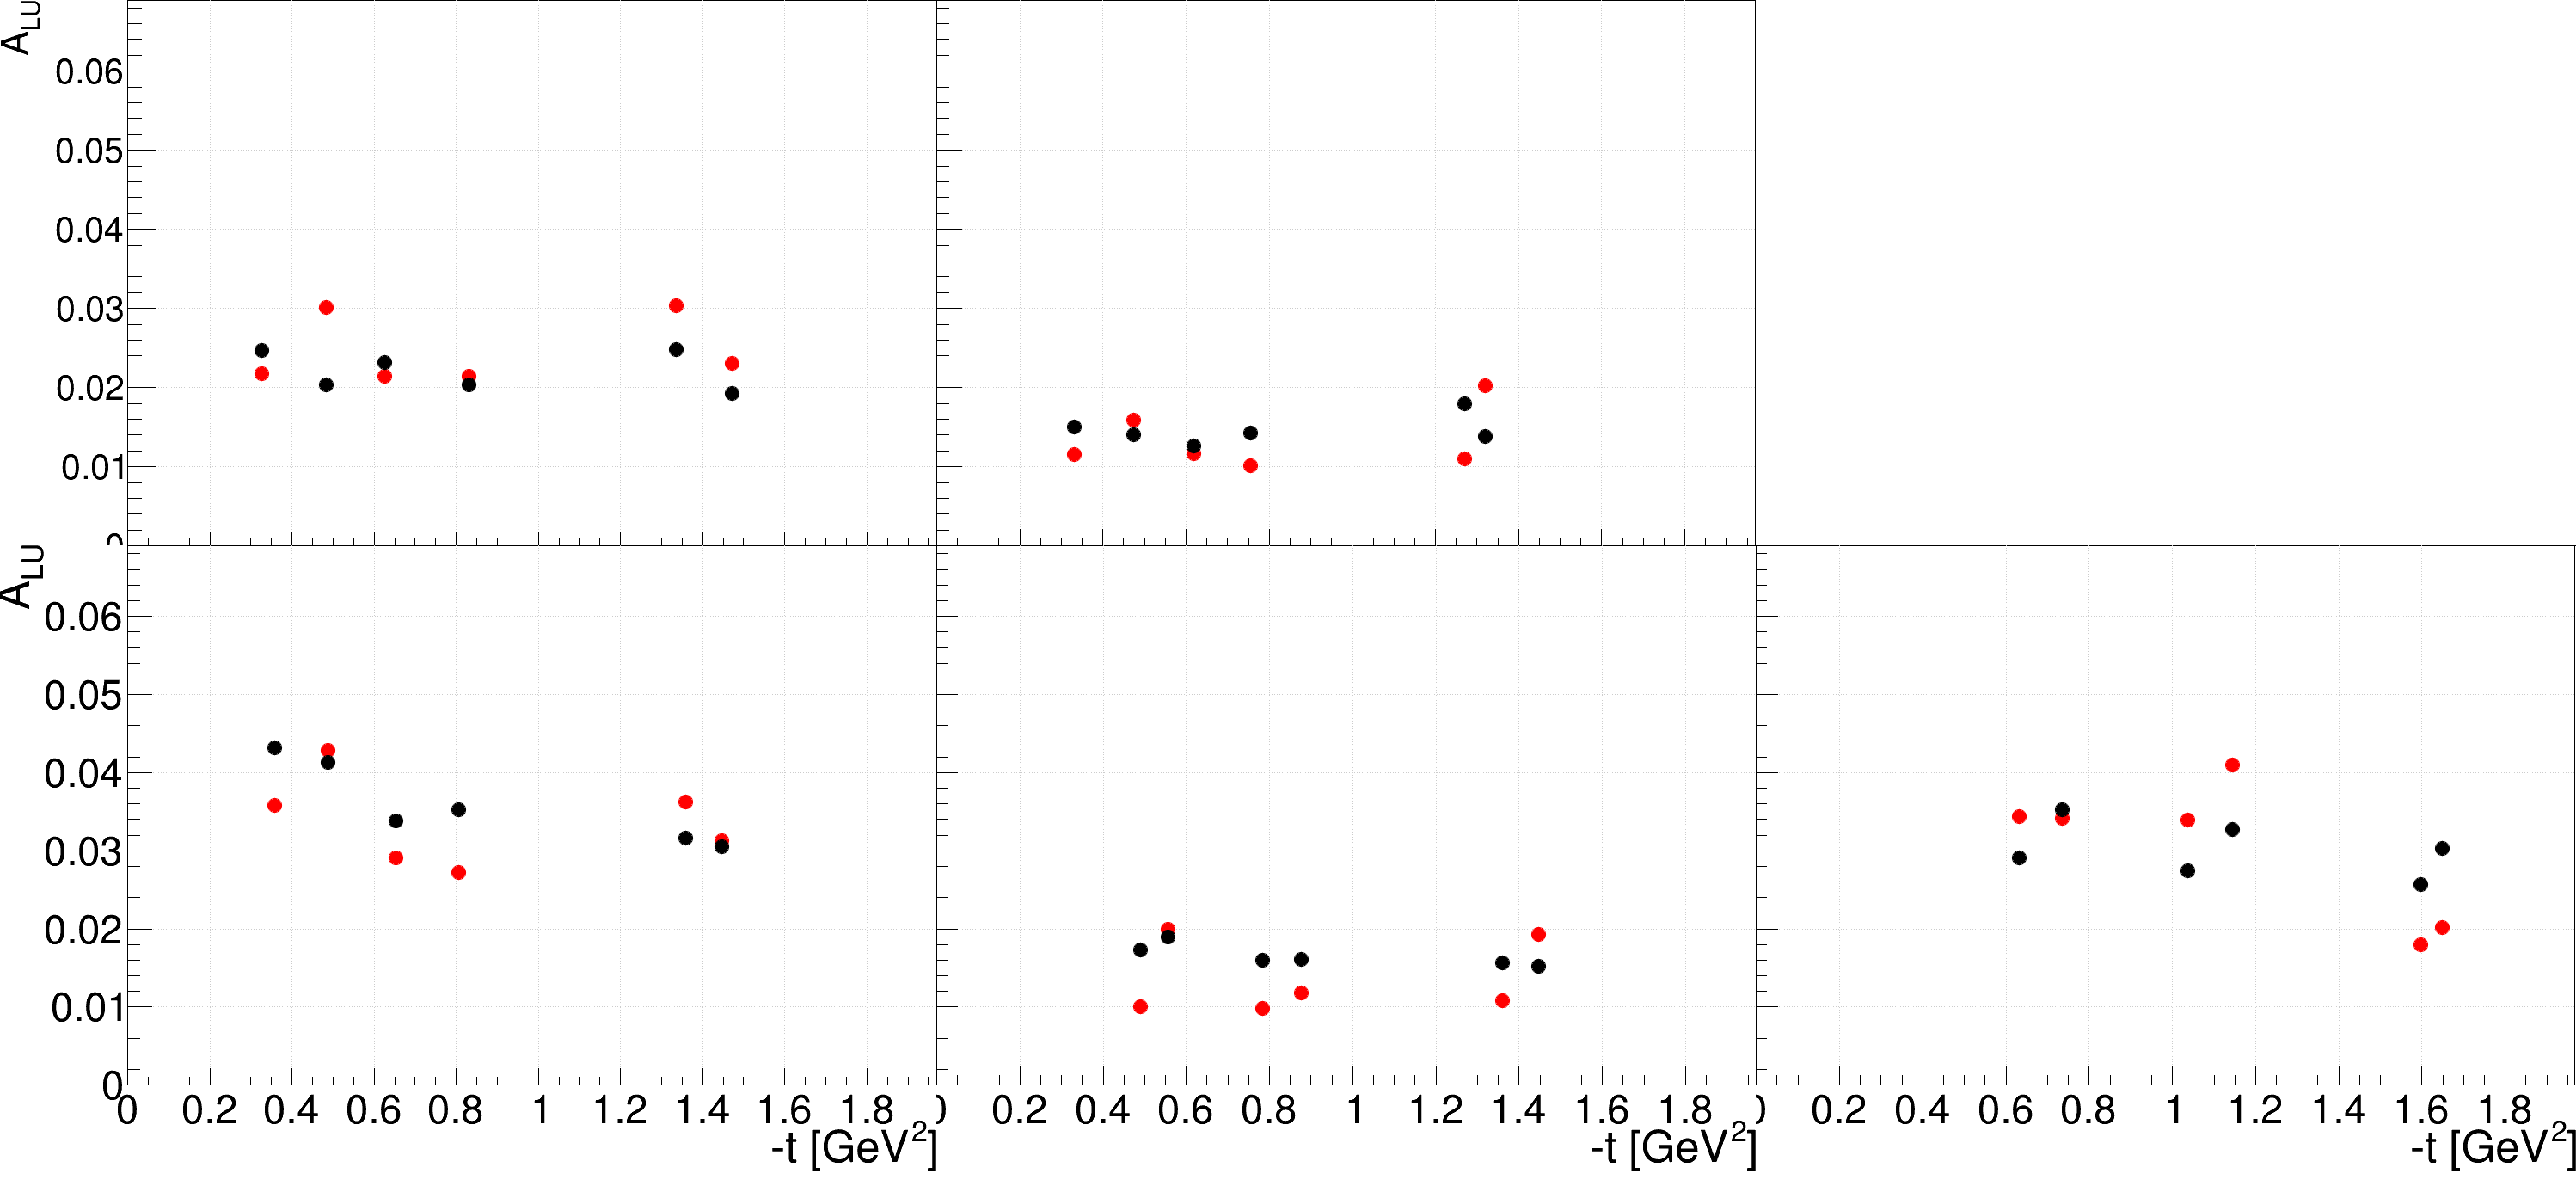

In [28]:
ROOT.gStyle.SetTitleOffset(0.96, 'Y')
ROOT.gStyle.SetPadLeftMargin(0.12)

idf,idf1,odf,odf1 = rdfs

c1 = ROOT.TCanvas("c1","c1",3000,1400)
c1.Draw()
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,2,0,0)

grs = []

iqx = 0
ipad=0
for iqdf in idf.qdfs:
    bid = iqdf.binid
    oqdf = odf.shards[bid]
    ipad += 2 if ipad==2 else 1
    if ipad==2: c1.cd(ipad).SetRightMargin(0.001)

    h1 = c1.cd(ipad).DrawFrame(0,0,1.97,0.069)
    h1.SetTitle(";-t [GeV^{2}];A_{LU}");

    grstat, grsys = ROOT.TGraph(), ROOT.TGraph()

    gr0, gr1 = iqdf.grp1.Clone(), oqdf.grp1.Clone()
    for itt in range(3):
        dsys = math.sqrt(sum(ds*ds for ds in dsysts[(0,bid[0],itt)]))
        grstat.SetPoint(grstat.GetN(), gr0.GetPointX(itt), gr0.GetErrorY(itt))
        grsys.SetPoint(grsys.GetN(), gr0.GetPointX(itt), dsys)
        
        dsys = math.sqrt(sum(ds*ds for ds in dsysts[(1,bid[0],itt)]))
        grstat.SetPoint(grstat.GetN(), gr1.GetPointX(itt), gr1.GetErrorY(itt))
        grsys.SetPoint(grsys.GetN(), gr1.GetPointX(itt), dsys)

        
    grsys.Draw("P")
    grstat.Draw("P")

    grsys.SetMarkerStyle(20)
    grstat.SetMarkerStyle(20)

    grsys.SetMarkerColor(2)

    grs.append((grstat,grsys))

#c1.Print("pdf/systematics.background.ALU.pdf")

------------------------
------------------------